In [1]:
# what we see now is like a dim image in a mirror
import os
import json
import glob
import lzma
import numpy as np
import pandas as pd
import datetime
import random

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

from tqdm import tqdm_notebook

# plt.style.use('dark_background')
TEXT_COLOR = 'w'
mpl.rcParams['axes.facecolor'] = '#373d4b'
mpl.rcParams['text.color'] = TEXT_COLOR
mpl.rcParams['axes.labelcolor'] = TEXT_COLOR
mpl.rcParams['xtick.color'] = TEXT_COLOR
mpl.rcParams['ytick.color'] = TEXT_COLOR

import operator
from functools import reduce
from itertools import product
from scipy.ndimage import measurements

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

SEED = 420

LOG_DIR = os.path.join('../models', 'train_log')
DATA_DIR = '../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'training')
EVAL_DIR = os.path.join(DATA_DIR, 'evaluation')
TEST_DIR = os.path.join(DATA_DIR, 'test')

df_sub = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

train_ids = [fn.split('.json')[0] for fn in os.listdir(TRAIN_DIR)]
eval_ids = [fn.split('.json')[0] for fn in os.listdir(EVAL_DIR)]
test_ids = [fn.split('.json')[0] for fn in os.listdir(TEST_DIR)]
eval_ids = list(set(eval_ids).difference(test_ids))

train_filepaths = glob.glob(TRAIN_DIR + '/*')
eval_filepaths = [os.path.join(EVAL_DIR, f'{t}.json') for t in eval_ids]
test_filepaths = glob.glob(TEST_DIR + '/*')

id_to_filepath = {}

for task_id in train_ids:
    id_to_filepath[task_id] = os.path.join(TRAIN_DIR, f'{task_id}.json')
for task_id in eval_ids:
    id_to_filepath[task_id] = os.path.join(EVAL_DIR, f'{task_id}.json')
    
test_id_to_filepath = {}
for task_id in test_ids:
    test_id_to_filepath[task_id] = os.path.join(TEST_DIR, f'{task_id}.json')

In [3]:
def load_task(filepath, verbose=0):
    if verbose:
        task_id = filepath.split('/')[-1].split('.json')[0]
        group = filepath.split('/' + task_id)[0].split('/')[-1]
        print(f"Loading {group} task {task_id}")
    with open(filepath, 'r') as f:
        task = json.load(f)
    return task

def load_task_from_id(task_id):
    task_filename = f'{task_id}.json'
    task_filepath = None
    for root in [TRAIN_DIR, EVAL_DIR, TEST_DIR]:
        if task_filename in os.listdir(root):
            task_filepath = os.path.join(root, task_filename)
    if task_filepath is None:
        raise ValueError(f'`task_id` {task_id} not found.')
    return load_task(task_filepath)

def strip_task(filepath):
    return filepath.split('/')[-1].split('.json')[0]
        

def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def unflattener(str_pred):
    pred = []
    for row in str_pred.strip('|').split('|'):
        pred.append([int(row[i]) for i in range(len(row))])
    return np.array(pred, dtype=np.uint8)

# https://github.com/fchollet/ARC/blob/master/apps/css/common.css
NUM_SYMBOLS = 10
COLORS = [
    '#000000',
    '#0074D9',
    '#FF4136',
    '#2ECC40',
    '#FFDC00',
    '#AAAAAA',
    '#F012BE',
    '#FF851B',
    '#7FDBFF',
    '#870C25',
]

idx_to_color = {
    0: 'black',
    1: 'blue',
    2: 'red',
    3: 'green',
    4: 'yellow',
    5: 'grey',
    6: 'pink',
    7: 'orange',
    8: 'light blue',
    9: 'brown',
}

color_to_idx = {v: k for k, v in idx_to_color.items()}

idx_to_hex = {
    0: '#000000',
    1: '#0074D9',
    2: '#FF4136',
    3: '#2ECC40',
    4: '#FFDC00',
    5: '#AAAAAA',
    6: '#F012BE',
    7: '#FF851B',
    8: '#7FDBFF',
    9: '#870C25',
}

cmap = colors.ListedColormap(COLORS)
norm = colors.Normalize(vmin=0, vmax=9)
grid_params = {
    'cmap': cmap,
    'norm': norm
}

def generate_idx_to_rgb(hex_list):
    idx_to_rgb = {}
    for i, color in enumerate(hex_list):
        h = color.strip('#')
        rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
        idx_to_rgb[i] = rgb
    return idx_to_rgb

idx_to_rgb = generate_idx_to_rgb(COLORS)

In [4]:
################################################################################
# plot functions
################################################################################

def plot_grid(x, 
              output_shape=None,
              ax=None,
              use_ticks=True,
              title=None,
              lw=.75,
              dpi=100,
              **kwargs):
    kwargs = dict(grid_params, **kwargs)
    x = np.asarray(x)
    
    if output_shape is not None:
        x = unpad(x, output_shape)
        
    ax = ax or plt.axes()
    fig = ax.figure
    fig.set_dpi(dpi)
    p = ax.imshow(x, **kwargs)
    
    if title is not None:
        ax.set_title(title, size=12)
    if use_ticks:
        ax.set_xticks(list(range(x.shape[1])))
        ax.set_yticks(list(range(x.shape[0])))
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    
    if lw > 0:
        [ax.axvline(i+0.5, c='#555', lw=lw) for i in range(x.shape[1])]
        [ax.axhline(i+0.5, c='#555', lw=lw) for i in range(x.shape[0])]
    
    return p
    
    
def plot_grids(x, cmaps=None, mask_th=0, num_grids=8):
    num_samples = len(x)
    if num_grids < num_samples:
        indices = np.random.choice(range(num_samples), 
                                   num_grids,
                                   replace=False)
    else:
        indices = range(num_samples)
        num_grids = num_samples
    
    fig, ax = plt.subplots(1, 
                           num_grids, 
                           figsize=(num_grids * 5, num_grids * 4))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax if isinstance(ax, np.ndarray) else [ax]
    
    for i, idx in enumerate(indices):
        x_grid = x[idx]
        if cmaps is not None:
            x_grid = channel_to_grid(x_grid, cmaps[idx], mask_th)
        plot_grid(x_grid, ax=ax[i])
    
    plt.show();
    
    
def plot_gradient(x, ax=None, show_color_bar=True):
    ax = ax or plt.axes()
    p = ax.imshow(x)
    
    if show_color_bar:
        fig = ax.get_figure()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(p, cax=cax)
    
    ax.set_xticks(list(range(x.shape[1])))
    ax.set_yticks(list(range(x.shape[0])))
    [ax.axvline(i+0.5, c='#555', lw=.5) for i in range(x.shape[1])]
    [ax.axhline(i+0.5, c='#555', lw=.5) for i in range(x.shape[0])];
    
    return ax

    
def plot_task(task, 
              pred_fn=None,
              task_id=None,
              dpi=60,
              **kwargs):
    """Plots the train and test input & outputs for a `task`."""
    num_train = len(task['train'])
    num_test = len(task['test'])
    num_rows = 3 if pred_fn else 2
    N = num_train + num_test
    
    fig, ax = plt.subplots(num_rows, 
                           N, 
                           figsize=(6 * N, 12), 
                           dpi=dpi)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    if task_id is not None:
        print(task_id)
    
    for i in range(num_train):
        x_grid = np.array(task['train'][i]['input'])
        y_grid = np.array(task['train'][i]['output'])

        plot_grid(x_grid, ax=ax[0][i], title=f'train_{i} in', **kwargs)
        plot_grid(y_grid, ax=ax[1][i], title=f'train_{i} out', **kwargs)
        
        if pred_fn is not None:
            y_pred = pred_fn(x_grid)
            plot_grid(y_pred, ax=ax[2][i], title=f'train_{i} pred', **kwargs)
        
    for i in range(num_test):
        x_grid = np.array(task['test'][i]['input'])
        plot_grid(x_grid, ax=ax[0][num_train+i], title=f'test_{i} in', **kwargs)
        
        if task['test'][i].get('output'):
            y_grid = np.array(task['test'][i]['output'])
            plot_grid(y_grid, ax=ax[1][num_train+i], title=f'test_{i} out', **kwargs)
        
        if pred_fn is not None:
            y_pred = pred_fn(x_grid)
            plot_grid(y_pred, ax=ax[2][num_train+i], title=f'test_{i} pred', **kwargs)
        
    plt.show();

def get_examples(examples, set_objects=False, find_children=False):
    x_examples = []
    y_examples = []
    for i in range(len(examples)):
        x_examples.append(Example(np.array(examples[i]['input']), 
                                  set_objects=set_objects,
                                  find_children=find_children))
        if examples[i].get('output'):
            y_examples.append(Example(np.array(examples[i]['output']), 
                                      set_objects=set_objects,
                                      find_children=find_children))
        else:
            y_examples.append(Example(None))
        
    return x_examples, y_examples
    
def get_input_output(examples):
    x_examples = []
    y_examples = []
    for i in range(len(examples)):
        x_examples.append(np.array(examples[i]['input']))
        if examples[i].get('output'):
            y_examples.append(np.array(examples[i]['output']))
        
    return x_examples, y_examples

def score_example(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
#     if y_true.shape != y_pred.shape:
#         raise ValueError("Output and prediction shapes don't match. "
#                         f"Expected {y_true.shape}, got {y_pred.shape}")
    
    score = np.sum(y_true == y_pred) / y_pred.size
    return score


def score_examples(y_true, y_pred):
    if not isinstance(y_true, list):
        y_true = [y_true]
    if not isinstance(y_pred, list):
        y_pred = [y_pred]
    return np.mean([score_task(y_true[i], y_pred[i]) for i in range(len(y_true))])


def solve_task_symbolic(task, solve_fn, plot_task=True, **kwargs):
    train_samples = task['train']
    test_samples = task['test']

    num_train = len(train_samples)
    num_test = len(test_samples)
    N = num_train + num_test
    
    if plot_task:
        fig, ax = plt.subplots(3, 
                               N, 
                               figsize=(6 * N, 12), 
                               dpi=50)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)

    is_scores = []
    oos_scores = []
    oos_preds = []

    for i in range(num_train):
        x_train = train_samples[i]['input']
        y_train = train_samples[i]['output']
        y_pred = solve_fn(x_train)
        is_scores.append(score_task(y_train, y_pred))
        
        if plot_task:
            plot_grid(x_train, ax[0][i], title=f'train_{i} in', **kwargs)
            plot_grid(y_train, ax[1][i], title=f'train_{i} out', **kwargs)
            plot_grid(y_pred, ax[2][i], title=f'train_{i} pred', **kwargs)
    
    for i in range(num_test):
        x_test = test_samples[i]['input']
        y_pred = solve_fn(x_test)
        
        if plot_task:
            plot_grid(x_test, ax[0][num_train+i], title=f'test_{i} in', **kwargs)
            plot_grid(y_pred, ax[2][num_train+i], title=f'test_{i} pred', **kwargs)

        if test_samples[i].get('output'):
            y_test = test_samples[i]['output']
            oos_scores.append(score_task(y_test, y_pred))
            if plot_task:
                plot_grid(y_test, ax[1][num_train+i], title=f'test_{i} out', **kwargs)

        oos_preds.append(y_pred)
        
    
    print(f'IS acc  : {np.mean(is_scores):.4f}')
    if len(oos_scores) > 0:
        print(f'OOS acc : {np.mean(oos_scores):.4f}')
    
    return np.array(oos_preds)


def plot_numeric(x, bold_th=None, figsize=None):
    h,w = x.shape
    s = 1
    figsize = figsize or (int(w*.8),int(h*.8))
    
    bold_th = bold_th or 0
    
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(0, h*s+1)
    ax.set_xlim(0, w*s+1)
    
    for i in range(0, h*s, s):
        for j in range(0, w*s, s):
            v = x[i//s,j//s]
            weight = 'bold' if v > bold_th else None
            ax.text(j+.5, h-i+.5, f' {v:.3f} ', weight=weight)

    ax.set(frame_on=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [5]:
################################################################################
# dataframe utils
################################################################################
def display_row(s):
    if len(s) == 1 & isinstance(s, pd.DataFrame):
        s = s.iloc[0]
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        print(s)

def loc_all(conditions):
    return reduce(operator.and_, conditions, True)

def loc_any(conditions):
    return reduce(operator.or_, conditions, True)

def subset_df(df, conditions, how='all'):
    if how == 'any':
        return df.loc[loc_any(conditions(df))]
    else:
        return df.loc[loc_all(conditions(df))]

################################################################################
# non essential functions
################################################################################
def compute_objs(x, background_color=None):
    x = np.asarray(x)
    if background_color:
        _x = np.ravel(x[0]).tolist()
        background_color = max(set(_x), key=_x.count)
    else:
        background_color = 0
    return measurements.label(x != background_color)[1]

def frequency(x, value):
    return np.ravel(x).tolist().count(value)

def most_common(x):
    _x = np.ravel(x).tolist()
    return max(set(_x), key=_x.count)
    
def compute_objectness(x):
    x = np.asarray(x)
    bkgr_color = most_common(x)
    num_bkgr_color = frequency(x, bkgr_color)
    num_objs = measurements.label(x != bkgr_color)[1]
    return num_objs, bkgr_color, num_bkgr_color


In [6]:
################################################################################
# geometric functions (objects)
################################################################################

def get_dims(x):
    """Returns the (b)atch, (h)eight, (w)idth, and (d)epth of an array/tensor."""
    ndim = len(x.shape) # in the case of a tensor
    if ndim == 2:
        return (0, *x.shape, 0)
    elif ndim == 4:
        return x.shape
    else:
        raise ValueError(f"Expected 2 or 4 dims, got {x.ndim}")
        
        
def identity(x):
    return x

def transpose(x):
    b, h, w, d = get_dims(x)
    if b == 0:
        xt = np.zeros((w, h), dtype=np.uint8)

        for i in range(w):
            for j in range(h):
                xt[i][j] = x[j][i]
        return xt
    else:
        xt = np.zeros((b, w, h, d), dtype=np.uint8)
        for i in range(w):
            for j in range(h):
                xt[:,i,j,:] = x[:,j,i,:]
        return xt

def rot90(x):
    b, h, w, d = get_dims(x)
    if b == 0:
        return np.array([[x[h-1-i, j] for i in range(h)] for j in range(w)])
    else:
        return np.moveaxis(
            [[x[:, h-1-i, j, :] for i in range(h)] for j in range(w)], 
            source=2, 
            destination=0
        )

def rot90_n(x, n=1):
    for i in range(n):
        x = rot90(x)
    return x

def rot180(x):
    return rot90_n(x, n=2)

def rot270(x):
    return rot90_n(x, n=3)

def flip_y(x):
    b, h, w, d = get_dims(x)
    if b == 0:
        return flip_x(x.T).T
    else:
        raise ValueError('needs testing')
        return np.moveaxis(
            [[x[:,i,w-1-j,:] for j in range(w)] for i in range(h)], 
            source=2, 
            destination=0
        )

def flip_x(x):
    b, h, w, d = get_dims(x)
    if b == 0:
#         return np.array([[x[i, w-1-j] for j in range(w)] for i in range(h)])
        return np.array([[x[h-1-i, j] for j in range(w)] for i in range(h)])
    else:
        return np.moveaxis(
            [[xt[:,i,w-1-j,:] for j in range(w)] for i in range(h)], 
            source=2, 
            destination=0
        ).T

def flip_xy(x):
    return flip_y(flip_x(x))

def shift_obj(x, y=None, max_shift=3, pad_value=0.):
    x_shift = []
    y_shift = []
    max_shift = max(max_shift, 1)
    
    b, h, w, d = get_dims(x)
        
    h_indices = np.arange(h)
    w_indices = np.arange(w)

    shift_w = np.random.choice(range(-max_shift+1, max_shift))
    shift_h = np.random.choice(range(-max_shift+1, max_shift))

    h_idx = h_indices[:shift_h] if shift_h < 0 else h_indices[shift_h:]
    w_idx = w_indices[:shift_w] if shift_w < 0 else w_indices[shift_w:]

    hp = (-shift_h, 0) if shift_h < 0 else (0, shift_h)
    wp = (-shift_w, 0) if shift_w < 0 else (0, shift_w)
    x_shift = pad(x[h_idx,:][:,w_idx], hp, wp, pad_value=pad_value)

    if y is not None:
        y_shift = pad(y[h_idx,:][:,w_idx], hp, wp, pad_value=pad_value)
    
    if y is not None:
        return x_shift, y_shift
    else:
        return x_shift


################################################################################
# algorithmic complexity functions
################################################################################

COMPRESSION_METHODS = [
    'lzma',
#     'gzip',
#     'zlib',
#     'bz2'
]

METHOD_TO_BOUND = {
    'lzma': 60,
    'gzip': 21,
    'zlib': 9,
    'bz2': 37
}


def compute_complexity(x, method='lzma'):
    if method not in COMPRESSION_METHODS:
        raise(f'Unrecognized method {method}')
    bound = METHOD_TO_BOUND.get(method, 0)
    
    if isinstance(x, np.ndarray):
        x = x.tolist()
    if isinstance(x, list):
        x = flattener(x)
    
    bytes_in = x.encode('utf-8')
    num_bytes_out = len(eval(method).compress(bytes_in)) - bound
    return num_bytes_out, num_bytes_out / len(bytes_in)


################################################################################
# object functions 
################################################################################

def compute_object_matrix(x, background_color=0, structure=None):
    object_matrix = np.zeros_like(x, dtype=np.uint8)
    symbols = [s for s in set(np.unique(x)) if s != background_color]
    
    num_labels = 0
    for s in symbols:
        matrix, n = measurements.label(x == s, structure=structure)
        matrix[matrix != 0] += num_labels
        object_matrix = object_matrix + matrix
        num_labels += n
    
    return object_matrix

def compute_symbolic_matrix(x, background_color=0, structure=None):
    if background_color != 0:
        x = np.array(x, copy=True)
        x[x == 0] = -1
        x[x == background_color] = 0
    return measurements.label(x, structure=structure)[0].astype(np.uint8)
    
    symbols = [s for s in set(np.unique(x)) if s != background_color]
    
    num_labels = 0
    for s in symbols:
        matrix, n = measurements.label(x == s, structure=structure)
        matrix[matrix != 0] += num_labels
        object_matrix = object_matrix + matrix
        num_labels += n
    
    return object_matrix

def set_children(objs):
    for obj in objs:
        if obj.num_blobs > 0:
            obj.find_children(objs)

def get_objects(x, 
                background_color=0,
                f=None,
                structure=None,
                method='object',
                find_children=False):
    """Returns a list of object coordinates, colors, and shapes.
    
    Applies a function THEN saves off the indices, meta data, etc
    """
    x = np.asarray(x)
    if f is not None:
        x = f(x)
    x_1d = np.ravel(x).tolist()
    
    if method == 'symbolic':
        obj_matrix = compute_symbolic_matrix(x, background_color, structure)
    else:
        obj_matrix = compute_object_matrix(x, background_color, structure)
    
    labels = np.unique(obj_matrix)[1:]
    if len(labels) > 0:
        # construct object with coordinates, colors, and shape (frame)
        objs = []
        for label in labels:
            coords = np.array(list(zip(*np.where(obj_matrix == label))), dtype=np.uint8)
            symbols = x[tuple(zip(*coords))]
            shape = np.ptp(coords, axis=0) + 1
            objs.append(Object(symbols, shape, coords))
    else:
        objs = [identity_object(x)]
        
    if find_children:
        set_children(objs)
        
    return objs


def identity_object(x):
    x = np.asarray(x)
    n, m = x.shape
    coords = np.array(list(product(range(n), range(m))), dtype=np.uint8)
    symbols = x.ravel()
    shape = np.array([n,m], dtype=np.uint8)
    return Object(symbols, shape, coords)


def plot_object(symbols, shape, coordinates, **kwargs):
    """Plots an object."""
    xy = coordinates - coordinates.min(axis=0)
    obj = np.zeros(shape, dtype=np.uint8)
    obj[tuple(zip(*xy))] = symbols
    return plot_grid(obj, **kwargs)

def euclidean_distance(a, b):
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**(1/2)

def neighborhood(x, i, j, v=None, kernel=None):
    h, w = x.shape
    neighbors = []
    if kernel is None:
        # 0 1 0
        # 1 0 1 
        # 0 1 0
        kernel = np.array([(0, -1), (0, 1), (-1, 0), (1, 0)])
    
    v = x[i, j] if v is None else v
    for ip, jp in kernel:
        if (0 <= i + ip < h) & (0 <= j + jp < w):
            if x[i+ip, j+jp] == v:
                neighbors.append((i+ip,j+jp))
                
    return neighbors


def find_blob(x, start, blob):
    blob.append(start)
    neighbors = neighborhood(x, *start)
    for indice in neighbors:
        if indice not in blob:
            find_blob(x, indice, blob)
    return blob


def find_holes(x, label=1):
    holes = []
    points = []
    blobs = []
    
    x = np.asarray(x)
    h, w = x.shape
    indices = zip(*np.where(x != label))
    
    for indice in indices:
        if indice not in points:
            blob = np.array(find_blob(x, indice, []))
            v_edges = intersection(blob[:,0], {0, h-1})
            h_edges = intersection(blob[:,1], {0, w-1})
            
            if len(v_edges) == 0 and len(h_edges) == 0:
                holes.append(np.unique(blob, axis=0))
            points.extend(list(map(tuple, blob)))
            blobs.append(blob)
    
    return holes, blobs
    
    
def save_obj(fname, obj, **kwargs):
    use_ticks = kwargs.pop('use_ticks', False)
    ax = plot_object(**obj.params, use_ticks=use_ticks, **kwargs)
    ax.figure.tight_layout()
    plt.savefig(fname, bbox_inches='tight', pad_inches=0)
    plt.close(ax.figure)

    
################################################################################
# state functions
################################################################################

from numpy.lib.stride_tricks import as_strided

def tile_array(x, h_factor, w_factor):
    h, w = x.shape
    hs, ws = x.strides
    x_up = as_strided(x, (h, h_factor, w, w_factor), (hs, 0, ws, 0))
    return x_up.reshape(h * h_factor, w * w_factor)


def project_to_2d(w, indices):
    indices = np.asarray(indices, dtype=int)
    output_x = indices // w
    output_y = indices % w
    return output_x, output_y


def project_to_1d(w, coordinates):
    """Returns indices on a 1D vector that correspond to the 2D `coordinates`."""
    coordinates = np.asarray(coordinates, dtype=np.uint8)
    indices = coordinates[:,1] % w + (coordinates[:,0] * w)
    return indices


def matched_filter(x_input, obj, coordinates, shape):
    """Slides a filter (object) across a state and checks for matches."""
    x_input = np.asarray(x_input)
    x_input_1d = x_input.ravel()

    input_h, input_w = x_input.shape
    strided_h = output_h - shape[0] + 1
    strided_w = output_w - shape[1] + 1

    coordinates_scaled = coordinates - coordinates.min(axis=0)
    indices = project_to_1d(output_w, coordinates_scaled)
    matches = []

    # slide the object across every possible region and check for matches
    for i in range(strided_h):
        for j in range(strided_w):
            strided_indices = indices + j + i * output_w
            if all(x_input_1d[strided_indices] == obj):
                matches.append([tuple(map(tuple, coordinates)), tuple(strided_indices)])
    
    return matches


# def get_background_color(x_grids):
#     x_flat = list(map(np.ravel, x_grids))
#     values_inter = reduce(set.intersection, map(set, x_flat))
#     if len(values_inter) == 0:
#         return 0
#     elif len(values_inter) == 1:
#         return list(values_inter)[0]
#     else:
#         return max(values_inter, key=[v for x in x_flat for v in x].count)
    
def get_background_color(x, y=None):
    y = [] if y is None else y
    if 0 in x or 0 in y:
        return 0
    # compute ratio of color to number of objects with color
    xy = np.concatenate((np.ravel(x), np.ravel(y))).tolist()
    return max(xy, key=xy.count)


################################################################################
# core utils 
################################################################################

def get_seq_elements(iterables):
    seq = []
    elements = []
    
    for iterable in iterables:
        if isinstance(iterable, np.ndarray):
            if iterable.ndim > 1:
                seq.append({tuple(row) for row in iterable})
                elements.extend(list(map(tuple, iterable)))
            else:
                seq.append(set(iterable.tolist()))
                seq.append(iterable.tolist())
        else:
            if not isinstance(iterable, set):
                seq.append(next(map(set, [iterable])))
            else:
                seq.append(iterable)
            elements.extend(list(iterable))
    
    return seq, elements

def intersection(*args):
    """Returns a list of intersected values from a group of iterables
    sorted by the first appearance of an element."""
    seq, elements = get_seq_elements(args)
    return sorted(reduce(set.intersection, seq), key=elements.index)

def union(*args):
    seq, elements = get_seq_elements(args)
    return sorted(reduce(set.union, seq), key=elements.index)

def diff(*args):
    seq, elements = get_seq_elements(args)      
    return sorted(reduce(set.difference, seq), key=elements.index)

def nested_flattener(container):
    for i in container:
        if isinstance(i, (list, tuple, np.ndarray)):
            for j in nested_flattener(i):
                yield j
        else:
            yield i
            
def sample_coordinate(n, m, random_state=None):
    if random_state:
        return (random_state.choice(range(n)), random_state.choice(range(m)))
    else:
        return (np.random.choice(range(n)), np.random.choice(range(m)))

################################################################################
# model utils
################################################################################

from tensorflow_core.python.framework.convert_to_constants import convert_variables_to_constants_v2
from google.protobuf.json_format import MessageToDict

def save_model(model, filename, sched=None, **params):
    """Saves model weights and configurations to disk.
    
    Parameters
    ----------
    model : tf.keras.Model
        Model.
    filename : str
        Output path to save model configurations.
    """
    model.save_weights(filename)
    
    if len(params) > 0:
        tensor_params = {k: tf.constant(v.value) for k, v in params.items()}
    else:
        tensor_params = {}

    concrete_fn = model.call.get_concrete_function(
        x=tf.TensorSpec([None, None, None, model.num_channels]), 
        **tensor_params)
    concrete_fn = convert_variables_to_constants_v2(concrete_fn)
    graph_def = concrete_fn.graph.as_graph_def()
    graph_json = MessageToDict(graph_def)
    model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
    }
    
    with open(f'{filename}.json', 'w') as f:
        json.dump(model_json, f)
        
        
def load_model(ckpt_dir, 
               step,
               num_channels,
               object_filters=None,
               **params):
    model_filepath = glob.glob(os.path.join(ckpt_dir, f'{step:04d}*.json'))
    weights_filepath = model_filepath[0].split('.json')[0]
    model = CAModel(num_channels, object_filters, **params)
    model.load_weights(weights_filepath)
    return model
        
        
def cleanup_ckpts(min_files=1, log_dir='../models/train_log'):
    ckpt_dirs = os.listdir(LOG_DIR)
    for filename in ckpt_dirs:
        filepath = os.path.join(LOG_DIR, filename)
        if len(os.listdir(filepath)) < min_files:
            os.rmdir(filepath)
            
            
            
################################################################################
# loss functionsdef flip
################################################################################

def mean_squared_error(y_true, y_pred, axis=None):
    if axis is None:
        axis = [-3, -2, -1]
    return tf.reduce_mean(tf.square(y_true-y_pred), axis=axis)

def bernoulli_loss(y_true, y_pred, from_logits=True):
    """Computes the bernoulli loss (log loss) between the targets (input)
    and predictions (reconstruction).
    """
    if from_logits:
        loss = tf.reduce_sum(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_true, logits=y_pred
            ),
            axis=1,
        )
    else:
        loss = - tf.reduce_sum(
            y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred),
            axis=1
        )
    return tf.reduce_mean(loss)

In [7]:
import gzip
import lzma
import zlib
import bz2


def generate_df_meta(task_filepaths):
    """Generates a dataframe of algorithmic complexity scores for each task."""
    df_meta = pd.DataFrame()

    for i, filepath in tqdm_notebook(enumerate(task_filepaths), 
                                     total=len(task_filepaths), 
                                     desc='generating meta df'):
        task_id = strip_task(filepath)
        task = load_task(filepath)
        x_train, y_train = get_input_output(task['train'])
        x_test, y_test = get_input_output(task['test'])

        data = {
            'task_id': [task_id],
            'filepath': [filepath],
            'num_train_samples': len(x_train),
            'num_test_samples': len(x_test)
        }
        
        # shape
        train_inp_shape = np.array([x.shape for x in x_train])
        train_out_shape = np.array([x.shape for x in y_train])
        test_inp_shape = np.array([x.shape for x in x_test])
        
        data['train_input_shape_w_uq'] = len(np.unique(train_inp_shape[:,0]))
        data['train_input_shape_w_mode'] = most_common(train_inp_shape[:,0])
        data['train_input_shape_h_uq'] = len(np.unique(train_inp_shape[:,1]))
        data['train_input_shape_h_mode'] = most_common(train_inp_shape[:,1])
        data['train_output_shape_w_uq'] = len(np.unique(train_out_shape[:,0]))
        data['train_output_shape_w_mode'] = most_common(train_out_shape[:,0])
        data['train_output_shape_h_uq'] = len(np.unique(train_out_shape[:,1]))
        data['train_output_shape_h_mode'] = most_common(train_out_shape[:,1])
        
        data['train_input_square_prop'] = np.mean(train_inp_shape[:,0] == train_inp_shape[:,1])
        data['train_output_square_prop'] = np.mean(train_out_shape[:,0] == train_out_shape[:,1])
        data['test_input_square_prop'] = np.mean(test_inp_shape[:,0] == test_inp_shape[:,1])
        
        train_shape_delta = train_inp_shape - train_out_shape
        data['train_shape_delta_w_mean'] = train_shape_delta[:,0].mean()
        data['train_shape_delta_h_mean'] = train_shape_delta[:,1].mean()
        
        data['test_input_shape_w_uq'] = len(np.unique(test_inp_shape[:,0]))
        data['test_input_shape_w_mode'] = most_common(test_inp_shape[:,0])
        data['test_input_shape_h_uq'] = len(np.unique(test_inp_shape[:,1]))
        data['test_input_shape_h_mode'] = most_common(test_inp_shape[:,1])
        
        # objectness
        train_input_objects = [get_objects(x) for x in x_train]
        train_output_objects = [get_objects(y) for y in y_train]
        test_input_objects = [get_objects(x) for x in x_test]
        
        train_input_objects_counts = [len(objs) for objs in train_input_objects]
        train_output_objects_counts = [len(objs) for objs in train_output_objects]
        test_input_objects_counts = [len(objs) for objs in test_input_objects]
        
        data['train_input_objects_sum'] = sum(train_input_objects_counts)
        data['train_output_objects_sum'] = sum(train_output_objects_counts)
        data['test_input_objects_sum'] = sum(test_input_objects_counts)
        
        data['train_input_objects_mean'] = np.mean(train_input_objects_counts)
        data['train_output_objects_mean'] = np.mean(train_output_objects_counts)
        data['test_input_objects_mean'] = np.mean(test_input_objects_counts)
        
        data['train_input_objects_std'] = np.std(train_input_objects_counts)
        data['train_output_objects_std'] = np.std(train_output_objects_counts)
        data['test_input_objects_std'] = np.std(test_input_objects_counts)
        
#         # objectness
#         train_inp_objs = np.array([compute_objectness(x) for x in x_train])
#         train_out_objs = np.array([compute_objectness(x) for x in y_train])
#         test_inp_objs = np.array([compute_objectness(x) for x in x_test])
        
#         data['train_input_bkgr_color_mode'] = np.argmax(np.bincount(train_inp_objs[:,1]))
#         data['train_input_bkgr_color_uq'] = len(np.unique(train_inp_objs[:,1]))
#         data['train_input_bkgr_color_count_mean'] = np.mean(train_inp_objs[:,2])
#         data['train_input_num_objects_mean'] = np.mean(train_inp_objs[:,0])
#         data['train_input_num_objects_std'] = np.std(train_inp_objs[:,0])
        
#         data['train_output_bkgr_color_mode'] = np.argmax(np.bincount(train_out_objs[:,1]))
#         data['train_output_bkgr_color_uq'] = len(np.unique(train_out_objs[:,1]))
#         data['train_input_bkgr_color_count_mean'] = np.mean(train_out_objs[:,2])
#         data['train_output_num_objects_mean'] = np.mean(train_out_objs[:,0])
#         data['train_output_num_objects_std'] = np.std(train_out_objs[:,0])
        
#         data['test_input_bkgr_color_mode'] = np.argmax(np.bincount(test_inp_objs[:,1]))
#         data['test_input_bkgr_color_uq'] = len(np.unique(train_out_objs[:,1]))
#         data['train_input_bkgr_color_count_mean'] = np.mean(test_inp_objs[:,2])
#         data['test_input_num_objects_mean'] = np.mean(test_inp_objs[:,0])
#         data['test_input_num_objects_std'] = np.std(test_inp_objs[:,0])
        
        # palette
        train_input_palettes = [np.unique(x.ravel() for x in x_train)]
        train_output_palettes = [np.unique(x.ravel()) for x in y_train]
        test_input_palettes = [np.unique(x.ravel()) for x in x_test]
#         [frequency(x, s) for s in input_palette]
        data['train_input_palette_size'] = len(train_input_palettes)
        data['train_output_palette_size'] = len(train_output_palettes)
        data['test_input_palette_size'] = len(test_input_palettes)
        
        # algorithmic complexity
        if len(y_test) > 0:
            test_out_objs = np.array([compute_objectness(x) for x in y_test])
            data['test_output_bkgr_color_mode'] = np.argmax(np.bincount(test_out_objs[:,1]))
            data['test_output_bkgr_color_uq'] = len(np.unique(test_out_objs[:,2]))
            data['test_output_bkgr_color_count_mean'] = np.mean(test_out_objs[:,2])
            data['test_output_num_objects_mean'] = np.mean(test_out_objs[:,0])
            data['test_output_num_objects_std'] = np.std(test_out_objs[:,0])       
        
        for method in COMPRESSION_METHODS:
            
            train_inp_comp = [compute_complexity(x, method) for x in x_train]
            train_out_comp = [compute_complexity(x, method) for x in y_train]
            test_inp_comp = [compute_complexity(x, method) for x in x_test]

            data[f'train_input_bytes_mean_{method}'] = [np.mean(train_inp_comp, 0)[0]]
            data[f'train_input_ratio_mean_{method}'] = [np.mean(train_inp_comp, 0)[1]]
            data[f'train_input_ratio_std_{method}'] = [np.std(train_inp_comp, 0)[1]]
            data[f'train_output_bytes_mean_{method}'] = [np.mean(train_out_comp, 0)[0]]
            data[f'train_output_ratio_mean_{method}'] = [np.mean(train_out_comp, 0)[1]]
            data[f'train_output_ratio_std_{method}'] = [np.std(train_out_comp, 0)[1]]
            data[f'test_input_bytes_mean_{method}'] = [np.mean(test_inp_comp, 0)[0]]
            data[f'test_input_ratio_mean_{method}'] = [np.mean(test_inp_comp, 0)[1]]
            data[f'test_input_ratio_std_{method}'] = [np.std(test_inp_comp, 0)[1]]
            
            if len(y_test) > 0:
                test_out_comp = [compute_complexity(y, method) for y in y_test]

                data[f'test_output_bytes_mean_{method}'] = [np.mean(test_out_comp, 0)[0]]
                data[f'test_output_ratio_mean_{method}'] = [np.mean(test_out_comp, 0)[1]]
                data[f'test_output_ratio_std_{method}'] = [np.std(test_out_comp, 0)[1]]
        
        df_meta = pd.concat((df_meta, pd.DataFrame(data)), ignore_index=True)
    
    return df_meta

In [8]:
class ShapeSolver(object):
    """Linear shape solver."""
    def __init__(self, mode='infer'):
        self.mode = mode
        self.coef_ = None
        self.w_coef_ = None
        self.h_coef_ = None
        self.n_coef = None
        
    def fit(self, input_shapes, output_shapes):
        if self.mode == 'infer':
            self.coef_
        input_shapes = np.asarray(input_shapes, dtype=np.uint8)
        output_shapes = np.asarray(output_shapes, dtype=np.uint8)
        n = len(input_shapes)
        
        h_input = np.hstack((np.expand_dims(input_shapes[:,0], axis=1), 
                             np.ones((n, n-1))))
        h_output = output_shapes[:,0]
        
        w_input = np.hstack((np.expand_dims(input_shapes[:,1], axis=1), 
                             np.ones((n, n-1))))
        w_output = output_shapes[:,1]
        
        if np.linalg.det(h_input) == 0:
            self.h_coef_ = np.concatenate(([1], np.zeros(n-1)))
        else:
            self.h_coef_ = np.linalg.solve(h_input, h_output)
        
        if np.linalg.det(w_input) == 0:
            self.w_coef_ = np.concatenate(([1], np.zeros(n-1)))
        else:
            self.w_coef_ = np.linalg.solve(w_input, w_output)
        
        self.coef_ = np.vstack((self.h_coef_, self.w_coef_))
        self.n_coef = self.coef_.shape[1]
        return self
    
    def predict(self, input_shapes):
        input_shapes = np.array(input_shapes, dtype=np.uint8)
        if input_shapes.ndim == 1:
            input_shapes = np.expand_dims(input_shapes, axis=0)
        n = len(input_shapes)
        
        h_input = np.hstack((np.expand_dims(input_shapes[:,0], axis=1), 
                             np.ones((n, self.n_coef-1))))
        w_input = np.hstack((np.expand_dims(input_shapes[:,1], axis=1), 
                             np.ones((n, self.n_coef-1))))
        
        h_output = np.dot(h_input, self.h_coef_)
        w_output = np.dot(w_input, self.w_coef_)
        
        return np.stack((h_output, w_output), axis=1)

In [248]:
def get_min_dist(a, b):
    return min(euclidean_distance_matrix(a, b).ravel())

def compute_min_dist_matrix(objs):
    num_objs = len(objs)
    x_dist = np.zeros((num_objs, num_objs))
    for i in range(num_objs):
        for j in range(i, num_objs):
            dist = get_min_dist(objs[i].coordinates, objs[j].coordinates)
            x_dist[i, j] = dist
            x_dist[j, i] = dist
    
    return x_dist

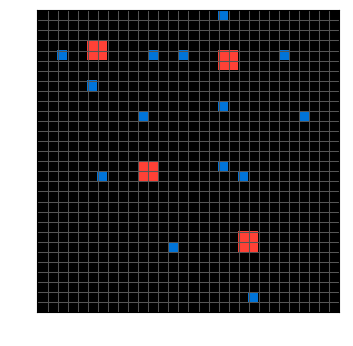

In [167]:
x, y = task.examples[0]
objs_x, objs_y = task.objects[0]
plot_grid(x)

In [ ]:
obj

In [411]:
a = objs[-2]
a.coordinates

array([[15, 10],
       [15, 11],
       [16, 10],
       [16, 11]], dtype=uint8)

In [464]:
def to_biadjacency_matrix(x):
    h, w = x.shape
    A = np.zeros((h+w, h+w))
    xt = x.T
    A[:h, -w:] = x
    A[-w:, :h] = xt
    return A


def compute_edit_distance_matrix(graphs):
    n = len(graphs)
    x_edit = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            d = nx.algorithms.similarity.graph_edit_distance(graphs[i], graphs[j])
            x_edit[i, j] = d
            x_edit[j, i] = d
    return x_edit

def compute_orthogonal_matrix(objs):
    num_objs = len(objs)
    x_ortho = np.zeros((num_objs, num_objs))
    for i in range(num_objs):
        for j in range(num_objs):
            h_ortho = np.any(np.in1d(objs[i].coordinates[:, 0], objs[j].coordinates[:, 0]))
            w_ortho = np.any(np.in1d(objs[i].coordinates[:, 1], objs[j].coordinates[:, 1]))
            x_ortho[i, j] = h_ortho or w_ortho
            x_ortho[j, i] = h_ortho or w_ortho
    
    return x_ortho
            
            
def build_local_graph(objs, d=None):
    graph = Graph()
    A
    

def build_global_graph(objs, 
                       d_min=None,
                       s_min=.0001,
                       node_states=None,
                       edge_states=None,
                       label_f=None,
                       annotation_f=None,
                       use_adj_nbrs=False,
                       sim_f=None,
                       shape=None):
    """
    Notes
    -----
    will need to add a parameter for node embeddings by structure, symbols, coordinates, etc
    """
    graph = Graph()
    
    num_objs = len(objs)
    if label_f is None:
        label_f = lambda obj: int(obj.palette[0])
    
    node_state = None
    if node_states is not None:
        x_sim = compute_similarity_matrix(node_states)
    else:
        x_sim = None
    
    x_clusters = compute_cluster_matrix(objs)
    x_ortho = compute_orthogonal_matrix(objs)
    
    ann = None
    state_sim = None
    
    idx_to_obj = {i: obj for i, obj in enumerate(objs)}
    id_to_idx = {id(v): k for k,v in idx_to_obj.items()}
    
    x_dist = compute_min_dist_matrix(objs)
    if shape is None:
        shape = np.array([1, 1], dtype=np.float32)
    else:
        shape = np.asarray(shape, dtype=np.float32)
    d_min = max(shape) if d_min is None else d_min
    
    for i, obj in enumerate(objs):
        if node_states is not None:
            node_state = node_states[i]
        if annotation_f is not None:
            ann = annotation_f(obj, shape)
            
        graph.add_node(Node(i,
                            datasource=obj, 
                            shape=obj.shape,
                            coordinate=np.array(obj.coordinate, dtype=np.float32),
                            label=obj.palette[0],
                            annotation=ann,
                            embedding=node_state,
                            h_cluster=x_clusters[i, 0],
                            w_cluster=x_clusters[i, 1]))
    
    for i, obj in enumerate(objs):
        for child_u in obj.children:
            # add a directed edge from the parent to child
            graph.add_edge(i, id_to_idx[id(child_u)], directed=True)
            # add an undirected edge between each child
            # this will need to change to allow recusion
            for child_v in obj.children:
                if child_u is not child_v:
                    graph.add_edge(id_to_idx[id(child_u)], id_to_idx[id(child_v)])
        
        if x_dist is not None:
            close_idx = np.asarray(np.where(x_dist[i] < d_min)[0], dtype=int)
            # don't filter because we may want to update priors here
            for d_i in close_idx:
                if i != d_i:
                    if sim_f is not None:
                        state_sim = sim_f(obj, idx_to_obj[int(d_i)])
                    state_dist = (graph.nodes[i].coordinate - graph.nodes[d_i].coordinate) / shape
                    graph.add_edge(i,
                                   int(d_i),
                                   state_sim=state_sim,
                                   state_dist=state_dist,
                                   orthogonal=x_ortho[i, d_i])

#         if use_adj_nbrs:
#             hc, wc = x_clusters[i]
#             for c_i in range(num_objs):
#                 d_h = abs(hc - x_clusters[c_i, 0])
#                 d_w = abs(wc - x_clusters[c_i, 1])
#                 if d_h + d_w == 1:
#                     if sim_f is not None:
#                         state_sim = sim_f(obj, idx_to_obj[int(c_i)])
#                     state_dist = (graph.nodes[i].coordinate - graph.nodes[c_i].coordinate) / shape
#                     graph.add_edge(i, 
#                                    int(c_i),
#                                    state_sim=state_sim,
#                                    state_dist=state_dist)
        
        if x_sim is not None:
            close_idx = np.where(x_sim[i] < s_min)[0]
            for s_i in close_idx:
                # if we care about adjacent neighbors check if the object is in the same cluster
                if i != s_i and (not use_adj_nbrs or any(x_clusters[i] == x_clusters[s_i])):
                    if sim_f is not None:
                        state_sim = sim_f(obj, idx_to_obj[int(s_i)])
                    state_dist = (graph.nodes[i].coordinate - graph.nodes[s_i].coordinate) / shape
                    graph.add_edge(i, 
                                   int(s_i), 
                                   state_sim=state_sim,
                                   state_dist=state_dist)
        
    return graph

In [465]:
def generate_augmentations(x, 
                           y,
                           f_pool,
                           num_samples=1,
                           augs_per_sample=1,
                           with_replacement=True,
                           **params):
    """Generates shifted samples of an input and output."""
    params = params or {}
    f_pool = f_pool.copy()
    x_augs = []
    y_augs = []
    if isinstance(augs_per_sample, int):
        augs_per_sample = np.random.choice(range(1, augs_per_sample+1), 
                                            num_samples)
    elif len(augs_per_sample) != num_samles:
        raise ValueError('Expected `augs_per_sample` == `num_samples`, '
                         f'but got {augs_per_sample}')
    
    for i in range(num_samples):
        f_sampled = np.random.choice(f_pool, augs_per_sample[i], replace=with_replacement)
        x_aug = x.copy()
        y_aug = y.copy()
        for f in f_sampled:
            f_name = f.__name__
            f_params = params.get(f_name, {}).copy()
            if f_params.get('include_y'):
                f_params.pop('include_y')
                x_aug, y_aug = f(x_aug, y_aug, **f_params)
            elif f_params.get('omit_y'):
                f_params.pop('omit_y')
                x_aug = f(x_aug, **f_params)
            else:
                x_aug = f(x_aug, **f_params)
                y_aug = f(y_aug, **f_params)
            if not with_replacement:
                f_pool.remove(f)
        
        x_augs.append(x_aug)
        y_augs.append(y_aug)
        
    return np.stack(x_augs), np.stack(y_augs)


def get_example_graphs(examples, nbrs, return_preds=True):
    x_input, y_output = examples
    input_shape = np.asarray(x_input.shape, dtype=np.float32)
    output_shape = np.asarray(y_output.shape, dtype=np.float32)
    
    nbrs_x, nbrs_y = nbrs
    if len(nbrs_x) > 1:
        coords = np.stack([o.coordinate for o in nbrs_x])
    else:
        coords = np.asarray([nbrs_x[0].coordinate])
    indices_by_position = np.lexsort((coords[:,1], coords[:,0]))
    nbrs_x = [nbrs_x[i] for i in indices_by_position]

    if len(nbrs_y) > 1:
        coords = np.stack([o.coordinate for o in nbrs_y])
    else:
        coords = np.asarray([nbrs_y[0].coordinate])
    indices_by_position = np.lexsort((coords[:,1], coords[:,0]))
    nbrs_y = [nbrs_y[i] for i in indices_by_position]

    nbrs_structured = get_structured_objects(nbrs_x + nbrs_y)
    obj_to_state = init_state_map(nbrs_structured)
    obj_state_x = np.array([obj_to_state[hash(o.structure)] for o in nbrs_x], dtype=np.float32)
    obj_state_y = np.array([obj_to_state[hash(o.structure)] for o in nbrs_y], dtype=np.float32)
    
    gx = build_global_graph(nbrs_x, 
                            node_states=obj_state_x, 
                            sim_f=edge_sim_f,
                            annotation_f=annotate_f,
                            shape=input_shape)
    gy = build_global_graph(nbrs_y,
                            node_states=obj_state_y,
                            sim_f=edge_sim_f,
                            annotation_f=annotate_f,
                            shape=output_shape)
    if return_preds:
        return gx, gy, gx.copy()
    else:
        return gx, gy

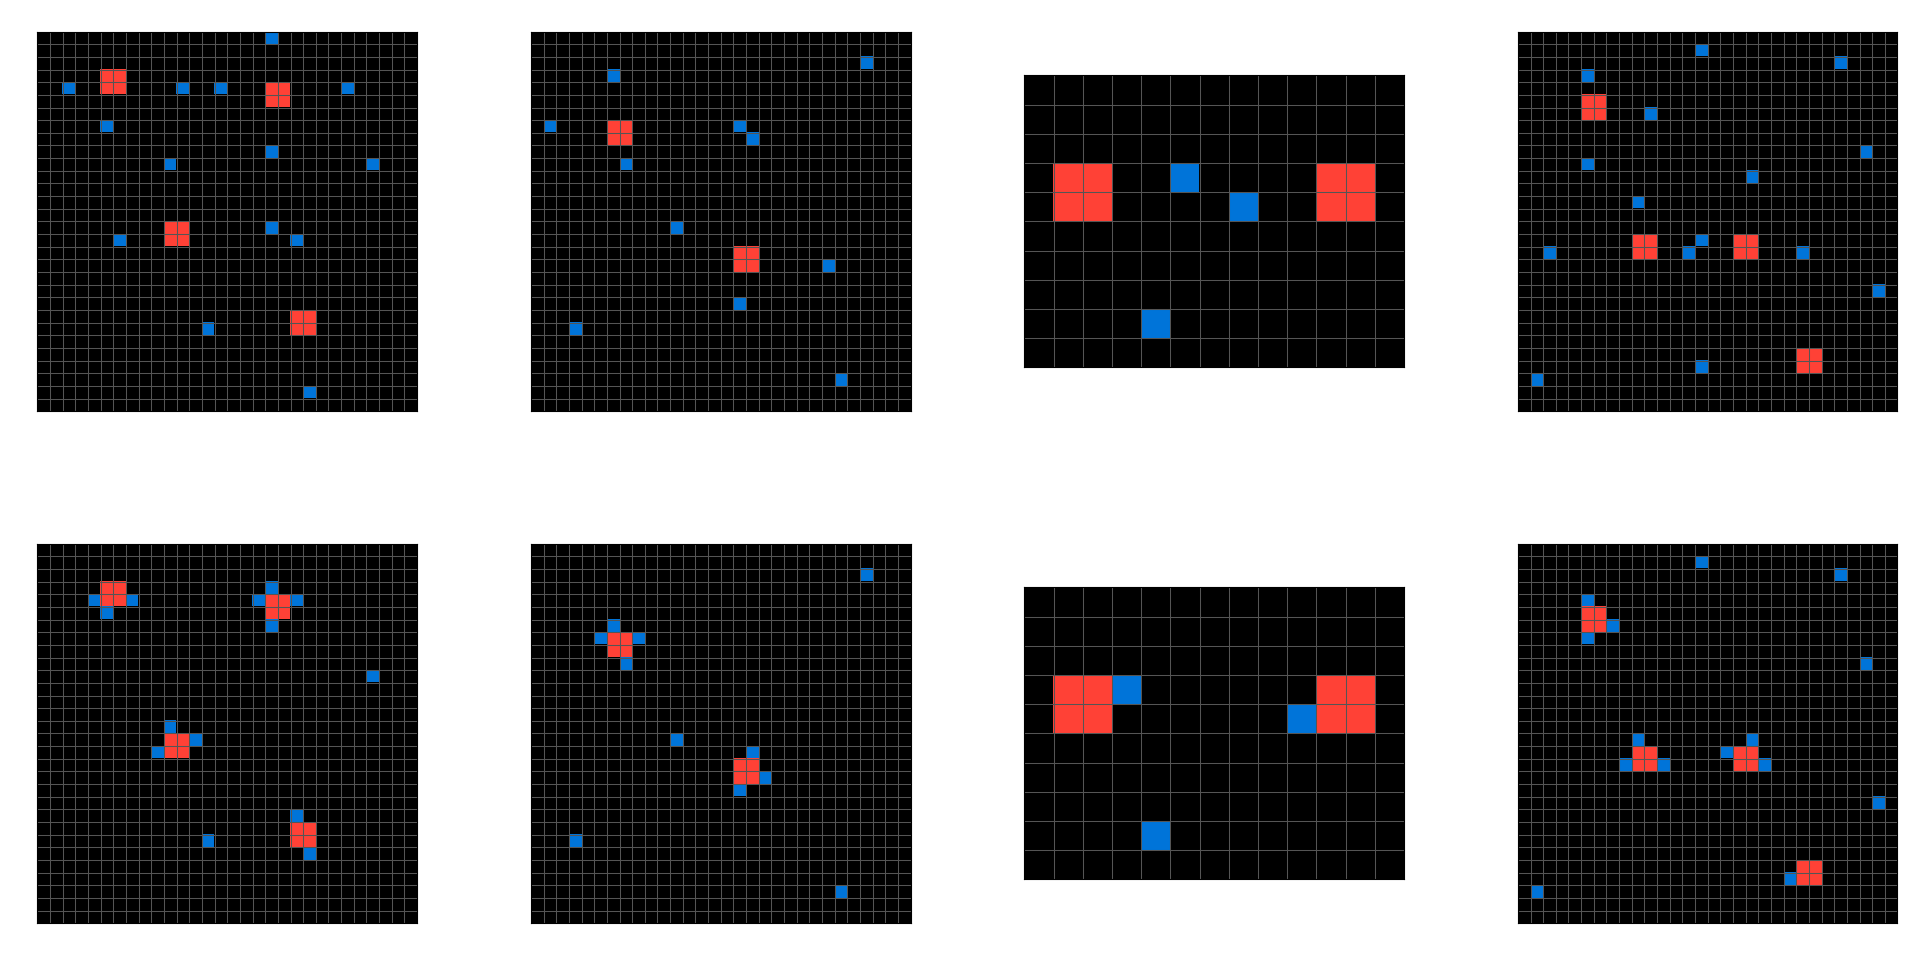

In [598]:
task = Task(id_to_filepath['e1d2900e'])
task.plot()

In [599]:
# shift/move objects
def annotate_f(obj, shape):
    return obj.coordinate / shape


def edge_sim_f(u, v):
    if u.structure == v.structure:
        return [0, 1]
    else:
        return [1, 0]

In [600]:
graph_inputs = []
graph_outputs = []
graph_preds = []
example_inputs = []
example_outputs = []

# for i in range(task.num_samples):
for example in task.example_data:
    x_input, y_output = example
    x_input = Example(x_input)
    y_output = Example(y_output)
    # i need to add logic to figure out when to use neighbors and objects..
    nbrs = [x_input.objects, y_output.objects]

    gx, gy, gp = get_example_graphs(example, nbrs, )
    graph_inputs.append(gx)
    graph_outputs.append(gy)
    graph_preds.append(gp)
    example_inputs.append(x_input)
    example_outputs.append(y_output)


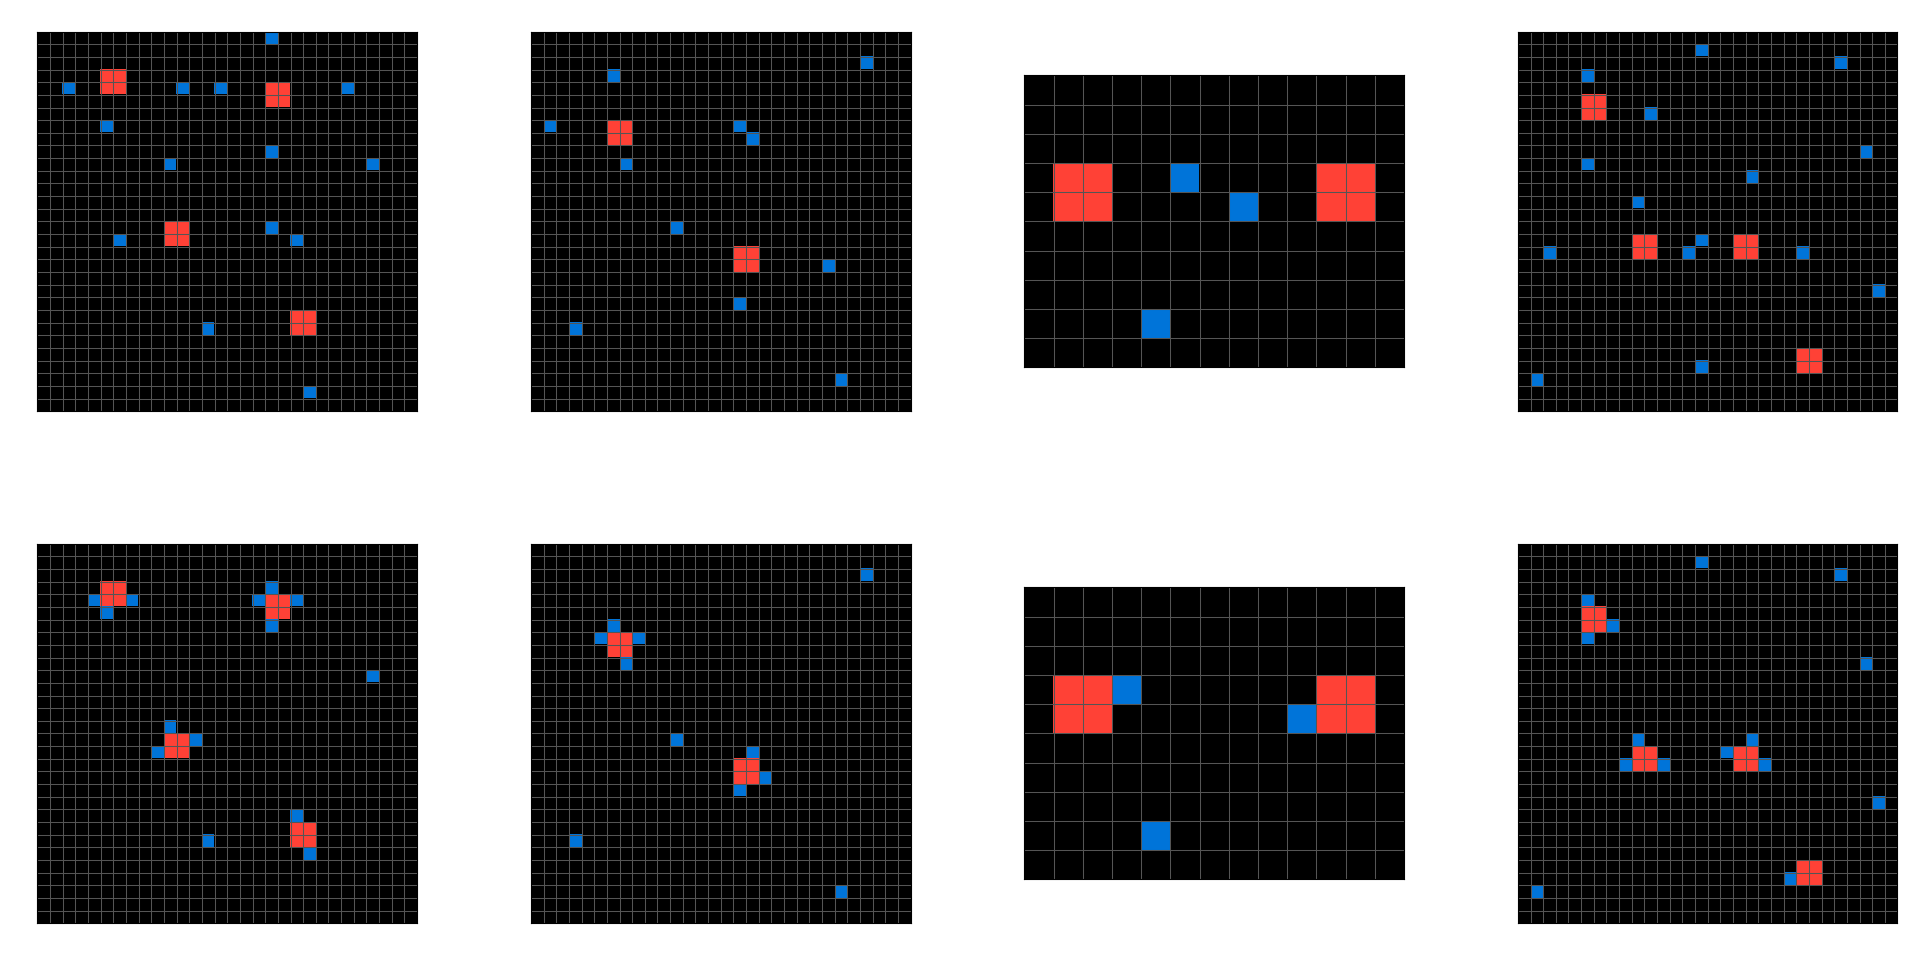

In [594]:
task.plot()

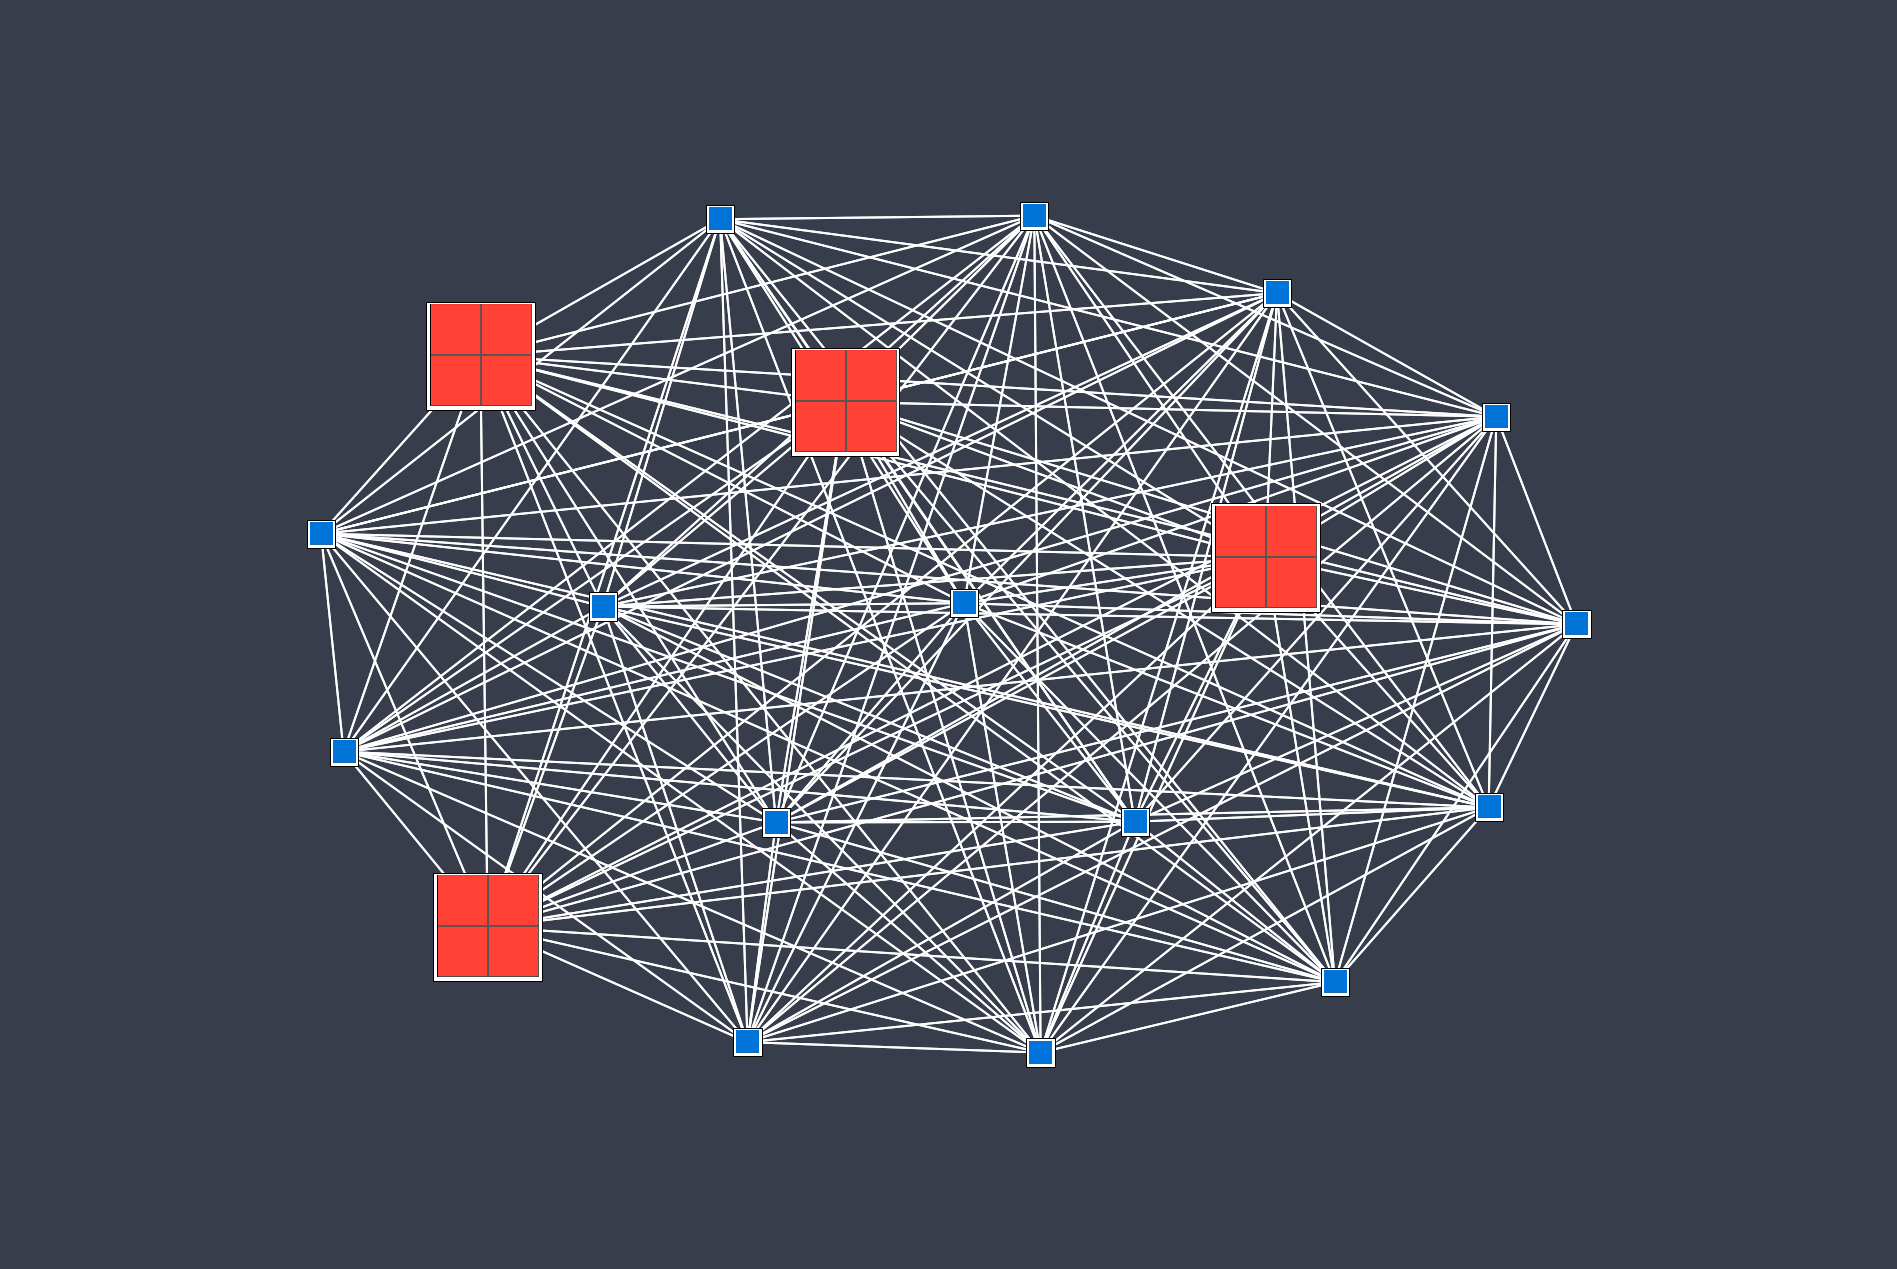

In [602]:
gx.draw()

In [269]:
# task = Task(id_to_filepath['bf699163'])
# graph_inputs = []
# graph_outputs = []
# graph_preds = []
# example_inputs = []
# example_outputs = []

# # for i in range(task.num_samples):
# for example in task.example_data:
#     x_input, y_output = example
#     x_input = Example(x_input)
#     y_output = Example(y_output)
#     nbrs = [x_input.nbrs, y_output.nbrs]

#     gx, gy, gp = get_example_graphs(example, nbrs, )
#     graph_inputs.append(gx)
#     graph_outputs.append(gy)
#     graph_preds.append(gp)
#     example_inputs.append(x_input)
#     example_outputs.append(y_output)

In [3928]:
local_graphs = []
biadj_matrices = []

for obj in nbrs:
    A = to_biadjacency_matrix(obj.data)
    biadj_matrices.append(a)
    local_graphs.append(convert_array_to_graph(A))

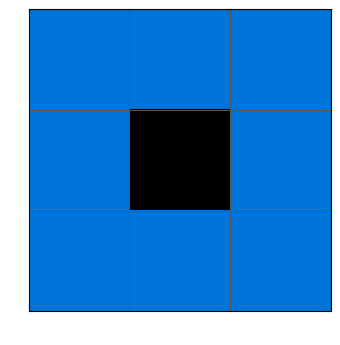

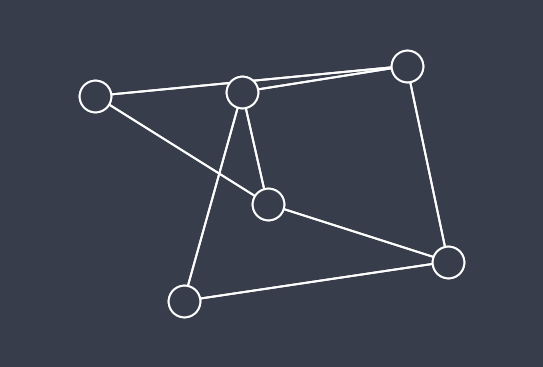

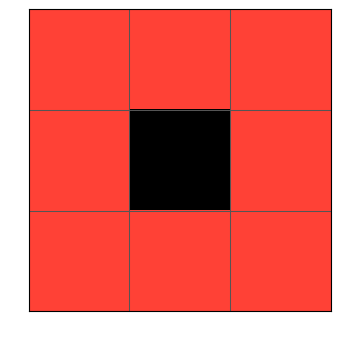

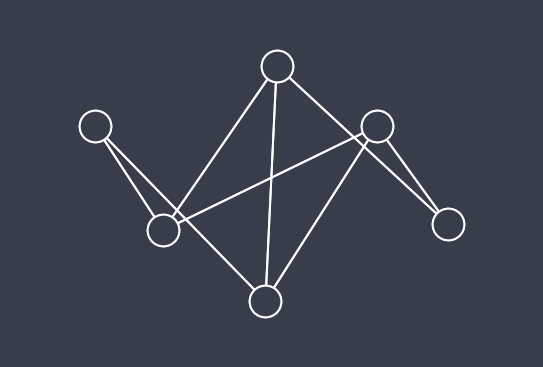

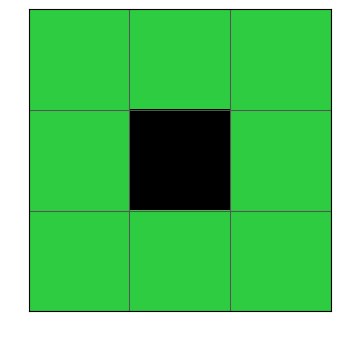

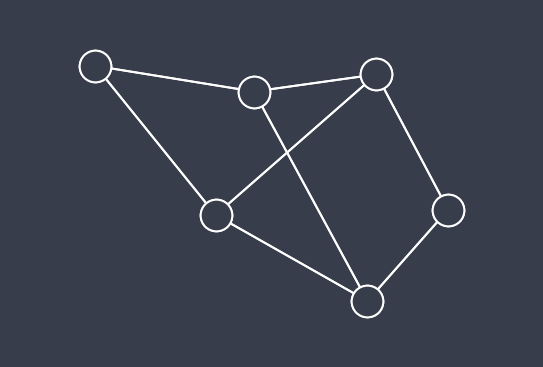

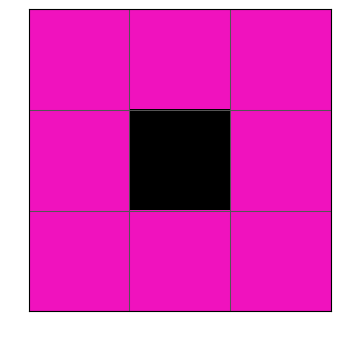

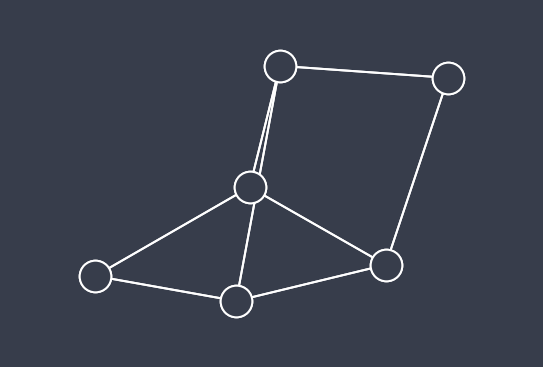

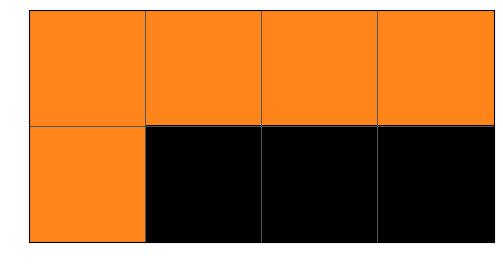

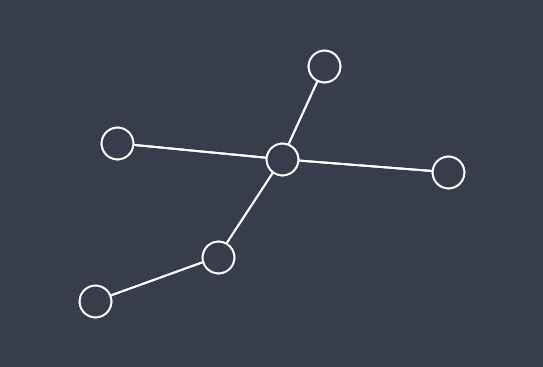

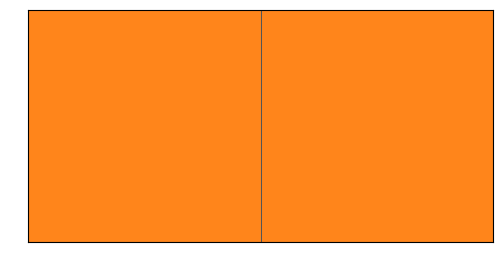

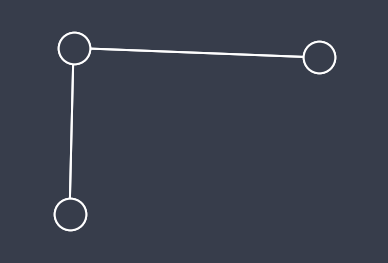

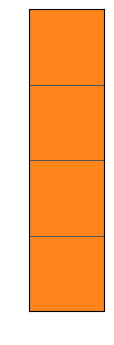

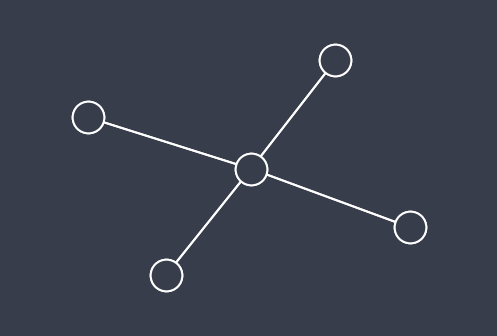

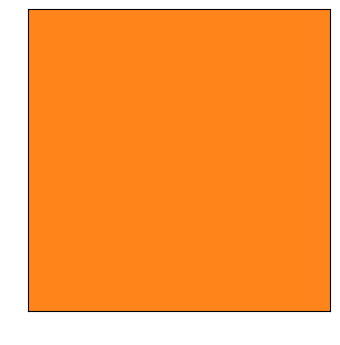

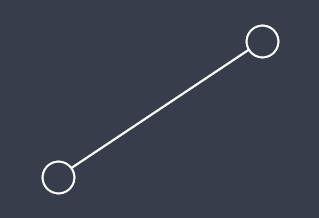

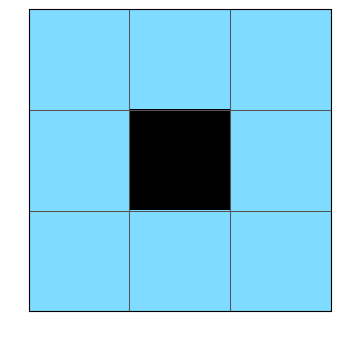

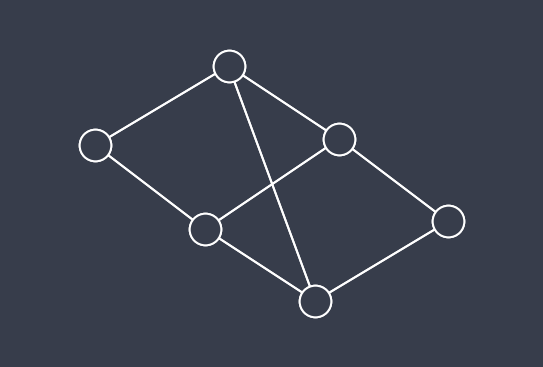

In [3939]:
for i in range(len(local_graphs)):
    nbrs[i].plot(); plt.show();
    local_graphs[i].draw(grid_scale=.5)

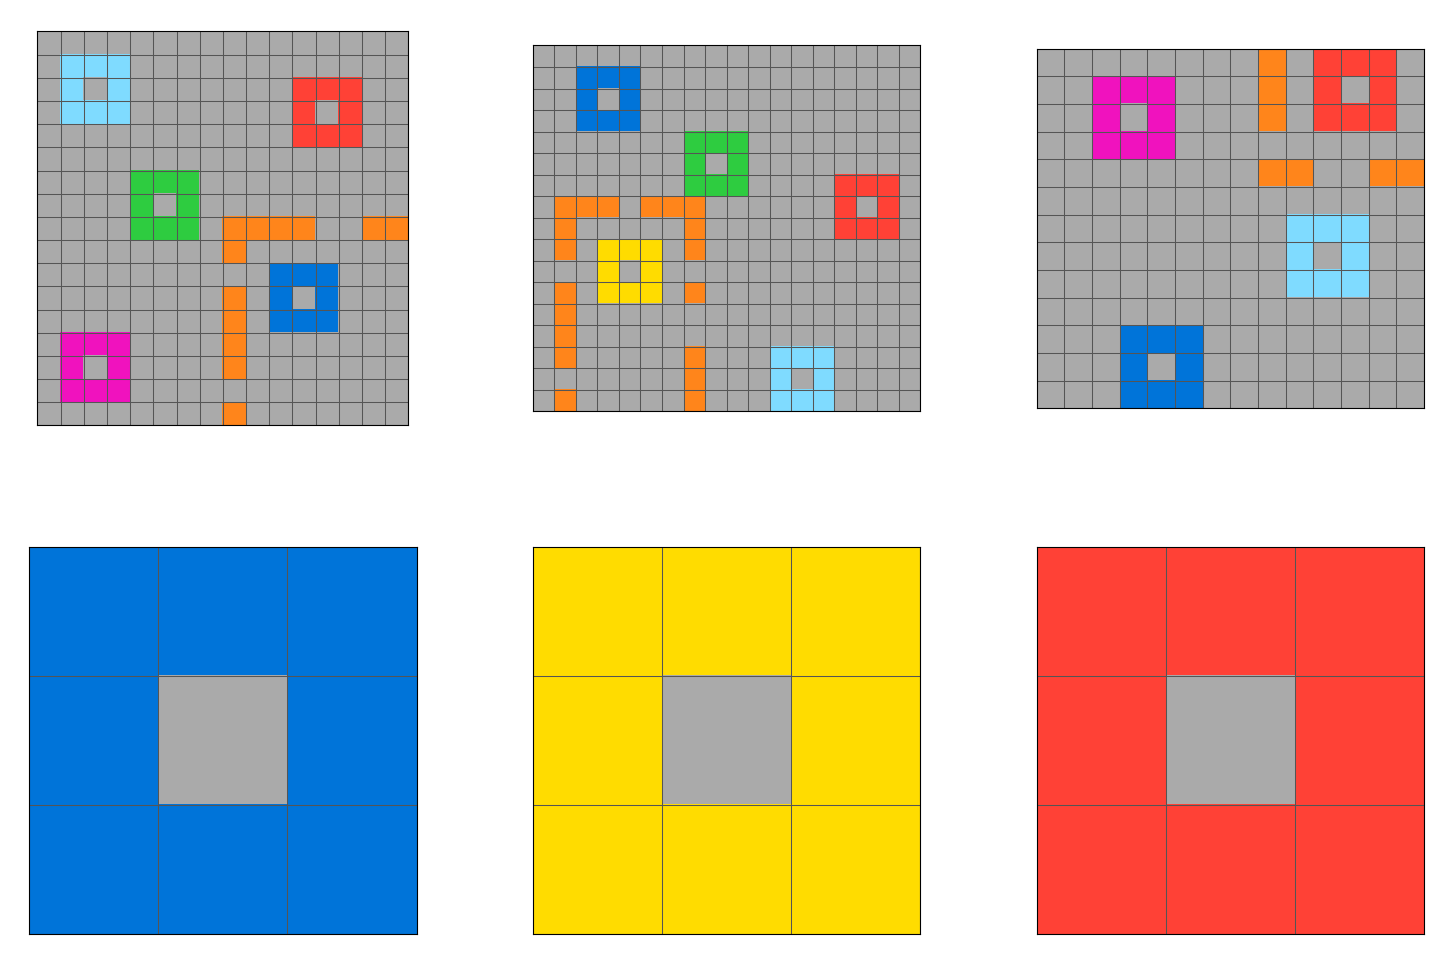

In [3914]:
task.plot()

In [471]:
def predict_shapes(task, task_type='symmetry'):
    train_input_shapes, train_output_shapes = task.train_shapes
    test_input_shapes, test_output_shapes = task.test_shapes
    if np.alltrue(train_input_shapes == train_output_shapes):
        pred_shapes = np.concatenate((train_input_shapes, test_input_shapes), axis=0)
    else:
        pass
    if task_type == 'symmetry':
        mask_symbols = get_mask_symbols(task)
        task_masks = [get_masks(x.data, mask_symbols[i]) for i, x in enumerate(task.inputs)]

        pred_shapes = []
        for example_masks in task_masks:
            if len(example_masks) == 1:
                mask = example_masks[0]
            else:
                raise ValueError('more than one mask hmmmm')
            # what about when the mask isn't a block..
            pred_shapes.append(mask.shape)
        return np.array(pred_shapes)
        
    else:
        ss = ShapeSolver()
        X = task.input_shapes
        y = task.output_shapes

        ss.fit(X, y)
        return ss.predict(X)

In [472]:
class AdapativeParam(object):
    
    def __init__(self, 
                 start_value,
                 factor=.9, 
                 update_f=None,
                 patience=5,
                 mode='min',
                 min_delta=0,
                 cooldown=0,
                 lower_bound=0,
                 upper_bound=np.inf,
                 reset=False,
                 update_params=None,
                 name=None):
        self.start_value = start_value
        self.factor = factor
        self.patience = patience
        if update_f is not None:
            self.update_f = update_f
        else:
            self.update_f = lambda v, factor: v * factor
        self.mode = mode
        self.min_delta = min_delta
        self.cooldown = cooldown
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.reset = reset
        self.name = name
        self.update_params = update_params or {}
        
        self.value = self.start_value
        self.best = None
        self.monitor_op = None
        self.current_step = 0
        self.wait = 0
        self.cooldown_counter = 0
        self.best_step = 0
        self.history = {}
        
        self._reset()
    
    def __repr__(self):
        return f'<{self.__class__.__name__} ({self.name}): {self.value}>'
    
    def __add__(self, other):
        return self.value + other
    
    def __radd__(self, other):
        return self.value + other
    
    def __mul__(self, other):
        return self.value * other
    
    def __rmul__(self, other):
        return self.value * other
    
    def __truediv__(self, other):
        return self.value / float(other)
    
    def __rtruediv__(self, other):
        return float(other) / self.value
    
    def __sub__(self, other):
        return self.value - other
    
    def __rsub__(self, other):
        return other - self.value
    
    def __pow__(self, other):
        return self.value ** other
    
    def __rpow__(self, other):
        return other ** self.value
    
    def __le__(self, other):
        return self.value <= other
    
    def __lt__(self, other):
        return self.value < other
    
    def __ge__(self, other):
        return self.value >= other
    
    def __gt__(self, other):
        return self.value > other
    
    def __eq__(self, other):
        return self.value == other
    
    def __neq__(self, other):
        return self.value != other
    
    def __hash__(self):
        return hash(self.value)
    
    def __array__(self):
        return np.array(self.value)
    
    def _reset(self):
        if self.mode not in ['min', 'max', 'auto']:
            raise ValueError( 'Expected `mode` in (min, max, auto).' 
                             f'got {self.mode}')

        if self.mode == 'max':
            self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
            self.best = -np.Inf
        else:
            self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
            self.best = np.Inf
        
        self.history['best'] = [self.best]
        self.history['best_step'] = [self.best_step]
        self.history['value'] = [self.value]
    
    def step(self, current, step=None, **kwargs):
        if step is None:
            self.current_step += 1
        
        if self.monitor_op(current, self.best):
            self.best = current
            self.best_step = self.current_step
            self.history['best'].append(self.best)
            self.history['best_step'].append(self.best_step)
            self.history['value'].append(self.value)
            
            self.wait = 0
            self.cooldown_counter = 0
        else:
            self.cooldown_counter += 1
            if self.cooldown_counter > self.cooldown:
                self.wait += 1
                if self.wait > self.patience:
                    new_value = self.update_f(self.value, 
                                              self.factor,
                                              **self.update_params,
                                              **kwargs)
                    if new_value > self.lower_bound and new_value < self.upper_bound:
                        print(f'Updating {self.name} from {self.value} to {new_value} '
                              f'at step {self.current_step}')
                        self.value = new_value
                    elif self.reset:
                        print(f'Resetting {self.name} from {self.value} to '
                              f'{self.start_value} at step {self.current_step}.')
                        self.value = self.start_value
                        
                    self.wait = 0
                    self.cooldown_counter = 0
                    

class Scheduler(Mapping):
    
    def __init__(self, params):
        self.params = params
        self.hist = {}
        
    def get_history(self):
        return self.hist
    
    def get_best(self):
        best_step = np.argmax([v['loss'] for v in self.hist.values()])
        return self.hist[best_step]['params']
        
    def __call__(self, current, step=None, **kwargs):
        self.hist[step] = {'loss': current, 'params': {}}
        for key, param in self.params.items():
            param.step(current, step, **kwargs)
            self.hist[step]['params'][key] = param.value
            
    def __len__(self):
        return len(self.params)
    
    def __getitem__(self, k):
        return self.params[k]
    
    def __iter__(self):
        return iter(self.params.items())
            
    def __repr__(self):
        _params_str = '\n\t'.join([p.__repr__() for p in self.params.values()])
        return f"<{self.__class__.__name__}: \n\t{_params_str}>"
    
    

In [473]:
################################################################################
# grid utility functions
################################################################################

NUM_CHANNELS = len(COLORS)

def grid_to_rgb(x):
    """Returns a 3D array of RGB values of an ARC grid."""
    x_rgb = np.asarray(x)
    if x_rgb.ndim == 2:
        x_rgb = x_rgb[None, ...]
    if x_rgb.ndim == 3:
        x_rgb = x_rgb[..., None]
    
    x_rgb = np.repeat(x_rgb, 3, axis=-1)
    values = np.unique(x_rgb)
    for v in values:
        x_rgb[x_rgb[:,:,:,0] == v] = idx_to_rgb[v]
    return x_rgb[0] if x_rgb.shape[0] == 1 else x_rgb


def grid_to_rgba(x):
    """Returns a 3D array of RGB values of an ARC grid."""
    x = np.asarray(x)
    a = arc_conv2d((x != background_color).astype(np.float32), 
                   kernel=np.ones((3, 3), dtype=np.float32) / 9.,
                   padding='same')
    x_rgb = grid_to_rgb(x)
    x_rgba = np.concatenate([x_rgb, np.expand_dims(a, axis=-1)], axis=-1)
    return x_rgba.astype(np.float32)


def get_alpha(x, kernel=None, background_color=0):
    """Returns a 3D array of RGB values of an ARC grid."""
    x = np.asarray(x, dtype=np.float32)
    ndim = x.ndim
    if ndim == 2:
        x = x[None, ..., None]
    if ndim == 3:
        raise ValueError(f"Expected 2 or 4 dims. Got {ndim}")
        
    if kernel is None:
        kernel = np.ones((3, 3, 1, 1)) / 9.
    else:
        kdim = kernel.ndim
        if kdim == 2:
            kernel = kernel[..., None]
        if kdim == 3:
            kernel = kernel[..., None]
    
    kernel = kernel.astype(np.float32)       
    a = tf.nn.depthwise_conv2d(x, kernel, [1,1,1,1], 'SAME').numpy()
    if ndim == 2:
        return np.clip(a[0,...,0].astype(np.float32), -1, 1.)
    else:
        return np.clip(a.astype(np.float32), -1, 1.)

def grid_to_channel(x, cmap=None, background_color=0):
    """Transforms a 2D grid of color indices to a 3D tensor where each channel
    corresponds to a color.
    """
    x = np.asarray(x)
    if cmap is None:
        cmap = {i: i for i in range(NUM_CHANNELS)}
    
    x_channels = []
    for ch, v in cmap.items():
        if v == background_color:
            x_channels.append(np.zeros_like(x, dtype=np.float32))
        else:
            x_channels.append((x == v).astype(np.float32))
    return np.stack(x_channels, axis=2)     

def channel_to_grid(x, 
                    cmap=None,
                    mask_th=0,
                    num_channels=None,
                    background_color=0):
    """Transforms a binarized 3D matrix to a 2D grid of color indices."""
    x = np.array(x)
    if cmap is None:
        cmap = {i: i for i in range(NUM_CHANNELS)}
    num_channels = len(cmap)
    
    if x.shape[-1] < num_channels + 1:
        x = np.concatenate((x, x.sum(axis=-1)[...,None]), -1)
        
    mask = x[...,-1] > mask_th

    x_grid = np.argmax(x[..., :num_channels], axis=-1)
    x_grid = np.vectorize(cmap.__getitem__)(x_grid)
    x_grid[np.where(mask == 0)] = background_color
    
    return x_grid


def unpad(x, output_shape):
    ndim = len(x.shape)
    if ndim == 2:
        h, w = x.shape
    elif ndim == 4:
        h, w = x.shape[1:3]
    else:
        raise ValueError(f"Expected 2 or 4 dims, got {x.ndim}")
    
    hp = h - output_shape[0]
    wp = w - output_shape[1]
    if hp > 0:
        hp = (hp//2, h-hp//2) if hp % 2 == 0 else (hp//2+1, h-hp//2)
    else:
        hp = (0, h)
    if wp > 0:
        wp = (wp//2, w-wp//2) if wp % 2 == 0 else (wp//2+1, w-wp//2)
    else:
        wp = (0, w)
    
    if ndim == 2:
        if isinstance(x, np.ndarray):
            return x[hp[0]:hp[1], wp[0]:wp[1]]
        elif isinstance(x, tf.Tensor):
            return tf.slice(x, [hp[0], wp[0]], [hp[1]-hp[0], wp[1]-wp[0]])
        else:
            raise ValueError(f'Unrecognized data type {type(x)}')
    else:
        if isinstance(x, np.ndarray):
            return x[:,hp[0]:hp[1], wp[0]:wp[1],:]
        elif isinstance(x, tf.Tensor):
            return tf.slice(x, 
                            begin=[0, hp[0], wp[0], 0], 
                            size=[-1, hp[1]-hp[0], wp[1]-wp[0], -1])
        else:
            raise ValueError(f'Unrecognized data type {type(x)}')

def pad(x, hp=0, wp=0, dp=0, pad_value=0):
    ndim = len(x.shape)
    if not isinstance(hp, (list, tuple)):
        hp = (hp, hp)
    if not isinstance(wp, (list, tuple)):
        wp = (wp, wp)
    if not isinstance(dp, (list, tuple)):
        dp = (dp, dp)

    if ndim == 2:
        pad_width = [hp, wp]
    elif ndim == 4:
        pad_width = [(0,0), hp, wp, dp]
    else:
        pad_width = [hp, wp, dp]
    
    if isinstance(x, np.ndarray):
        return np.pad(x, pad_width, constant_values=pad_value)
    elif isinstance(x, tf.Tensor):
        return tf.pad(x, pad_width, constant_values=pad_value)
    else:
        raise ValueError(f'Unrecognized data type {type(x)}')
        
    
def pad_grid(x, output_shape, pad_value=0.):
    h, w = x.shape[:2]
    hp = (output_shape[0] - h)
    wp = (output_shape[1] - w)

    hp = (hp//2,)*2 if hp % 2 == 0 else (hp//2+1, hp//2)
    wp = (wp//2,)*2 if wp % 2 == 0 else (wp//2+1, wp//2)

    return pad(x, hp, wp, pad_value=pad_value)


def arc_conv2d(x_input, kernel, padding='same', strides=1):
    """Slides a filter (object) across a state and checks for matches."""
    x_input = np.asarray(x_input)
    kernel_h, kernel_w = kernel.shape
    
    if padding == 'same':
        hp = kernel_h // 2
        wp = kernel_w // 2
        x_input = np.pad(x_input, [(hp, wp), (hp, wp)])
    
    x_input_1d = x_input.ravel()
    kernel_1d = np.ravel(kernel)
    
    input_h, input_w = x_input.shape
    strided_h = (input_h - kernel_h + 1) // strides
    strided_w = (input_w - kernel_w + 1) // strides
    y_output = np.zeros((strided_h, strided_w), np.float32)

    indices = project_to_1d(input_w, list(product(range(kernel_h), range(kernel_w))))

    # slide the object across every possible region and check for matches
    for i in range(strided_h):
        for j in range(strided_w):
            strided_indices = indices + j + i * input_w
            dot = np.dot(x_input_1d[strided_indices], kernel_1d)
            y_output[i, j] = np.dot(x_input_1d[strided_indices], kernel_1d)
    
    return y_output


################################################################################
# palette functions
################################################################################

def get_palette(x):
    x = np.asarray(x).ravel().tolist()
    return sorted(set(x), key=x.index)

def pal_per_example(examples):
    if examples is None:
        return [{}]
    palettes = []
    for x in examples:
        if len(x) > 0:
            palettes.append(get_palette(x))
        else:
            palettes.append([])
    return palettes

def get_cmap(palette, 
             size=None,
             continuity_symbols=None,
             spatial_symbols=None,
             background_color=0):
    cmap = {}
    ordered_palette = []
    palette = diff(palette, {background_color})
    size = len(palette) if size is None else size
    pal_size = len(palette)
    
    if continuity_symbols is not None:
        for symbol in continuity_symbols:
            if symbol not in ordered_palette:
                ordered_palette.append(symbol)
    
    if spatial_symbols is not None:
        for symbol in spatial_symbols:
            if symbol not in ordered_palette:
                ordered_palette.append(symbol)
    
    # preserves order
    oredered_palette = union(ordered_palette, palette)
    
    for i in range(size):
        if i < pal_size:
            cmap[i] = oredered_palette[i]
        else:
            cmap[i] = background_color
    
    return cmap

################################################################################
# tuning/scheduler utils
################################################################################

def log_scale(x, factor, step=None):
    return x**factor

def duration_fn(x, factor):
    return int(x**factor)

def decay_lr(lr, factor, optim, min_lr=0):
    new_lr = lr * factor
    if new_lr > min_lr:
        optim.lr.assign(new_lr)
    return new_lr


################################################################################
# evaluation functions
################################################################################

def get_pred(x, ch):
    return tf.concat([x[...,:ch], x[...,-1:]], axis=-1)

def generate_predictions(model, 
                         x,
                         cmap, 
                         target=None,
                         dropout=.5,
                         step_size=1.,
                         mask_th=.1,
                         steps=100,
                         verbose=0,
                         output_shape=None,
                         return_best=False):
    y_preds = []
    losses, accs = [], []

    for step in range(steps):
        x = model(x, dropout=dropout, step_size=step_size)
        if target is not None:
            losses.append(tf.reduce_mean(
                mean_squared_error(target, get_pred(x, len(cmap)))
            ).numpy())
            accs.append(score_ca(target, x, cmap, mask_th, output_shape))
        if verbose:
            print(f'step {step} - loss : {losses[step]:.4f} - acc : {accs[step]:.4f}')
        y_preds.append(x.numpy())
    
    if target is not None:
        best_idx = np.argmax(accs)
        if verbose:
            print(f'\nbest step - {best_idx} - acc : {accs[best_idx]:.4f} - '
                  f'loss : {losses[best_idx]:.4f}')
        if return_best:
            return y_preds[best_idx]
    
    return y_preds

In [587]:
tuple(zip(*obj.coordinates))

((7, 7, 7, 7, 7, 8, 9, 9, 9, 10, 10, 10, 10, 10, 11),
 (21, 22, 23, 24, 25, 23, 22, 23, 24, 21, 22, 23, 24, 25, 23))

In [ ]:
np.lexsort((obj.coordinates[:,1], obj.coordinates[:,0]))

In [586]:
np.lexsort(tuple(zip(*obj.coordinates)))

array([ 0,  9,  1,  6, 10,  2,  5,  7, 11, 14,  3,  8, 12,  4, 13])

In [582]:
obj.coordinates

array([[ 7, 21],
       [ 7, 22],
       [ 7, 23],
       [ 7, 24],
       [ 7, 25],
       [ 8, 23],
       [ 9, 22],
       [ 9, 23],
       [ 9, 24],
       [10, 21],
       [10, 22],
       [10, 23],
       [10, 24],
       [10, 25],
       [11, 23]], dtype=uint8)

In [579]:
np.lexsort([[0,0], [0,1], [0,3]])

array([0, 1])

In [577]:
obj.coordinates

array([[ 7, 21],
       [ 7, 22],
       [ 7, 23],
       [ 7, 24],
       [ 7, 25],
       [ 8, 23],
       [ 9, 22],
       [ 9, 23],
       [ 9, 24],
       [10, 21],
       [10, 22],
       [10, 23],
       [10, 24],
       [10, 25],
       [11, 23]], dtype=uint8)

In [592]:
from collections import defaultdict


STRUCTURE_NBR = np.ones((3, 3), np.uint8)

class Topology(object):
    
    def __init__(self, symbols, shape, coordinates=None):
        self._symbols = symbols
        self._shape = shape
        self._coordinates = coordinates
        if self._coordinates is None:
            self._data = self._symbols.reshape(self._shape).astype(np.uint8)
            self._indices = np.array(list(zip(*self._data)))
        else:
            self._coordinates = np.asarray(self._coordinates)
            self._indices = self._coordinates - self._coordinates.min(axis=0)
            self._data = np.zeros(self.shape, dtype=np.uint8)
            self._data[tuple(zip(*self._indices))] = self._symbols
        
        self._structure = self._data.astype(bool).astype(np.uint8)
        self._dtype = self._data.dtype
        
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, data):
        self._data = data
        self._symbols = data[data.nonzero()]
        self._shape = data.shape
        
    @property
    def symbols(self):
        return self._symbols
    
    @property
    def shape(self):
        return tuple(self._shape)
    
    @property
    def size(self):
        return len(self.symbols)
    
    @property
    def area(self):
        return np.prod(self.shape)
    
    @property
    def start_position(self):
        return self.coordinates.min(axis=0)
    
    @property
    def end_position(self):
        return self.coordinates.max(axis=0)
    
    @property
    def palette(self):
        """Unordered symbols."""
        return list(np.unique(self.symbols))
    
    @property
    def symbol(self):
        return '|'.join([str(x) for x in self.palette])
    
    @property
    def params(self):
        return {
            'symbols': self.symbols,
            'coordinates': self.coordinates,
            'shape': self.shape
        }
    
    def __eq__(self, other):
        if isinstance(other, (self.__class__, np.ndarray)):
            if other.shape != self.shape:
                return False
            else:
                if isinstance(other, np.ndarray):
                    return np.alltrue(other == self._data)
                else:
                    return hash(self) == hash(other)
        else:
            return False
    
    def __neq__(self, other):
        if isinstance(other, (self.__class__, np.ndarray)):
            if other.shape != self.shape:
                return True
            else:
                if isinstance(other, np.ndarray):
                    return np.any(other != self.__data)
                else:
                    return hash(self) != hash(other)
        else:
            return True
    
    def __hash__(self):
        return hash(self._data.data.tobytes())
    
    def __getitem__(self, i):
        return self._data[i]
    
    def __array__(self, **kwargs):
        return np.array(self._data, **kwargs)
    
    def __len__(self):
        return self.shape[0]
    
    def __repr__(self):
        format_str = f'<{self.__class__.__name__}: '
        format_str += f'shape={tuple(self.shape)}, '
        format_str += f'dtype={self._dtype}, '
        format_str += f'numpy=\n{self._data.__repr__()}>'
        return format_str
    
    def __str__(self):
        format_str = f'{self.__class__.__name__}('
        s = len(format_str) * ' '
        format_str += f'\n{s}'.join(str(self._data).split('\n'))
        format_str += ', '
        format_str += f'shape={tuple(self.shape)}, '
        format_str += f'dtype={self._dtype})'
        return format_str
    
    def plot(self, *args, **kwargs):
        plot_object(self.symbols, self.shape, self._coordinates, *args, **kwargs)
        
    def numpy(self):
        return self.data
    
    def copy(self):
        return self.__class__(self.symbols.copy(), self._shape, self._coordinates)
        

class Object(Topology):
    
    def __init__(self, symbols, shape, coordinates):
        super(Object, self).__init__(symbols, shape, coordinates)
        self.holes = None
        self.blobs = None
        self.children = []
        self.parent = None
        
        self.structure = Topology(self._structure, self._shape)
        self.coordinate = self._coordinates[np.lexsort(tuple(zip(*self._coordinates)))[0]]
#         self.coordinate = np.mean(self.coordinates, 0)
        
        self._set_holes()
        
    @property
    def num_children(self):
        return len(self.children)
    
    @property
    def num_holes(self):
        return len(self.holes)
    
    @property
    def num_blobs(self):
        return len(self.blobs)
    
    @property
    def coordinates(self):
        return self._coordinates

    @property
    def indices(self):
        return self._indices
    
    @property
    def sliced(self):
        idx =  tuple(zip(*(self.coordinates.min(axis=0), 
                           self.coordinates.max(axis=0)+1)))
        return (slice(*idx[0]), slice(*idx[1]))
    
    def _set_holes(self):
        holes, blobs = find_holes(self)
        self.holes = [h + self.start_position for h in holes]
        self.blobs = [b + self.start_position for b in blobs]
        
    def _set_parent(self, obj):
        if self.parent is None:
            self.parent = obj
        else:
            if obj.size < self.parent.size:
                self.parent = obj
    
    def find_children(self, objs):
        for obj in objs:
            if obj != self:
                for hole in self.blobs:
                    if len(intersection(obj.coordinates, hole)) == len(obj):
#                         if obj not in self.children:
                        self.children.append(obj)
                        obj._set_parent(self)
    

class BaseTask(object):
    
    def __init__(self):
        self.data_source = None
        self.inputs = None
        self.outputs = None
        self.examples = None
        
        self._objects = None
        self._nbrs = None
        self._symbolic_objects = None
        self.input_objects = None
        self.output_objects = None
        self.example_objects = None
        
    
        
class Palette(BaseTask):
    """Symbols (colors)."""
    
    def __init__(self):
        self.input_palettes = None
        self.output_palettes = None
        self.example_palettes = None
        self.input_palette = None
        self.output_palette = None
        self._palette = None
        self.shared_input_palette = None
        self.shared_output_palette = None
        self.input_palette_sizes = None
        self.output_palette_sizes = None
        self._distribution = None
        
        self.cmaps = None
    
    @property
    def palette(self):
        return self._palette
    
    @property
    def palette_size(self):
        return len(self._palette)
    
    @property
    def palette_sizes(self):
        return self.example_palette_sizes
    
    @property
    def new_symbols(self):
        """New colors in the output not found in the input."""
        return diff(self.train_output_palette, 
                    self.train_input_palette,
                    self.background_colors[:self.num_train])
    
    @property
    def missing_symbols(self):
        """Missing colors from the input not found in the output."""
        return diff(self.train_input_palette, 
                    self.train_output_palette, 
                    self.background_colors[:self.num_train])
    
    @property
    def max_input_palette(self):
        return max(self.input_palette_sizes)
    
    @property
    def max_output_pallete(self):
        return max(self.output_palette_sizes)
    
    @property
    def max_palette_size(self):
        return max(self.palette_sizes)
    
    @property
    def shared_palette(self):
        return intersection(self.shared_input_palette, self.shared_output_palette)
    
    def _get_background_colors(self):
        return [get_background_color(x, y) for x, y in self.examples]

    def _get_palettes(self):
        input_palettes = pal_per_example(self.inputs)
        output_palettes = pal_per_example(self.outputs)
        example_palettes = [union(input_palettes[i], output_palettes[i])
                            for i 
                            in range(len(input_palettes))]
        return input_palettes, output_palettes, example_palettes
    
    def _set_palette(self):
        self.background_colors = self._get_background_colors()
        
        self.input_palettes, self.output_palettes, self.example_palettes = self._get_palettes()
        self.train_input_palettes = self.input_palettes[:self.num_train]
        self.train_output_palettes = self.output_palettes[:self.num_train]
        self.test_input_palettes = self.input_palettes[self.num_train:]
        self.test_output_palettes = self.output_palettes[self.num_train:]

        self.input_palette = union(*self.input_palettes)
        self.output_palette = union(*self.output_palettes)
        self.train_input_palette = union(*self.train_input_palettes)
        self.train_output_palette = union(*self.train_output_palettes)
        self.test_input_palette = union(*self.test_input_palettes)
        self.test_output_palette = union(*self.test_output_palettes)
        self._palette = union(self.input_palette, self.output_palette)

        self.shared_input_palette = intersection(*self.train_input_palettes)
        self.shared_output_palette = intersection(*self.train_output_palettes)
        self.shared_example_palettes = [
            intersection(*p) for p in zip(self.train_input_palettes, self.train_output_palettes)
        ]
        self.missing_example_palettes = [
            diff(*p) for p in zip(self.train_input_palettes, self.train_output_palettes)
        ]
        self.new_example_palettes = [
            diff(*p) for p in zip(self.train_output_palettes, self.train_input_palettes)
        ]
        
        self.input_palette_sizes = list(map(len, self.train_input_palettes))
        self.output_palette_sizes = list(map(len, self.train_output_palettes))
        self.example_palette_sizes = list(map(len, self.example_palettes))
        
        self.input_markers = intersection(self.shared_input_palette, self.missing_symbols)
        self.output_markers = intersection(self.shared_output_palette, self.new_symbols)
        self._set_symbol_distributions()
        
        # color dependent symbols
        self.continuity_symbols = union(self.input_markers, 
                                        self.output_markers,
                                        self.new_symbols, 
                                        self.missing_symbols)
        # spatial dependent symbols
        self.spatial_symbols = []
        
    def _set_ordered_palettes(self):
        self.ordered_palettes = []
        # color dependent symbols
        continuity_symbols = union(self.input_markers, 
                                   self.output_markers,
                                   self.new_symbols, 
                                   self.missing_symbols)
        # spatial dependent symbols
#         contiguity_symbols = 
        
        for symbol in continuity_symbols:
            self.ordered_palette.append(symbol)
        
        for symbol in self.output_markers:
            if symbol not in self.ordered_palette:
                self.ordered_palette.append(symbol)
        
    def _set_symbol_distributions(self):
        self.input_symbol_distributions = {}
        self.output_symbol_distributions = {}
        self.input_symbol_distribution = {}
        self.output_symbol_distribution = {}
        self.example_symbol_distribution = {}
        
        for symbol in self.palette:
            input_counts = [frequency(x, symbol) for x in self.inputs]
            output_counts = [frequency(x, symbol) for x in self.outputs if len(x) > 0]
            
            self.input_symbol_distributions[symbol] = input_counts
            self.output_symbol_distributions[symbol] = output_counts
            self.input_symbol_distribution[symbol] = sum(input_counts)
            self.output_symbol_distribution[symbol] = sum(output_counts)
            
        for i, (x,y) in enumerate(self.examples):
            if y is not None:
                input_dist = [frequency(x, s) for s in self.input_palettes[i]]
                output_dist = [frequency(x, s) for s in self.output_palettes[i]]
                
        
class Shape(BaseTask):
    
    def __init__(self):
        self.input_shapes = None
        self.output_shapes = None
        self._shapes = None
        
    @property
    def shapes(self):
        return self._shapes
    
    @property
    def max_shape(self):
        return self.shapes.max(axis=0)
    
    @property
    def min_shape(self):
        return self.shapes.min(axis=0)
    
    @property
    def max_height(self):
        return self.shapes[:,0].max()
        
    @property
    def max_width(self):
        return self.shapes[:,1].max()
    
    @property
    def min_height(self):
        return self.shapes[:,0].min()
        
    @property
    def min_width(self):
        return self.shapes[:,1].min()
    
    def _set_shape(self):
        self.input_shapes = np.array([x.shape for x in self.inputs], np.uint8)
        self.output_shapes = np.array([x.shape for x in self.outputs if len(x) > 0], np.uint8)
        self._shapes = np.concatenate([self.input_shapes, self.output_shapes], 
                                      axis=0)
        if len(self.input_shapes) == len(self.output_shapes):
            self.train_shapes = [self.input_shapes[:self.num_train], self.output_shapes[:self.num_train]]
            self.test_shapes = [self.input_shapes[self.num_train:], self.output_shapes[self.num_train:]]
        else:
            self.train_shapes = [self.input_shapes[:self.num_train], self.output_shapes]
            self.test_shapes = [self.input_shapes[self.num_train:], None]

    
class Example(object):
    
    def __init__(self, datasource, set_objects=True, find_children=False):
        self._datasource = datasource
        self.set_objects = set_objects
        self._find_children = find_children
        if len(self) == 0:
            self._background_color = None
            self._shape = None
            self._palette = None
        else:
            self._background_color = get_background_color(self.datasource)
            self._shape = self.datasource.shape
            self._palette = get_palette(self.datasource)
        
        self._objects = []
        self._nbrs = []
        self._symbolic_objects = []
        
        if self.set_objects and self.datasource is not None:
            self._set_objects(find_children=self._find_children)
    
    @property
    def datasource(self):
        return self._datasource if self._datasource is not None else np.array([], np.uint8)
    
    @property
    def data(self):
        return self._datasource
    
    @property
    def objects(self):
        return self._objects
    
    @property
    def shape(self):
        return self._shape
    
    @property
    def palette(self):
        return self._palette
    
    @property
    def nbrs(self):
        return self._nbrs
    
    @property
    def symbolic_objs(self):
        return self._symbolic_objects
    
    @property
    def background_color(self):
        return self._background_color
        
    def __len__(self):
        return 0 if self.datasource is None else len(self.datasource)
    
    def __repr__(self):
        format_str = f'{self.__class__.__name__}({id(self)})'
        return format_str
    
    def __str__(self):
        return self.__repr__()
    
    def __array__(self):
        return self.datasource
    
    def __iter__(self):
        return iter(self.datasource)

    def __getitem__(self, i):
        return self.datasource[i]
    
    def __contains__(self, v):
        return v in self.datasource if self.datasource is not None else False
    
    def _set_objects(self, find_children=False):
        self._objects = get_objects(self.datasource, 
                                    background_color=self._background_color,
                                    find_children=find_children)
        self._nbrs = get_objects(self.datasource, 
                                 background_color=self._background_color,
                                 structure=STRUCTURE_NBR,
                                 find_children=find_children)
        self._symbolic_objs = get_objects(self.datasource, 
                                          background_color=self._background_color,
                                          method='symbolic',
                                          find_children=find_children)
        
    def plot(self, *args, **kwargs):
        plot_grid(self.datasource, *args, **kwargs); plt.show();
                             
    
class Task(Shape, Palette):
    
    def __init__(self, 
                 filepath=None, 
                 set_objects=True,
                 find_children=False):
        self.filepath = filepath
        self.set_objects = set_objects
        self.data_source = self._load()
        self._train = self.data_source['train']
        self._test = self.data_source['test']
        
        self.train_input, self.train_output = get_examples(self._train,
                                                           set_objects=self.set_objects,
                                                           find_children=find_children)
        self.test_input, self.test_output = get_examples(self._test,
                                                         set_objects=self.set_objects,
                                                         find_children=find_children)
        self.train = list(zip(self.train_input, self.train_output))
        self.test = list(zip(self.test_input, self.test_output))
        self._inputs = self.train_input + self.test_input
        self._outputs = self.train_output + self.test_output
        
        self.input_data = [x.data for x in self._inputs]
        self.output_data = [x.data for x in self._outputs]
        
        self._id = self.filepath.split('/')[-1].split('.json')[0]
        self.name = self._id
        self.num_samples = len(self.inputs)
        self.num_train = len(self.train)
        self.num_test = len(self.test)
        self.examples = self.train + self.test
        self.example_data = []
        for example in self.examples:
            if len(example) == 2:
                self.example_data.append((example[0].data, example[1].data))
            else:
                self.example_data.append((example[0].data))
        
        self._set_shape()
        self._set_palette()
        if self.set_objects:
            self._set_objects()
        self._set_cmaps()
        
    @property
    def task_id(self):
        return self._id
    
    @property
    def inputs(self):
        return self._inputs
    
    @property
    def outputs(self):
        return self._outputs
    
    @property
    def num_channels(self):
        return self.max_palette_size - 1
    
    @property
    def objects(self):
        return self._objects
    
    @property
    def exmaple_objects(self):
        return self._example_objects
    
    @property
    def num_objects(self):
        pass
    
    @property
    def nbrs(self):
        return self._nbrs
    
    @property
    def symbolic_objects(self):
        return self._symbolic_objects
    
    @property
    def input_objects(self):
        return self._input_objects
    
    @property
    def output_objects(self):
        return self._output_objects
    
    @property
    def input_symbol_to_objects(self):
        return self._input_symbol_to_objects
    
    @property
    def output_symbol_to_objects(self):
        return self._output_symbol_to_objects
    
    @property
    def mode(self):
        return self._mode
    
    def __repr__(self):
        return f'<Task: {self._id}>'
    
    def __len__(self):
        return self.num_samples
    
    def _load(self):
        return load_task(self.filepath)
    
    def _set_objects(self):
        self._objects = []
        self._example_objects = []
        self._input_objects = []
        self._output_objects = []
        self._object_hash = {}
        # only add unique objects to avoid duplicates
        self._input_symbol_to_objects = defaultdict(set)
        self._output_symbol_to_objects = defaultdict(set)
        
        self._nbrs = []
        self._symbolic_objects = []
        
        for i, example in enumerate(self.examples):
            self._input_objects.append(example[0].objects)
            nbrs = [example[0].nbrs]
            symbolic_objs = [example[0].symbolic_objs]
            
            for obj in self._input_objects[i]:
                self._input_symbol_to_objects[obj.symbol].add(obj)
            
            if len(example) == 2:
                self._output_objects.append(example[1].objects)
                objects = [self._input_objects[i], self._output_objects[i]]
                for obj in self._output_objects[i]:
                    self._output_symbol_to_objects[obj.symbol].add(obj)
                nbrs.append(example[1].nbrs)
                symbolic_objs.append(example[1].symbolic_objs)
            else:
                objects = [self._input_objects[i]]
            
#             self._objects = union(self._objects, *objects)
            self._objects.append(objects)
            self._example_objects.append(objects)
            self._object_hash.update({hash(obj): obj for ex in objects for obj in ex})
            self._nbrs.append(nbrs)
            self._symbolic_objects.append(symbolic_objs)
            
        self.shared_input_objects = intersection(*self._input_objects[:self.num_train])
        self.shared_output_objects = intersection(*self._output_objects[:self.num_train])
        self.shared_example_objects = [intersection(self._input_objects[i], self._output_objects[i]) for i in range(self.num_train)]
        
    def _set_cmaps(self):
        self.cmaps = []
        for i in range(self.num_samples):
            self.cmaps.append(get_cmap(self.example_palettes[i], 
                                       self.num_channels,
                                       continuity_symbols=self.continuity_symbols,
                                       spatial_symbols=self.spatial_symbols,
                                       background_color=self.background_colors[i]))
    
    def plot(self):
        plot_task(self.data_source)
        plt.show()

In [475]:
def compute_freq(u, v, method='cosine'):
    d = getattr(distance, method)
    symbols = range(NUM_SYMBOLS) if symbols is None else symbols
    d(compute_symbol_freq())
    
    
def compute_symbol_freq(x, symbols=None, normalize=False):
    symbols = range(NUM_SYMBOLS) if symbols is None else symbols
    x_symbols = np.ravel(x).tolist()
    x_freq = np.array([x_symbols.count(s) for s in symbols], dtype=np.float32)
    if normalize:
        return x_freq / sum(x_freq)
    else:
        return x_freq
    
    
def compute_freq_matrix(objs, method='cosine', symbols=None, normalize=False):
    d = getattr(distance, method)
    symbols = range(NUM_SYMBOLS) if symbols is None else symbols
    num_objs = len(objs)
    x_freq = np.zeros((num_objs, num_objs), dtype=np.float32)
    for i in range(num_objs):
        for j in range(num_objs):
            x_freq[i, j] = d(compute_symbol_freq(objs[i].data, symbols=symbols, normalize=normalize),
                             compute_symbol_freq(objs[j].data, symbols=symbols, normalize=normalize))
    return x_freq


def euclidean_distance_matrix(x, y):
    """Computes the euclidean distance between 2 matrices of coordinates."""
    x = np.asarray(x)[:, None, :]
    y = np.asarray(y)[None, ...]
    return np.sqrt(np.sum((x-y)**2, axis=-1))

def compute_distance_matrix(objs, method='euclidean'):
    x_coords = [obj.coordinate for obj in objs]
    if method == 'euclidean':
        return euclidean_distance_matrix(x_coords, x_coords)
    else:
        raise ValueError(f'Unrecognized method {method}.')
        
def compute_similarity_matrix(x, method='euclidean'):
    if method == 'euclidean':
        return euclidean_distance_matrix(x, x)
    else:
        raise ValueError(f'Unrecognized method {method}.')

def compute_distance(u, v, methods=None, fns=None):
    if methods is None:
        methods = ['euclidean', 'hamming', 'cosine']
    if fns is None:
        fns = [identity, rot90, flip_x, transpose]
    
    if isinstance(u, Object):
        u = u.data
    if isinstance(v, Object):
        v = v.data
    u = u.astype(bool).astype(np.float32)
    v = v.astype(bool).astype(np.float32)
    sims = []
    for method in methods:
        x_sim = compute_sim_matrix([u, v], method, fns=fns)[0,1]
        sims.append(x_sim)
    return np.mean(sims)


def sim_conv(x, y, kernel_shape=(2,2), strides=None, method='cosine'):
    d = getattr(distance, method)
    h_max, w_max = np.asarray(np.max([x.shape, y.shape], axis=0), int)
    h_max = h_max if h_max % 2 == 0 else h_max + 1
    w_max = w_max if w_max % 2 == 0 else w_max + 1
        
    hp, wp = h_max - x.shape[0], w_max - x.shape[1]
    hp = (hp//2, hp//2) if hp % 2 == 0 else ((hp+1) // 2, hp // 2)
    wp = (wp//2, wp//2) if wp % 2 == 0 else ((wp+1) // 2, wp // 2)
    x = pad(x, hp, wp)
    
    hp, wp = h_max - y.shape[0], w_max - y.shape[1]
    hp = (hp//2, hp//2) if hp % 2 == 0 else ((hp+1) // 2, hp // 2)
    wp = (wp//2, wp//2) if wp % 2 == 0 else ((wp+1) // 2, wp // 2)
    y = pad(y, hp, wp)
    
    h, w = x.shape
    kh, kw = (h_max//2, w_max//2) if kernel_shape is None else kernel_shape
    if strides is None:
        sh, sw = kh, kw
    elif isinstance(strides, int):
        sh, sw = (strides, strides)
    else:
        sh, sw = strides
    strided_h = int(np.ceil((h - kh + 1) / sh))
    strided_w = int(np.ceil((w - kw + 1) / sw))
    
    sims = []
    for i in range(strided_h):
        for j in range(strided_w):
#             print(x[i+i*(sh-1):i+kh+i*(sh-1), j+j*(sw-1):j+kw+j*(sw-1)])
            v = d(x[i+i*(sh-1):i+kh+i*(sh-1), j+j*(sw-1):j+kw+j*(sw-1)].ravel(), 
                  y[i+i*(sh-1):i+kh+i*(sh-1), j+j*(sw-1):j+kw+j*(sw-1)].ravel())
#             print(v)
            sims.append(0. if np.isnan(v) else v)
#             sims.append(d(x[i:i+kh, j:j+kw].ravel(), y[i:i+kh, j:j+kw].ravel()))
    return sims


def compute_sim_matrix(objs, method='euclidean', kernel_shape=None, strides=None, fns=None):
    d = getattr(distance, method)
    fns = [identity] if fns is None else fns
    num_objs = len(objs)
    sim_matrices = []
    objs = [obj.astype(bool).astype(np.float32) for obj in objs]
    
    x_sim = np.zeros((num_objs, num_objs), dtype=np.float32)
    for i in range(num_objs):
        for j in range(num_objs):
            pair_scores = []
            for f in fns:
                pair_scores.append(np.mean(sim_conv(objs[i], 
                                                    f(objs[j]),
                                                    method=method,
                                                    kernel_shape=kernel_shape, 
                                                    strides=strides)))
            x_sim[i, j] = np.mean(pair_scores)
#             x_sim[i, j] = d(objs_padded[i].ravel(), objs_padded[j].ravel())
#     sim_matrices.append(x_sim)
    
    return x_sim # np.mean(sim_matrices, axis=0)

def compute_ged(g1, g2):
    return nx.graph_edit_distance(g1, g2)

def compute_ged_matrix(graphs):
    num_graphs = len(graphs)
    
    x_ged = np.zeros((num_graphs, num_graphs), dtype=np.float32)
    
    for i in range(num_graphs):
        for j in range(num_graphs):
            x_ged[i,j] = compute_ged(graphs[i], graphs[j])
    return x_ged


In [476]:
################################################################################
# graph utils
################################################################################

def recursive_update(graph, nbrs, V, E, state=1):
    for v, e in nbrs.items():
        V.add_node(graph.get_node(v).copy())
        E.add_edge(*e.nodes, **e)
        v_nbrs = graph.adj[v]
        if state > 0:
            recursive_update(graph, v_nbrs, V, E, state-1)
            
            
def convert_array_to_graph(A, parallel_edges=False, create_using=None):
    """Returns a graph from numpy matrix."""
    A = np.asarray(A)
    h, w = A.shape
    if h != w:
        raise ValueError(f'Expected square matrix, got ({h}, {w})')
    
    graph = Graph()
    graph.add_nodes(list(range(h)))
    edges = zip(*A.nonzero())
    edges = [(u, v) for u, v in edges]
    graph.add_edges(edges)
    
    return graph

In [477]:
################################################################################
# nodes
################################################################################

from collections.abc import Mapping, Set

class Node(Mapping):
    """Node base class to represent a random variable in the graph."""
    
    def __init__(self, 
                 name,
                 datasource=None,
                 embedding=None,
                 weight=None,
                 label=None,
                 **kwargs):
        self._name = name
        self.datasource = datasource
        self.embedding = embedding
        self.weight = weight
        self.label = label
        self._indegree = 0
        self._outdegree = 0
        self._selfloops = 0
        self.__dict__.update(kwargs)
        
        self._id = id(self.datasource)
        self._fname = None
        self._img = None
        self._format = 'png'
        
        self._set_img()
        
    @property
    def name(self):
        return self._name
    
    @name.setter
    def name(self, name):
        self._name = name
        self._save_obj()
        
    @property
    def params(self):
        return {
            k: v for k, v in self.__dict__.items() 
            if not k.startswith('_')
            and v is not None
        }
    
    @property
    def img(self):
        return self._img
    
    @img.setter
    def img(self, img):
        self._img = img
        
    @property
    def indegree(self):
        return self._indegree
    
    @indegree.setter
    def indegree(self, d):
        self._indegree = d
        if self._indegree < 0:
            raise ValueError('`indegree` cannot have a negative degree.')
        
    @property
    def outdegree(self):
        return self._outdegree
    
    @outdegree.setter
    def outdegree(self, d):
        self._outdegree = d
        if self._outdegree < 0:
            raise ValueError('`outdegree` cannot have a negative degree.')
            
    @property
    def data(self):
        return self.datasource
    
    @data.setter
    def data(self, datasource):
        self.datasource = datasource
        self._set_img()
    
    @property
    def selfloops(self):
        return self._selfloops
    
    @selfloops.setter
    def selfloops(self, d):
        self._selfloops += d
        
    @property
    def fname(self):
        return self._fname

    @fname.setter
    def fname(self, fname):
        self._fname = fname
    
    def __getitem__(self, k):
        return self.__dict__[k]
    
    def __len__(self):
        return len(self.params)
    
    def __iter__(self):
        return iter(self.params.keys())
    
    def __repr__(self):
        format_str = f'{self.__class__.__name__}(\n'
        format_str += f'    name: {self.name}\n'
        for k, v in self.params.items():
            s = (len(str(k))+2) * ' '
            v_str = f"\n\t{s}".join(repr(v).split('\n'))
            format_str += f'\t{k}: {v_str}\n'
        format_str += ')'
        return format_str
    
    def __str__(self):
        return f'{self.__class__.__name__}({self.name})'
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.name == other.name
        else:
            return self.name == other
    
    def __neq__(self, other):
        if isinstance(other, self.__class__):
            return self.name != other.name
        else:
            return self.name != other
        
    def __hash__(self):
        return hash(self.name)
    
    def _set_img(self):
        if self.is_obj():
            self._fname = os.path.join('/tmp', f'{self.name}.{self._format}')
            save_obj(self._fname, self.datasource, lw=4)
            self._img = plt.imread(self._fname, format=self._format)
            
    def get(self, k, default=None):
        try:
            return self.__dict__[k]
        except KeyError:
            return default
        
    def update(self, other=None, **kwargs):
        if other is not None:
            self.__dict__.update(other.params)
        self.__dict__.update(kwargs)
        self._set_img()
        
    def is_sink(self):
        return self._outdegree == 0
    
    def is_source(self):
        return self._indegree == 0
    
    def is_obj(self):
        return isinstance(self.datasource, Object)
    
    def copy(self):
        """Meta features like degree, will not be passed to the copy."""
        return Node(self._name, **{k: v for k, v in self.items()})
    

class Nodes(Set, Mapping):
    """Node base class to represent a random variable in the graph."""

    def __init__(self, nodes=None):
        super(Nodes, self).__init__()
        self._nodes = {}
        self.update(nodes)
        
    @property
    def names(self):
        return [u.name for u in self]
    
    def __len__(self):
        return len(self._nodes)

    def __iter__(self):
        return iter(self._nodes.values())

    def __getitem__(self, u):
        if isinstance(u, Node):
            return self._nodes[u.name]
        else:
            return self._nodes[u]
    
    def __contains__(self, u):
        return u in self._nodes

    def __str__(self):
        return self.__repr__()
    
    def __hash__(self):
        return id(self)
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            if len(self) == len(other):
                return len(set(self._nodes) & set(other._nodes)) == len(self)
            else:
                False
        else:
            False
            
    def __neq__(self, other):
        if isinstance(other, self.__class__):
            if len(self) == len(other):
                return len(set(self._nodes) & set(other._nodes)) != len(self)
            else:
                True
        else:
            True
            
    def __and__(self, other):
        return Nodes([u for u in set(other) if u in self])
    
    def __or__(self, other):
        return Nodes(list(self) + [u for u in set(other) if u not in self])
    
    def __sub__(self, other):
        return Nodes([u for u in self if u not in set(other)])

    def __repr__(self):
        format_str = f'{self.__class__.__name__}('
        format_str += ', '.join([str(name) for name in self._nodes.keys()])
        format_str += ')'
        return format_str

    def add_node(self, u, **kwargs):
        if isinstance(u, Node):
            if u in self._nodes:
                self._nodes[u.name].update(u, **kwargs)
            else:
                self._nodes[u.name] = u
        else:
            if u in self._nodes:
                self._nodes[u].update(**kwargs)
            else:
                self._nodes[u] = Node(u, **kwargs)
    
    def update(self, nodes):
        if isinstance(nodes, (tuple, list)):
            for u in nodes:
#                 if not isinstance(u, Node):
#                     raise ValueError(f'Expected node {u} to be of type `Node`, got {type(u)}')
                self.add_node(u)
        elif isinstance(nodes, dict):
            self._nodes.update(nodes)
        elif isinstance(nodes, self.__class__):
            self._nodes.update(nodes._nodes)
        elif isinstance(nodes, Node):
            self.add_node(nodes)
            
    def remove(self, u):
        try:
            if isinstance(u, Node):
                del self._nodes[u.name]
            else:
                del self._nodes[u]
        except KeyError: 
            raise KeyError(f"Node {u} is not in the set.")
            
    def intersection(self, other):
        return self.__and__(other)
    
    def union(self, other):
        return self.__or__(other)

    def difference(self, other):
        return self.__sub__(other)
    
    def get(self, u, default=None):
        try:
            return self[u]
        except KeyError:
            return default

    def copy(self):
        return Nodes([u.copy() for u in self])
    
    def sort(self):
        return iter([self[i] for i in sorted(self.names)])
    
    
def get_edge_data(e):
    if isinstance(e, Edge):
        return (*e.nodes, e.params)
    if len(e) == 2:
        return (*e, {})
    if len(e) == 3:
        return e
    else:
        raise ValueError('Expected an Edge or tuple/list of size 2 or 3, '
                        f'got {e}')

################################################################################
# edges
################################################################################
        
class Edge(Mapping):
    
    def __init__(self, 
                 u,
                 v,
                 directed=None,
                 distance=None,
                 embedding=None,
                 **kwargs):
        self._u = u if isinstance(u, Node) else Node(u)
        self._v = v if isinstance(u, Node) else Node(v)
        self.directed = directed
        self.distance = distance
        self.embedding = embedding
        self.__dict__.update(kwargs)
        
        self._nodes = (self._u, self._v)
        self._vertices = (self._u.name, self._v.name)
        self._name = f'{self._u.name}-{self._v.name}'

    @property
    def params(self):
        return {
            k: v for k, v in self.__dict__.items() 
            if not k.startswith('_')
            and v is not None
        }
    
    @property
    def vertices(self):
        return self._vertices
    
    @property
    def nodes(self):
        return self._nodes
    
    @property
    def head(self):
        return self._u
    
    @property
    def tail(self):
        return self._v
    
    def __getitem__(self, s):
        if isinstance(s, (int, slice)):
            return self.nodes[s]
        return self.__dict__[s]
    
    def __len__(self):
        return len(self.params)
    
    def __iter__(self):
        return iter(self.params.keys())
    
    def __repr__(self):
        format_str = f'{self.__class__.__name__}('
        format_str += f'\n    vertices: ({self._u.name}, {self._v.name})\n'
        for k, v in self.params.items():
            s = (len(str(k))+2) * ' '
            v_str = f"\n\t{s}".join(repr(v).split('\n'))
            format_str += f'\t{k}: {v_str}\n'
        format_str += ')'
        return format_str
    
    def __str__(self):
        format_str = f'{self.__class__.__name__}({self._u.name}, {self._v.name}'
        if self.directed:
            format_str += f', directed={self.directed})'
        else:
            format_str += ')'
        return format_str
    
    def update(self, other=None, **kwargs):
        if other is not None:
            self.__dict__.update(other.params)
        self.__dict__.update(kwargs)
        
    def copy(self):
        """Meta features like degree, will not be passed to the copy."""
        return Edge(self._u, self._v, **{k: v for k, v in self.items()})
        
        
class Edges(object):
    
    def __init__(self, edges=None):
        self._edges = []
        self._adj = {}
        self._history = []
        
        self.update(edges)
        
    @property
    def adj(self):
        return self._adj
        
    def __len__(self):
        return len(self._edges)
        num_nbrs = (len(nbrs) + (n in nbrs) for n, nbrs in self._adj.items())
        return sum(num_nbrs) // 2

    def __iter__(self):
        for u, nbrs in self._adj.items():
            for v in nbrs:
                yield self[u, v]

    def __contains__(self, e):
        try:
            u, v, _ = get_edge_data(e)
            return v in self._adj[u]
        except KeyError:
            return False

    def __getitem__(self, e):
        if isinstance(e, (int, str)):
            return self._adj[e]
        elif isinstance(e, Node):
            return self._adj[e.name]
        u, v, _ = get_edge_data(e)
        return self._adj[u][v]
    
    def __str__(self):
        format_str = f'{self.__class__.__name__}('
        format_str += ',\n      '.join([str(e) for e in self._edges])
        format_str += ')'
        return format_str

    def __repr__(self):
        format_str = f'{self.__class__.__name__}('
        format_str += ',\n      '.join([str(e) for e in self._edges])
        format_str += ')'
        return format_str

    def update(self, edges):
        if isinstance(edges, (tuple, list)):
            for e in edges:
                u, v, attr = get_edge_data(e)
                self.add_edge(u, v, **attr)
        elif isinstance(edges, dict):
            print('unstable')
            self.update(edges)
        elif isinstance(edges, self.__class__):
            self.update(edges._edges)
        elif isinstance(edges, Edge):
            u, v, attr = get_edge_data(edges)
            self.add_edge(u, v, **attr)
            
    def add_edge(self, u, v, directed=None, **kwargs):
        u = u if isinstance(u, Node) else Node(u)
        v = v if isinstance(v, Node) else Node(v)
        u_name, v_name = u.name, v.name
        
        # if `u` is not already in the set of adjacent edges add it
        if u_name not in self._adj:
            self._adj[u_name] = {}
            
        params = {
            **self._adj[u_name].get(v_name, {}), 
            **kwargs,
            'directed': directed
        }
        edge = Edge(u, v, **params)
        if (u_name, v_name) not in self._history:
            self._edges.append(edge)
            self._history.append((u_name, v_name))
            if directed:
                u.outdegree += 1
                v.indegree += 1
        if u_name == v_name:
            u.selfloops += 1
        
        self._adj[u_name][v_name] = edge
        
        if not directed:
            if v_name not in self._adj:
                self._adj[v_name] = {}
            # what if i don't want to update the parameters here...
            params_r = {
                **self._adj[v_name].get(u_name, {}), 
                **kwargs,
                'directed': directed
            }
            edge_r = Edge(v, u, **params_r)
            if u_name not in self._adj[v_name]:
                self._adj[v_name][u_name] = edge_r
            if (v_name, u_name) not in self._history:
                self._edges.append(edge_r)
                self._history.append((v_name, u_name))
            
            
    def remove(self, e):
        try:
#             if isinstance(e, (int, str)):
#                 del self._adj[e]
#             elif isinstance(e, Node):
#                 del self._adj[e.name]
#             else:
#             is_directed = e.get('directed')
            u, v, _ = get_edge_data(e)
            del self._adj[u][v]
            if u != v:
                del self._adj[v][u]
        except KeyError: 
            raise KeyError(f"Node {u} is not in the set.")
        
        u.outdegree -= 1
        v.indegree -= 1
            
    def get(self, u, default=None):
        try:
            return self[u]
        except:
            return default
        
    def copy(self):
        return Edges([e.copy() for e in self])

In [478]:

class Graph:
    """Graph base claas.
    """
    def __init__(self, graph=None, nodes=None, edges=None, **kwargs):
        self.graph = {}
        self._nodes = Nodes(nodes)
        self._edges = Edges(edges)
        # attempt to load graph with data
        if graph is not None:
            print('unstable')
            self._nodes.update(graph.nodes)
            self._edges.update(graph.edges)
#             convert.to_networkx_graph(incoming_graph_data, create_using=self)
        self.graph.update(kwargs)

    @property
    def name(self):
        """Represents the name of the graph."""
        return self.graph.get('name', str(id(self)))
    
    @name.setter
    def name(self, s):
        self.graph['name'] = s
        
    @property
    def nodes(self):
        return self._nodes
    
    @property
    def edges(self):
        return self._edges
    
    @property
    def order(self):
        """Returns the number of nodes in the graph."""
        return len(self._nodes)
    
    @property
    def adj(self):
        """Returns an iterator over each node and their neighbors."""
        return {**{u.name: {} for u in self.nodes}, **self._edges.adj}
    
    @property
    def degree(self):
        """Returns the number of edges that flow through each node."""
        d = {u.name: 0 for u in self._nodes}
        for u, nbrs in self.adjacency():
            d[u] = sum([u.get('weight') or 1 for u in nbrs.values()])
        return d
    
    def __str__(self):
        """Returns the name of the graph."""
        return self.__repr__()
#         return f'{self.__class__.__name__}({self.name})'

    def __iter__(self):
        """Returns an iterator over all nodes in the graph."""
        return iter(self._nodes)

    def __contains__(self, u):
        """Returns True if `node` is a node in the graph, False otherwise."""
        try:
            return u in self._nodes
        except TypeError:
            return False

    def __len__(self):
        """Returns the number of nodes in the graph."""
        return len(self._nodes)

    def __getitem__(self, u):
        """Returns a dict of neighbors for a node."""
        if isinstance(u, (tuple, list)):
            return self.adj[u[0]][u[1]]
        else:
            return self.adj[u]
            
    def __repr__(self):
        format_str = f'{self.__class__.__name__}(\n'
        format_str += f'    {self.nodes}\n'
        e_str = '\n    '.join(str(self._edges).split('\n'))
        format_str += f'    {e_str}\n'
        format_str += f'    Order({self.order})\n'
        format_str += ')'
        return format_str
    
    def _iter(self, nodes):
        for node in nodes:
            if node in self._adj:
                yield node

    def add_node(self, u, **kwargs):
        """Add a single node to graph attributes."""
        self._nodes.add_node(u, **kwargs)

    def add_nodes(self, nodes):
        """Add multiple nodes."""
        self._nodes.update(nodes)

    def remove_node(self, u):
        """Remove a ndoe from the graph."""
        self._nodes.remove(u)

    def remove_nodes(self, nodes):
        """Remove multiple nodes."""
        for u in nodes:
            self.remove_node(u)
    
    def num_nodes(self):
        """Returns the number of nodes in the graph."""
        return len(self._nodes)

    def has_node(self, u):
        """Returns True if the graph contains the node n."""
        try:
            return u in self._nodes
        except TypeError:
            return False

    def add_edge(self, u, v, directed=None, **kwargs):
        """Add an edge between `node_a` and `node_b`."""
        if not isinstance(u, Node):
            u = self.get_node(u, Node(u))
        if not isinstance(v, Node):
            v = self.get_node(v, Node(v))
        
        if u not in self._nodes:
            self.add_node(u)
        else:
            u = self._nodes[u]
        if v not in self._nodes:
            self.add_node(v)
        else:
            v = self._nodes[v]
        
        self._edges.add_edge(u, v, directed=directed, **kwargs)

    def add_edges(self, edges, **kwargs):
        """Add a container of edges."""
        for e in edges:
            if isinstance(e, Edge):
                self.add_edge(e.head, e.tail, **e)
            else:
                u, v, attr = get_edge_data(e)
                self.add_edge(u, v, **attr)
#         self.edges.update(edges)

    def remove_edge(self, e):
        """Remove the edge between `node_a` and `node_b`."""
        self._edges.remove(e)

    def remove_edges(self, edges):
        """Remove a container of edges from the graph."""
        for e in edges:
            self.remove_edge(e)

    def update(self, edges=None, nodes=None):
        """Update the graph using nodes/edges/graphs as input."""
        if edges is not None:
            if nodes is not None:
                self.add_nodes(nodes)
                self.add_edges(edges)
            else:
                graph_nodes = getattr(edges, 'nodes')
                graph_edges = getattr(edges, 'edges')
                if graph_nodes is not None and graph_edges is not None:
                    self.add_edges(edges)
                else:  
                    print('check this')
                    self.add_nodes(graph_nodes.data())
                    self.add_edges(graph_edges.data())
                    self.graph.update(edges.graph)
        elif nodes is not None:
            self.add_nodes(nodes)

    def has_edge(self, u, v):
        """Returns True if the edge `node_a`-`node_b` is in the graph."""
        try:
            return v in self._edges[u]
        except KeyError:
            return False

    def neighbors(self, u):
        """Returns an iterator over all neighbors of a node."""
        try:
            return iter(self._edges[u])
        except KeyError:
            raise KeyError(f"Node {u} is not in the graph.")

    def get_node(self, u, default=None):
        return self._nodes.get(u, default)
    
    def get_edge(self, u, v, default=None):
        """Equivalent to `G.get(node_a, {}).get(node_b, default)`."""
        try:
            return self._edges[u][v]
        except KeyError:
            return default

    def adjacency(self):
        return iter(self.adj.items())

    def get_degree(self, u):
        nbrs = self._edges.get(u, {})
        return sum([u.get('weight') or 1 for u in nbrs.values()])

    def clear(self):
        """Remove all nodes and edges from the graph."""
        self._nodes = Nodes()
        self._edges = Edges()
        self.graph.clear()

    def reset(self):
        """Remove all nodes and edges from the graph."""
        self.clear()
    
    def is_multigraph(self):
        """Returns True if graph is a multigraph, False otherwise."""
        return False

    def is_directed(self):
        """Returns True if graph is directed, False otherwise."""
        return False

    def size(self, weight=None):
        """Returns the number of edges or total of all edge weights."""
        size = sum([degree for _, degree in self.degree(weight=weight)])
        # only count an edge between two nodes once
        return size // 2 if weight is None else size / 2

    def num_edges(self, node_a=None, node_b=None):
        """Returns the number of edges between two nodes."""
        if node_a is None:
            return int(self.size())
        if node_b in self._adj[node_a]:
            return 1
        return 0

    def iternodes(self, nodes=None):
        """Returns an iterator over a contrainer of nodes."""
        if nodes is None:   
            return iter(self._adj)
        elif nodes in self: 
            return iter([nodes])
        else:               
            return self._iter(nodes)
    
    def numpy(self):
        return get_adj_matrix(self)
    
    def get_sinks(self):
        return Nodes([u for u in self._nodes if u.is_sink()])
    
    def get_sources(self):
        return Nodes([u for u in self._nodes if u.is_source()])
    
    def get_subgraph(self, nodes, d_max=1):
        if d_max > 2:
            print('This is gonna take forever, should probz lower `d_max`.')
        if not isinstance(nodes, (Nodes, list, tuple)):
            nodes = [nodes]

        V = Nodes()
        E = Edges()
        for u in nodes:
            V.add_node(self.get_node(u).copy())
            nbrs = self.adj[u]
            if d_max > 0:
                recursive_update(self, nbrs, V, E, d_max-1)

        return Graph(nodes=V, edges=E)

    def draw(self, **kwargs):
        draw_graph(self, **kwargs); plt.show();
        
    def copy(self):
        return Graph(nodes=self._nodes.copy(), edges=self._edges.copy())
    
    def update_node(self, u, **attr):
        self._nodes[u].update(**attr)
    
    def update_edge(self, e, **attr):
        self._edges[e].update(**attr)

In [479]:
def convert_to_topology(arr):
    return Topology(symbols=arr.ravel(), shape=arr.shape)

def init_state_map(objs, dim=8, scale=.5, method='random'):
    obj_to_state = {}
    if method == 'random':
        state_f = lambda x: np.random.uniform(-scale, scale, size=dim)
    elif method == 'identity':
        state_f = lambda x: x.data.ravel().astype(np.float32)
    else:
        raise ValueError(f'Unrecognized `method` {method}')
        
    for obj in objs:
            obj_to_state[hash(obj)] = state_f(obj)
            
    return obj_to_state

def get_structured_objects(objs):
    objs_str = [flattener(obj.structure.data.tolist()) 
                for obj 
                in nested_flattener(objs)]
    return [convert_to_topology(unflattener(x)) for x in set(objs_str)]

In [480]:
from scipy.stats import wasserstein_distance
from scipy.spatial import distance 
from sklearn.metrics import mutual_info_score

MASK_METHODS_MAP = {
    'wasserstein': wasserstein_distance,
    'mutual_info': lambda x, y: - mutual_info_score(x, y),
    'hamming': distance.hamming,
    'matching': distance.matching
}

MASK_AUGS = [identity, flip_x, flip_y, rot90, transpose, rot180, rot270]

BLOCK_NEIGHBORS = np.array([
    [ 1, -1],
    [ 1,  0],
    [ 1,  1],
    [ 0,  1],
    [-1,  1],
    [-1,  0],
    [-1, -1],
    [ 0, -1]]
)


def get_mask_f(a, b, indices=None):
    indices = range(len(a)) if indices is None else indices
    best_score = 0
    mask_f = None
    for f in MASK_AUGS:
        b_aug = f(b)
        score = sum(a == b_aug.ravel()[indices])
        if score > best_score:
            mask_f = f
            best_score = score
    return mask_f, best_score


# def get_mask_f(a, b, indices=None):
#     indices = range(len(a)) if indices is None else indices
#     best_score = 0
#     mask_f = None
#     for f in MATCHED_AUGS:
#         b_aug = f(b)
#         score = get_longest_seqs(a, b_aug.ravel()[indices])
#         if score > best_score:
#             mask_f = f
#             best_score = score
#     return mask_f, best_score

def get_mask_border(mask, mask_color=0):
    h, w = mask.shape
    border_indices = []
    x_mask = (mask != mask_color)
    indice_pool = list(zip(*np.where(x_mask)))

    for idx in indice_pool:
        nbrs = neighborhood(x_mask, *idx, v=0, kernel=BLOCK_NEIGHBORS)
        if len(nbrs) > 0:
            border_indices.append(idx[0]*w + idx[1])
    return border_indices


def common_start(*strings):
    """ Returns the longest common substring
        from the beginning of the `strings`
    """
    def _iter():
        for z in zip(*strings):
            if z.count(z[0]) == len(z):  # check all elements in `z` are the same
                yield z[0]
            else:
                return

    return ''.join(_iter())

def get_longest_seqs(a, b):
    a = ''.join([str(x) for x in a])
    b = ''.join([str(x) for x in b])
    return len(common_start(a, b))

def get_border_params(x, mask):
    h, w = x.shape
    border_params = {}
    h_min, w_min = mask.coordinates.min(axis=0)
    h_max, w_max = mask.coordinates.max(axis=0)
    if h_min == 0:
        border_params['top'] = False
    else:
        border_params['top'] = True
        h_min -= 1
    if w_min == 0:
        border_params['left'] = False
    else:
        border_params['left'] = True
        w_min -= 1

    if h_max == h-1:
        border_params['bottom'] = False
        h_max += 1
    else:
        border_params['bottom'] = True
        h_max += 2
    if w_max == w-1:
        border_params['right'] = False
        w_max += 1
    else:
        border_params['right'] = True
        w_max += 2
    border_params.update({
        'h_min': h_min,
        'h_max': h_max,
        'w_min': w_min,
        'w_max': w_max,
    })
    return h_min, h_max, w_min, w_max, border_params


def update_border_params(border_params, f):
    f_name = f.__name__
    top = border_params['top']
    bottom = border_params['bottom']
    right = border_params['right']
    left = border_params['left']
    if f_name == 'flip_x':
        border_params['top'] = bottom
        border_params['bottom'] = top
    elif f_name == 'flip_y':
        border_params['left'] = right
        border_params['right'] = left
    elif f_name == 'rot90':
        border_params['top'] = left
        border_params['left'] = bottom
        border_params['bottom'] = right
        border_params['right'] = top
    elif f_name == 'rot270':
        border_params['top'] = right
        border_params['left'] = top
        border_params['bottom'] = left
        border_params['right'] = bottom
    elif f_name == 'rot180':
        border_params['top'] = bottom
        border_params['left'] = right
        border_params['bottom'] = top
        border_params['right'] = left
    elif f_name == 'transpose':
        border_params['top'] = left
        border_params['left'] = top
        border_params['bottom'] = right
        border_params['right'] = bottom
        
    return border_params


def find_matched_mask(x, 
                      border_mask,
                      border_indices, 
                      border_params,
                      mask_color=0,
                      strides=1,
                      method='wasserstein', 
                      d_min=0):
    d = MASK_METHODS_MAP[method]
    method_tie = np.random.choice(list(set(MASK_METHODS_MAP.keys()) - {method}))
    d_tie = MASK_METHODS_MAP[method_tie]
    
    h, w = x.shape
    top_b = border_params['top']
    bottom_b = border_params['bottom']
    left_b = border_params['left']
    right_b = border_params['right']
    h_min = border_params['h_min']
    w_min = border_params['w_min']
    
    if isinstance(strides, int):
        hs, ws = (strides, strides)
    else:
        hs, ws = strides
    
    kernel = border_mask.ravel()[border_indices]
    hk, wk = border_mask.shape
        
    strided_h = int(np.ceil((h - hk + 1) / hs))
    strided_w = int(np.ceil((w - wk + 1) / ws))

    matches = []
    mask_fs = []
    dists = []
    locs = []
    best_dist = 1
    best_tie_dist = 1
    is_best = False
    match = None
    match_mask_f = None
    best_mask_score = 0
    for i in range(strided_h):
        for j in range(strided_w):
            h_start, h_end = (i+i*(hs-1), i+hk+i*(hs-1))
            w_start, w_end = (j+j*(ws-1), j+wk+j*(ws-1))
            # skip the coordinates of the input
            if h_start == h_min and w_start == w_min:
                continue
            x_window = x[h_start:h_end, w_start:w_end]
            x_window_flat = x_window.ravel()
            # if any colors of the mask exist in the window, skip
            if any(x_window_flat == mask_color):
                continue
            else:
                if len(kernel) == 0:
                    print(f'kernel {i} {j}')
                if len(x_window_flat) == 0:
                    print(f'window {i} {j}')
                dist = d(kernel, x_window_flat[border_indices])
                if dist <= d_min or dist <= best_dist:
                    if dist == best_dist:
                        tie_dist = d_tie(kernel, x_window_flat[border_indices])
                        if tie_dist < best_tie_dist:
                            besttie_dist = tie_dist
                            is_best = True
                    else:
                        is_best = True
                    if is_best:
                        mask_f, mask_score = get_mask_f(kernel, x_window, border_indices)
                        if mask_score > best_mask_score:
                            border_params_update = update_border_params(border_params.copy(), mask_f)
#                             print(h_start, h_end, border_params['top'], border_params['bottom'], mask_f)
                            h_start = h_start+1 if border_params_update['top'] else h_start
                            h_end = h_end-1 if border_params_update['bottom'] else h_end
                            w_start = w_start+1 if border_params_update['left'] else w_start
                            w_end = w_end-1 if border_params_update['right'] else w_end
                            match = (h_start, h_end), (w_start, w_end)
                            match_mask_f = mask_f
                            best_dist = dist
                            best_mask_score = mask_score
            is_best = False
    
    return match, match_mask_f, best_dist, best_mask_score


def get_matched_mask(x, 
                     mask, 
                     mask_color=0,
                     strides=1,
                     method='wasserstein',
                     d_min=0):
    h_min, h_max, w_min, w_max, border_params = get_border_params(x, mask)
    
    border_mask = x[h_min:h_max, w_min:w_max]
    # no zeros
    border_fs = MASK_AUGS
        
    matches = []
    output_border_fs = []
    mask_fs = []
    best_dists = []
    best_scores = []
    for i, border_f in enumerate(border_fs):
        border_mask_aug = border_f(border_mask)
        border_indices = get_mask_border(border_mask_aug, mask_color)
        border_params_aug = update_border_params(border_params.copy(), border_f)
        
        aug_match, aug_mask_f, best_dist, best_score = find_matched_mask(x, 
                                                     border_mask_aug,
                                                     border_indices,
                                                     border_params_aug,
                                                     mask_color=mask_color,
                                                     strides=strides,
                                                     method=method,
                                                     d_min=d_min)
        
        matches.append(aug_match)
        best_dists.append(best_dist)
        best_scores.append(best_score)
        # come back to this, weird
        if border_f.__name__ == 'rot270':
            border_f = rot90
        elif border_f.__name__ == 'rot90':
            border_f = rot270
        output_border_fs.append(border_f)
#         output_border_fs.extend([border_f] * len(aug_matches))
        mask_fs.append(aug_mask_f)
    
    return matches, output_border_fs, mask_fs, np.array(best_dists), np.array(best_scores)

In [481]:
def get_masks(x, mask_symbol=0):
    return get_objects(x == mask_symbol)

def get_best_idx(best_dists, best_scores, ):
    best_dists = np.round(best_dists, 6)
    best_scores = np.round(best_scores, 6)
    best_dist_idx = np.argmin(best_dists)
    best_dist_group = np.where(best_dists == best_dists[best_dist_idx])[0]
    if len(best_dist_group) > 1:
        best_score_idx = np.argmax(best_scores[best_dist_group])
        best_score_group = np.where(best_scores == best_scores[best_dist_group[best_score_idx]])[0]
        best_group = best_dist_group[np.in1d(best_dist_group, best_score_group)]
        if len(best_group) > 0:
            return np.random.choice(best_group)
        else:
            return best_group[0]
    else:
        return best_dist_idx
    
def get_mask_symbols(task):
    if len(task.missing_symbols) == 1:
        return task.missing_symbols * len(task)
    elif all([len(p) == 1 for p in task.missing_example_palettes]):
        mask_symbols = [p[0] for p in task.missing_example_palettes]
        if len(np.unique(mask_symbols)) == 1:
            return mask_symbols + [mask_symbols[0]]
        else:
            raise ValueError('there are more than 1 unique symbol across examples')
    elif len(task.missing_symbols) == 0:
        if all([s not in task.outputs[i] for i, s in enumerate(task.background_colors)]):
            return task.background_colors
    else:
        return None
        raise ValueError('im tired as fuckkkkkkkkkkkk')
    
    
def solve_symmery(task, 
                  method='wasserstein', 
                  d_min=0,
                  max_seqs=5,
                  example_idx=None):
    y_preds = []
    scores = []
    
    mask_symbols = get_mask_symbols(task)
    input_shapes = task.input_shapes
    num_train = task.num_train
    
    if example_idx is None:
        output_shapes = predict_shapes(task)
        examples = task.examples
    else:
        output_shapes = [task.output_shapes[example_idx]]
        examples = [task.examples[example_idx]]
        
    if np.alltrue(input_shapes == output_shapes):
        task_type = 'fill'
    else:
        task_type = 'select'
    
    for idx, (x, y) in enumerate(examples):
        input_shape = x.shape
        output_shape = output_shapes[idx]
        training = idx < num_train
        
        x_state = x.data.copy()
        if task_type == 'fill':
            y_pred = x.data.copy()
        else:
            y_pred = np.zeros(output_shape)
            
        mask_symbol = mask_symbols[idx]
        masks = get_masks(x.data, mask_symbol=mask_symbol)
        
        mask_counter = {i: 0 for i, m in enumerate(masks)}
        mask_best_dist = {id(m): np.inf for m in masks}
        mask_to_idx = {id(m): i for i, m in enumerate(masks)}
        num_updates_left = len(masks)
        updated_masks = []
        
        while num_updates_left > 0:
            for i, mask in enumerate(masks):
                if id(mask) in updated_masks:
                    continue
                
                matches, aug_fs, mask_fs, best_dists, best_scores = get_matched_mask(
                    x_state, 
                    mask,
                    mask_color=mask_symbol,
                    method=method,
                    d_min=d_min
                )
                
                # if the mask prediction hasn't improved increase the counts
                if min(best_dists) > d_min:
                    mask_counter[i] += 1
                    if mask_counter[i] < max_seqs:
                        continue
                    else:
                        num_updates_left -= 1
                        updated_masks.append(id(mask))
                    
                best_idx = get_best_idx(best_dists, best_scores)
                if best_dists[best_idx] < mask_best_dist[id(mask)]:
                    match = matches[best_idx]
                    mask_f = mask_fs[best_idx]
                    aug_f = aug_fs[best_idx]
                    h_start, h_end = match[0]
                    w_start, w_end = match[1]

                    mask_pred = aug_f(mask_f(x_state[h_start:h_end, w_start:w_end]))
                    
                    # if the best shape of the best prediction doesn't match the mask pass
                    if mask_pred.shape != mask.shape:
                        mask_counter[id(mask)] += 1
                        continue
                    
                    if task_type == 'fill':
                        y_pred[tuple(zip(*mask.coordinates))] = mask_pred[tuple(zip(*mask.indices))]
                        x_state = y_pred.copy()
                    else:
                        y_pred = mask_pred.copy()
                    
#                     if y is not None and task_type == 'fill':
#                         print(f"{'#'*10} mask {mask_to_idx[id(mask)]} score : {np.mean(y[mask.sliced][tuple(zip(*mask.indices))] == mask_pred[tuple(zip(*mask.indices))]):.4f} {'#'*10}")
#                         print(f'update {mask_to_idx[id(mask)]} score : {score_example(y, y_pred):.4f}')
                        
                    mask_best_dist[id(mask)] = best_dists[best_idx]
                    num_updates_left -= 1
                    updated_masks.append(id(mask))
        
        y_preds.append(y_pred)
        if training:
            score = score_example(y, y_pred)
            scores.append(score)
#             print(f'Example {idx} : {score:.4f}')
    
    for i in range(len(scores)):
        print(f'Example {i} : {scores[i]:.4f}')
    return y_preds, np.array(scores, dtype=np.float32)

In [22]:
################################################################################
# symmetry priors
################################################################################

#


In [482]:
priors_config = {
    'symmetric': {
        'min_obj_counts': 100,
    }
}

def is_symmetric(task, priors):
    input_objs_counts = [len(objs) for objs in task.input_objects]
    input_objs_mean = np.mean(input_objs_counts)
    if input_objs_mean < priors['min_obj_counts']:
        return False
    
    mask_symbols = get_mask_symbols(task)
    if mask_symbols is None:
        return False
    
    return True


def get_skills(task, priors):
    skills = []
    if is_symmetric(task, priors['symmetric']):
        skills.append('symmetric')
        
    return skills

In [26]:
program_config = {
    'symmetric': {
        'programs': [
            {
                'method': 'wasserstein',
                'd_min': 0,
            },
            {
                'method': 'hamming',
                'd_min': 0,
            },
            {
                'method': 'mutual_info',
                'd_min': -.5
            }
        ],
        'score_th': 0.75
    }
}

In [27]:
class Solver(object):
    
    def __init__(self, 
                 task,
                 priors_config,
                 program_config,
                 score_th=.75):
        self.task = task
        self.priors_config = priors_config
        self.program_config = program_config
        self.score_th = score_th
        self.max_preds = 3
        self.num_train = task.num_train
        self.num_test = task.num_test
        
    def _solve(self):
        skills = get_skills(self.task, self.priors_config)
        y_preds = []
        train_scores = []
        output_params = []
        
        for skill in skills:
            if skill == 'symmetric':
                config = self.program_config[skill]
                score_th = config.get('score_th', self.score_th)
                for i, params in enumerate(config['programs']):
                    y_preds_program, is_scores = solve_symmery(self.task)
                    train_mean_score = np.mean(is_scores)
                    train_score = np.mean(is_scores == 1)

#                     if train_score >= score_th:
                    y_preds.append(y_preds_program[self.num_train:])
                    train_scores.append(train_score)
                    output_params.append(params)
        
        return y_preds, train_scores, output_params
    
    def solve(self):
        y_preds, train_scores, output_params = self._solve()
        if len(y_preds) > 0:
            train_scores_sorted = np.argsort(train_scores)[::-1]
            best_indices = train_scores_sorted[:self.max_preds]

            flat_preds = [[] for _ in range(self.num_test)]
            for i in range(len(flat_preds)):
                for j in range(len(best_indices)):
                    y_pred = y_preds[j]
                    for k in range(len(y_pred)):
                        flat_preds[i].append(flattener(y_pred[k].tolist()))

            return [' '.join(pred_str) for pred_str in flat_preds]
        else:
            return []
    
    def response(self):
        pass
    
    
    def predict(self):
        pass

In [28]:
def predict_naive(num_preds):
    y_preds = []
    for i in range(num_preds):
        y_preds.append(flattener([[0,0],[0,0]]))
    return ' '.join(y_preds)

In [29]:
# symmetric_test_ids = []
# updated_task_ids = []
# output_ids = []
# outputs = []

# for task_id in tqdm_notebook(test_ids, total=len(test_ids), desc='solving tasks'):
#     task = Task(os.path.join(TEST_DIR, f'{task_id}.json'))
#     for i in range(task.num_test):
#         output_ids.append(f'{task_id}_{i}')
        
#     solver = Solver(task, priors_config, program_config)
#     try:
#         y_preds = solver.solve()
#     except:
#         y_preds = []
    
#     if len(y_preds) > 0:
#         for i in range(len(y_preds)):
#             outputs.append(y_preds[i])
#         updated_task_ids.append(task_id)
#     else:
#         for _ in range(task.num_test):
#             outputs.append(predict_naive(3))
    
#     if is_symmetric(task, priors_config['symmetric']):
#         symmetric_test_ids.append(task_id)

# df_preds = pd.DataFrame({"output_id": output_ids, 'output': outputs})
# df_preds.to_csv("submission.csv", index=None)

In [30]:
def sim_conv(x, y, kernel_shape=(2,2), strides=None, method='cosine'):
    d = getattr(distance, method)
    h_max, w_max = np.asarray(np.max([x.shape, y.shape], axis=0), int)
    h_max = h_max if h_max % 2 == 0 else h_max + 1
    w_max = w_max if w_max % 2 == 0 else w_max + 1
        
    hp, wp = h_max - x.shape[0], w_max - x.shape[1]
    hp = (hp//2, hp//2) if hp % 2 == 0 else ((hp+1) // 2, hp // 2)
    wp = (wp//2, wp//2) if wp % 2 == 0 else ((wp+1) // 2, wp // 2)
    x = pad(x, hp, wp)
    
    hp, wp = h_max - y.shape[0], w_max - y.shape[1]
    hp = (hp//2, hp//2) if hp % 2 == 0 else ((hp+1) // 2, hp // 2)
    wp = (wp//2, wp//2) if wp % 2 == 0 else ((wp+1) // 2, wp // 2)
    y = pad(y, hp, wp)
    
    h, w = x.shape
    kh, kw = (h_max//2, w_max//2) if kernel_shape is None else kernel_shape
    if strides is None:
        sh, sw = kh, kw
    elif isinstance(strides, int):
        sh, sw = (strides, strides)
    else:
        sh, sw = strides
    strided_h = int(np.ceil((h - kh + 1) / sh))
    strided_w = int(np.ceil((w - kw + 1) / sw))
    
    sims = []
    for i in range(strided_h):
        for j in range(strided_w):
#             print(x[i+i*(sh-1):i+kh+i*(sh-1), j+j*(sw-1):j+kw+j*(sw-1)])
            v = d(x[i+i*(sh-1):i+kh+i*(sh-1), j+j*(sw-1):j+kw+j*(sw-1)].ravel(), 
                  y[i+i*(sh-1):i+kh+i*(sh-1), j+j*(sw-1):j+kw+j*(sw-1)].ravel())
#             print(v)
            sims.append(0. if np.isnan(v) else v)
#             sims.append(d(x[i:i+kh, j:j+kw].ravel(), y[i:i+kh, j:j+kw].ravel()))
    return sims

In [31]:
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation

def compute_cluster_matrix(objs):
    x_clusters = np.zeros((len(objs), 2), np.float32)
    coords = np.stack([obj.coordinate for obj in objs])
    
    # sort each axis so the clusters will be labeled in order of the
    # smallest to greatest coordinate cluster
    h_idx = np.argsort(coords[:, 0])
    h_rank = np.empty_like(h_idx)
    h_rank[h_idx] = np.arange(len(h_idx))
    h_coords = coords[h_idx, :1]
    
    w_idx = np.argsort(coords[:, 1])
    w_rank = np.empty_like(w_idx)
    w_rank[w_idx] = np.arange(len(w_idx))
    w_coords = coords[w_idx, 1:2]
    
    clustering_w = AffinityPropagation()
    clustering_w.fit(w_coords)
    clustering_h = AffinityPropagation()
    clustering_h.fit(h_coords)
    
    h_labels = clustering_h.labels_
    w_labels = clustering_w.labels_
    
    for i in range(len(objs)):
        x_clusters[i] = (h_labels[h_rank[i]], w_labels[w_rank[i]])
    
    return x_clusters


In [ ]:
local_graphs = []
biadj_matrices = []
for obj in nbrs:
    A = to_biadjacency_matrix(obj.data)
    biadj_matrices.append(a)
    local_graphs.append(convert_array_to_graph(A))

In [43]:
class BatchSampler(object):
    
    def __init__(self, 
                 data_batch, 
                 parent=None,
                 parent_indices=None):
        self.data_batch = data_batch
        self._parent = parent
        self._parent_indices = parent_indices
        if self._parent is not None:
            self.data_source = self._parent.data_source
            self.data_pool = self._parent.data_pool
        else:
            self.data_source = None
            self.data_pool = data_batch
        
        self.sample_shape = None
        self.sample_indices = None
        
    def __len__(self):
        return len(self.data_batch)
    
    @property
    def data(self):
        return self.data_batch
    
    def get(self, loss_f=None, num_reset=1):
        if loss_f is not None:
            return self._get_reset(loss_f, num_reset)
        else:
            return [np.asarray(x, dtype=np.float32) if i < 2 else list(x) 
                    for i, x 
                    in enumerate(zip(*self.data))]
    
    def _get_reset(self, loss_f, num_reset):
        x, y, *args = [
            np.asarray(x, dtype=np.float32) if i < 2 else list(x) 
            for i, x 
            in enumerate(zip(*self.data))
        ]
        num_args = len(args)
        loss_rank = loss_f(y, x).numpy().argsort()[::-1]
        x = x[loss_rank]
        y = y[loss_rank]
        indices = np.random.choice(range(len(self.data_source[0])), 
                                   num_reset)
        x[:num_reset] = self.data_source[0][indices].copy()
        y[:num_reset] = self.data_source[1][indices].copy()
        
        if len(args) > 0:
            for arg in args:
                arg = [arg[i] for i in loss_rank]
                arg[:num_reset] = [arg[i] for i in indices]
            return (x, y, *args)
        else:
            return x, y
            
    def update(self, batch):
        if isinstance(batch, list) and len(batch) != len(self):
            raise ValuError(f'Expected `batch` to be a list of size {len(self)}, '
                            f'got a {type(batch)} of size {len(batch)}')
        self.data_batch[:] = batch
        for i, idx in enumerate(self._parent_indices):
            self._parent.data_pool[idx] = self.data_batch[i]
            
    def sample(self, n):
        """Returns a batch sampler composed of `n` random samples."""
        indices = np.random.choice(range(len(self.data_pool)), n, replace=False)
        batch = [self.data_pool[i] for i in indices]
        batch_sampler = BatchSampler(batch, parent=self, parent_indices=indices)
        return batch_sampler
    
class Sampler(BatchSampler):
    
    def __init__(self, 
                 data_source,
                 pool_size=256,
                 sample_shape=None):
        self.data_source = data_source
        self._pool_size = pool_size
        self.sample_shape = sample_shape
        self.data_pool = None
        
        self.update_pool(self.data_source)

    def __len__(self):
        return len(self.data_pool)
    
    @property
    def data(self):
        return self.data_pool
    
    @property
    def pool_size(self):
        return self._pool_size
    
    def update_pool(self, data_source, pool_size=None):
        # just do it up front because the small dataset is innexpensive 
        # normally wouldn't do this and would sample at runtime
        if pool_size is not None:
            self._pool_size = pool_size
        
        pool = []
        for i in range(len(data_source)):
            x = data_source[i]
            if isinstance(x, np.ndarray):
                pool.append(np.repeat(x, self.pool_size, axis=0))
            else:
                pool.append(list(x) * self.pool_size)
        
        self.data_pool = list(zip(*pool))
        
        
class GridSampler(Sampler):
    
    def __init__(self,
                 data_source,
                 pool_size=256,
                 sample_shape=None):
        self.sample_shape = sample_shape
        self.origin_indices = None
        super(GridSampler, self).__init__(data_source, pool_size)
    
    def update_pool(self, data_source, pool_size=None):
        # just do it up front because the small dataset is innexpensive 
        # normally wouldn't do this and would sample at runtime
        if pool_size is not None:
            self._pool_size = pool_size
            
        self._set_origin_indices(data_source[0])
        h, w = self.sample_shape
        
        pool = []
        idx = np.random.choice(range(len(self.origin_indices)), self.pool_size)
#         pool_indices = (
#             tuple(np.zeros(self.pool_size, np.uint8)), 
#             *list(zip(*self.origin_indices[idx]))
#         )
        pool_slices = [
            (slice(1), slice(p[0], p[0] + h), slice(p[1], p[1] + w), Ellipsis)
            for p in self.origin_indices[idx]
        ]
        
        pool = []
        for i, x in enumerate(data_source):
            if i < 2:
                pool.append(np.vstack([x[s] for s in pool_slices]))
            else:
                pool.append(np.repeat(x, self.pool_size, axis=0))
        
#         self.data_pool = pool
        self.data_pool = list(zip(*pool))
        
        
    def _set_origin_indices(self, x):
        """Sets the list of grid coordinates that are valid for sampling."""
        # currently only works for a single input
        b, h, w, d = get_dims(x)
        sh, sw = sample_shape
        indices = np.stack(np.meshgrid(np.arange(h), np.arange(w))).T.reshape(-1,2)

        mask_indices = np.array(list(zip(*np.where(x[0,...,-1] == 0))))
        num_masks = len(mask_indices)
        mask_coords = np.repeat(mask_indices, (sh-1) * (sw-1), 0)
        sample_coords = np.array([(i,j) for i in range(sh-1) for j in range(sw-1)])
        sample_coords_mask = np.tile(sample_coords, [num_masks, 1])

        border_indices = np.vstack([
            np.array(list(zip(np.repeat(h-1, h), np.arange(w)))),
            np.array(list(zip(np.arange(h), np.repeat(w-1, w))))
        ])
        num_borders = len(border_indices)
        border_coords = np.repeat(border_indices, (sh-1) * (sw-1), 0)
        sample_coords_border = np.tile(sample_coords, [num_borders, 1])

        padded_indices = [
            mask_coords - sample_coords_mask * np.array([i,j]) 
            for i in [1,0] 
            for j in [1,0]
        ]
        padded_indices.extend([
            border_coords - sample_coords_border * np.array([i,j]) 
            for i in [1,0] 
            for j in [0,1]
        ])
        padded_indices = np.vstack(padded_indices)

        self.origin_indices = np.array(diff(indices, padded_indices)) 

In [64]:
def get_living_mask(x, mask_th=.1):
    """As long as one neighbor has a value > `th` it will be considered 'alive'.
    Any cells with no neighbors > `th` will be considered dead (zero'd out)
    """
    a = x[:,:,:,-1:]
    return tf.nn.max_pool2d(a, 3, [1, 1, 1, 1], 'SAME') > mask_th


@tf.function
def get_updates(obj_matrix, obj_idx, h, w):
    num_updates = tf.shape(obj_idx)[0]
    ta = tf.TensorArray(tf.float32, num_updates)
    init_state = (0, ta)
    condition = lambda i, _: i < num_updates
    body = lambda i, ta: (i+1, ta.write(i, tf.reshape(obj_matrix[...,obj_idx[i]], (h * w,))))
    n, ta_updates = tf.while_loop(condition, body, init_state)
    return ta_updates.concat()


@tf.function
def get_object_mask(x, kernel, obj_th=.5):
    num_objs = tf.cast(tf.shape(kernel)[-1], tf.int64)
    obj_matrix = tf.reduce_sum(kernel, (-2))
    h, w, d = obj_matrix.shape
    obj_coords = tf.cast(
        tf.concat([
            tf.zeros([h * w, 1], tf.int32),
            tf.repeat(tf.range(h), w)[...,None],
            tf.tile(tf.range(w)[...,None], [h, 1]),
            tf.zeros([h * w, 1], tf.int32)
        ], axis=1), 
        tf.int64
    )
    
    y = tf.nn.depthwise_conv2d(x, kernel, [1,1,1,1], 'SAME')
    match_coords = tf.cast(tf.where(y > obj_th), tf.int64)
    num_matches = tf.shape(match_coords)[0]
    obj_idx = match_coords[:,-1] % num_objs
    match_coords = tf.concat(
        [match_coords[:,:-1], match_coords[:,-1:] // num_objs], 
        axis=1
    )
    
    match_coords = tf.repeat(match_coords, num_objs, axis=0)
    obj_coords = tf.tile(obj_coords, [num_matches,1])
    indices = match_coords + obj_coords
    updates = get_updates(obj_matrix, obj_idx, h, w)
    
    return tf.scatter_nd(indices, updates, tf.shape(x, tf.int64))


class CAModel(tf.keras.Model):

    def __init__(self, 
                 num_channels):
        super(CAModel, self).__init__()
        self.num_channels = num_channels
        
        identity = np.outer([0,1,0], [0,1,0], out=np.zeros((3,3), dtype=np.float32))
        self.identity = np.repeat(identity[..., None, None], self.num_channels, 2)
        
        dx = np.array(np.outer([1, 2, 1], [-1, 0, 1]) / 8., dtype=np.float32)
        dy = dx.T
        self.dx = np.repeat(dx[..., None, None], self.num_channels, axis=2)
        self.dy = np.repeat(dy[..., None, None], self.num_channels, axis=2)
        self.dcontext = tf.keras.layers.Conv2D(self.num_channels, 
                                               1,
                                               padding='same',
                                               activation=tf.nn.relu,
                                               use_bias=False)
        
        self.dpercept = tf.concat([
            self.identity,
            self.dx,
            self.dy,
        ], axis=-1)
    
        self.dmodel = tf.keras.Sequential([
              tf.keras.layers.Conv2D(128,
                                     1,
                                     activation=tf.nn.relu,
                                     use_bias=False
                                    ),
              tf.keras.layers.Conv2D(self.num_channels, 
                                     1,
                                     activation=None,
                                     use_bias=False,
                                     kernel_initializer=tf.zeros_initializer
                                    )
            
        ])
        
        self._set_inputs(tf.zeros([1, 3, 3, self.num_channels]))

    @tf.function
    def perceive(self, x):
        y = tf.nn.depthwise_conv2d(x, self.dpercept, [1,1,1,1], 'SAME')
        return y

    @tf.function
    def call(self, 
             x,
             dropout=.5,
             step_size=1.,
             mask_th=.1):
        pre_life_mask = get_living_mask(x, mask_th)

        y = self.perceive(x)
        dx = self.dmodel(y) * step_size
        update_mask = tf.random.uniform(tf.shape(x[...,:1])) <= dropout
        x += dx * tf.cast(update_mask, tf.float32)
        
        post_life_mask = get_living_mask(x, mask_th)
        life_mask = pre_life_mask & post_life_mask
        return x * tf.cast(life_mask, tf.float32)
    
def warmup(model, x, **kwargs):
    with tf.GradientTape() as g:
        x = model(x, **kwargs)
        
@tf.function
def compute_gradients(model, x, y, sims=64, **kwargs):
    
    with tf.GradientTape(persistent=False) as g:
        for _ in tf.range(sims):
            x = model(x, **kwargs)
        loss = tf.reduce_mean(mean_squared_error(y, get_pred(x, y.shape[-1]-1)))

    # backprop
    gw = g.gradient(loss, model.weights)
    gw = [g/(tf.norm(g)+1e-8) for g in gw]
    optim.apply_gradients(zip(gw, model.weights))
    return x, loss

In [84]:
x_inputs = []
y_outputs = [] 
X_train = []
y_train = []
X_test = []
y_test = []
X_origins = []

for i in range(task.num_samples):
    x, y = task.examples[i]
    x_input = np.zeros_like(x)
    y_output = np.zeros_like(y)
    objs_x, objs_y = task.objects[i]
    origin = []
    inputs = []
    outputs = []
    origins = []
    
    updates_left = 1
    used_objects = []
    for obj in objs_x:
        if obj.symbol == '8':
            x_input[tuple(obj.coordinates[0])] = obj.symbol
            origins.append(obj.coordinates[0])
        elif updates_left > 0:
            x_input[tuple(obj.coordinates[0])] = obj.symbol
            used_objects.append(obj)
            updates_left -= 1
            inputs.append(obj.coordinates[0])
        else:
            inputs.append(obj.coordinates[0])

    for obj in objs_y:
        if obj.symbol == '8':
            y_output[tuple(obj.coordinates[0])] = obj.symbol
#             origin.append(obj.coordinates[0])
        elif obj in used_objects:
            y_output[tuple(obj.coordinates[0])] = obj.symbol
            outputs.append(obj.coordinates[0])
        else:
            outputs.append(obj.coordinates[0])
            
    x_inputs.append(x_input)
    y_outputs.append(y_output)
    X_train.extend(inputs)
    y_train.extend(outputs)
    X_origins.extend(origins * len(inputs))

In [99]:
X_origins = np.vstack(X_origins)
X_train = np.vstack(X_train)
y_train = np.vstack(y_train)

In [104]:
X_train_cat = np.concatenate((X_train, X_origins), axis=1)

In [115]:
class ShiftModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(16, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(2)
        
    def call(self, x):
        x = self.fc1(x)
        return self.fc2(x)

In [135]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [136]:
@tf.function
def train_step(model, optim, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_object(y, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    return predictions

In [137]:
model = ShiftModel()
loss_object = tf.keras.losses.MeanSquaredError()
optim = tf.keras.optimizers.Adam(1e-3)

In [156]:
y_preds = []
for step in range(10):
    y_preds.append(train_step(model, optim, X_train_cat, y_train))
    print(f'{step} {train_loss.result():.4f}')

0 20.1407
1 20.0485
2 19.9572
3 19.8666
4 19.7768
5 19.6878
6 19.5995
7 19.5121
8 19.4253
9 19.3393


In [134]:
train_loss.result()

<tf.Tensor: shape=(), dtype=float32, numpy=48.00108>

In [ ]:
x_inputs.

In [ ]:
if np.linalg.det(h_input) == 0:
    self.h_coef_ = np.concatenate(([1], np.zeros(n-1)))
else:
    self.h_coef_ = np.linalg.solve(h_input, h_output)

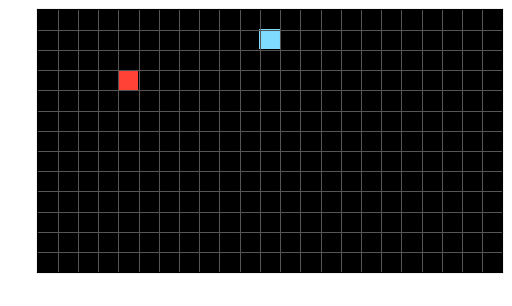

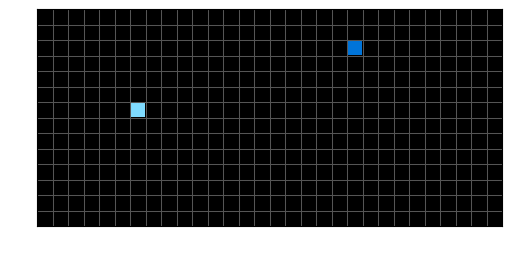

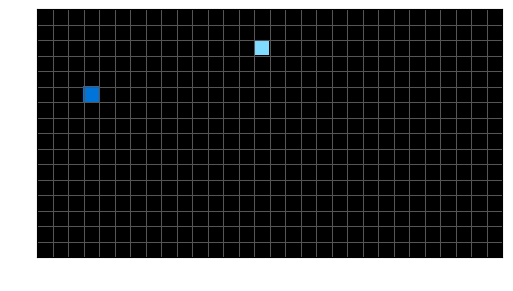

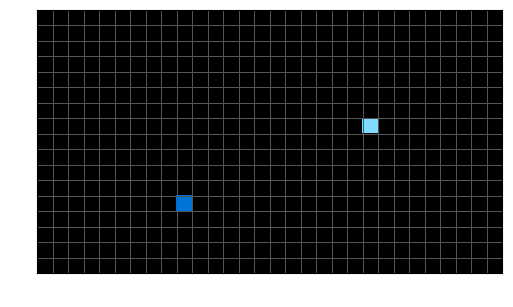

In [71]:
for i in range(len(x_inputs)):
    plot_grid(x_inputs[i]);plt.show()

In [603]:
################################################################################
# preprocess functions
################################################################################

def preprocess(task,
               index,
               output_shape,
               alpha=None,
               add_channels=0,
               pad_value=0.,
               num_augs=0,
               aug_fns=None,
               aug_params=None,
               training=True,
               ):
    
    x_example = task.inputs[index]
    y_example = task.outputs[index]
    
    x = np.zeros_like(x_example.data)
    y = np.zeros_like(y_example.data)
    
    objs_x, objs_y = task.objects[index]
    updates_left = 1
    used_objects = []
    for obj in objs_x:
        if obj.symbol == '8':
            x[tuple(obj.coordinates[0])] = obj.symbol
        elif updates_left > 0:
            x[tuple(obj.coordinates[0])] = obj.symbol
            used_objects.append(obj)
            updates_left -= 1
        
    for obj in objs_y:
        if obj.symbol == '8':
            y[tuple(obj.coordinates[0])] = obj.symbol
        elif obj in used_objects:
            y[tuple(obj.coordinates[0])] = obj.symbol
    
    background_color = task.background_colors[index]
#     num_channels = task.num_channels
#     continuity_symbols = task.continuity_symbols
#     spatial_symbols = task.spatial_symbols
    # you need to change this. -just for testing
    num_channels = 2
    spatial_symbols = [8]
    continuity_symbols = [8]
    
    x_padded = pad_grid(np.asarray(x), output_shape, pad_value)
    if y is not None:
        y_padded = pad_grid(np.asarray(y), output_shape, pad_value)
    else:
        y_padded = None
        y_augs = None
        y_output = None
        
    
    if num_augs > 0 and training:
        x_augs, y_augs = generate_augmentations(x_padded, 
                                                y_padded,
                                                aug_fns, 
                                                num_samples=num_augs,
                                                params=aug_params)
    else:
        x_augs = x_padded[None,...]
        y_augs = y_padded[None,...] if y is not None else None
    
    # need to come back to this when the input and output palette don't overlap
    
    palettes = pal_per_example(x_augs)
    x_channels = []
    y_channels = []
    cmaps = []
    for i in range(len(x_augs)):
#         if num_augs > 0:
        cmaps.append(get_cmap(palettes[i], 
                              num_channels,
                              continuity_symbols=continuity_symbols,
                              spatial_symbols=spatial_symbols,
                              background_color=background_color))
#         else:
#             cmaps.append(task.cmaps[index])
        x_channels.append(grid_to_channel(x_augs[i], 
                                         cmaps[i],
                                         background_color=background_color))
        if y is not None:
            y_channels.append(grid_to_channel(y_augs[i], 
                                              cmaps[i],
                                              background_color=background_color))
    x_channels = np.stack(x_channels)
    x_alpha = x_augs.astype(bool)[...,None]
    
    if y is not None:
        y_channels = np.stack(y_channels)
        y_alpha = y_augs.astype(bool)[...,None]
        y_output = np.concatenate([y_channels, y_alpha], axis=-1)
        
    if add_channels > 0:
        padded_template = np.repeat(x_alpha, add_channels, axis=-1)
        x_channels = np.concatenate([x_channels, padded_template], 
                                     axis=-1)
    
#     x_channels[x_channels == 0] = pad_value
#     x_channels = pad_gradient(x_channels, 100)
    # ADD TO POSTPROCESSING!!!!
#     stale_channels = np.where(x_channels.sum(axis=(0,1,2)) == 0)[0]
#     for ch in stale_channels:
#         x_channels[...,ch] = x_alpha[...,-1]
    x_output = np.concatenate([x_channels, x_alpha], axis=-1)
    
    data = {
        'input': x_output,
        'output': y_output,
        'cmap': cmaps,
    }
        
    return x_output, y_output, cmaps


def pad_gradient(x, n_iter=10):
    xg = np.asarray(x)
    b, h, w, d = get_dims(xg)
    if b == 0:
        xg = xg[None, ...]
    if d == 0:
        xg = xg[..., None]
        d = 1
    
    mid_point = np.array([h//2, w//2])
    alive_arrs = np.where(xg == 1)
    indices = np.array(list(zip(*alive_arrs)))[:,1:]
    
    scale = []
    for i in range(d):
        indices_ch = indices[indices[:,-1] == i,:-1]
        if len(indices_ch) > 0:
            scale.append((mid_point - indices_ch).mean(0))
        else:
            scale.append(np.array([0., 0.]))
    scale = -1. * np.stack(scale)
    
    dx_filter = np.repeat((SOBEL_X)[...,None], d, axis=-1) * scale[:,1]
    dy_filter = np.repeat((SOBEL_Y)[...,None], d, axis=-1) * scale[:,0]
    dx_filter = dx_filter[...,None].astype(np.float32) / 8.
    dy_filter = dy_filter[...,None].astype(np.float32) / 8.
    
    for i in range(n_iter):
        dx = tf.nn.depthwise_conv2d(xg, 
                                    dx_filter,
                                    [1,1,1,1], 
                                    'SAME').numpy()
        dy = tf.nn.depthwise_conv2d(xg, 
                                    dy_filter,
                                    [1,1,1,1], 
                                    'SAME').numpy()
        xg = (xg 
              + dx / (np.abs(dx).sum((0,1,2)) + 1e-7) 
              + dy / (np.abs(dy).sum((0,1,2)) + 1e-7))
        xg = np.clip(xg, -1 + .1, 1. - .1)
        xg[alive_arrs] = 1.
    
    return xg

################################################################################


def generate_augmentations(x, y, f_pool, num_samples=8, params=None):
    """Generates shifted samples of an input and output."""
    params = params or {}
    x_augs = []
    y_augs = []
    augs_per_example = params.get('augs_per_example', 1)
    if isinstance(augs_per_example, int):
        augs_per_example = np.random.choice(range(1, augs_per_example+1), 
                                            num_samples)
    elif len(augs_per_example) != num_samles:
        raise ValueError('Expected `augs_per_example` == `num_samples`, '
                         f'but got {augs_per_example}')
     

    for i in range(num_samples):
        f_sampled = np.random.choice(f_pool, augs_per_example[i])
        x_aug = x.copy()
        y_aug = y.copy()
        for f in f_sampled:
            f_name = f.__name__
            f_params = params.get(f_name, {}).copy()
            if f_params.get('include_y'):
                f_params.pop('include_y')
                x_aug, y_aug = f(x_aug, y_aug, **f_params)
            elif f_params.get('omit_y'):
                f_params.pop('omit_y')
                x_aug = f(x_aug, **f_params)
            else:
                x_aug = f(x_aug, **f_params)
                y_aug = f(y_aug, **f_params)
        
        x_augs.append(x_aug)
        y_augs.append(y_aug)
        
    return np.stack(x_augs), np.stack(y_augs)


def score_ca(y_true, y_pred, cmaps=None, mask_th=0.1, output_shapes=None):
    n = len(y_true)
    if cmaps is not None:
        y_true_grid = []
        y_pred_grid = []
        if not isinstance(cmaps, list):
            cmaps = [cmaps]
        for i in range(n):
            y_true_grid.append(channel_to_grid(y_true[i], 
                                               cmaps[i],
                                               0))
            y_pred_grid.append(channel_to_grid(y_pred[i], 
                                               cmaps[i],
                                               mask_th))
        if output_shapes is not None:
            if not isinstance(output_shapes, list):
                output_shapes = [output_shapes]
            y_true_grid = [unpad(y_true_grid[i], output_shapes[i]) for i in range(n)]
            y_pred_grid = [unpad(y_pred_grid[i], output_shapes[i]) for i in range(n)]
        
        y_true = np.asarray(y_true_grid)
        y_pred = np.asarray(y_pred_grid)
    
    acc = np.mean([score_task(y_true[i], y_pred[i]) for i in range(n)])
    return acc


def get_active_ch(x, num_colors=10):
    chs = tuple(range(num_colors)) + (-1,)
    if x.ndim == 3:
        values = (x[:,:,:num_colors], x[:,:,-1:])
        if isinstance(x, tf.Tensor):
            return tf.concat(values, axis=-1)
        else:
            return np.concatenate(v, axis=-1)
    else:
        values = [x[:,:,:,:num_colors], x[:,:,:,-1:]]
        if isinstance(x, tf.Tensor):
            return tf.concat(values, axis=-1)
        else:
            return np.concatenate(v, axis=-1)
        return x[:,:,chs]
    

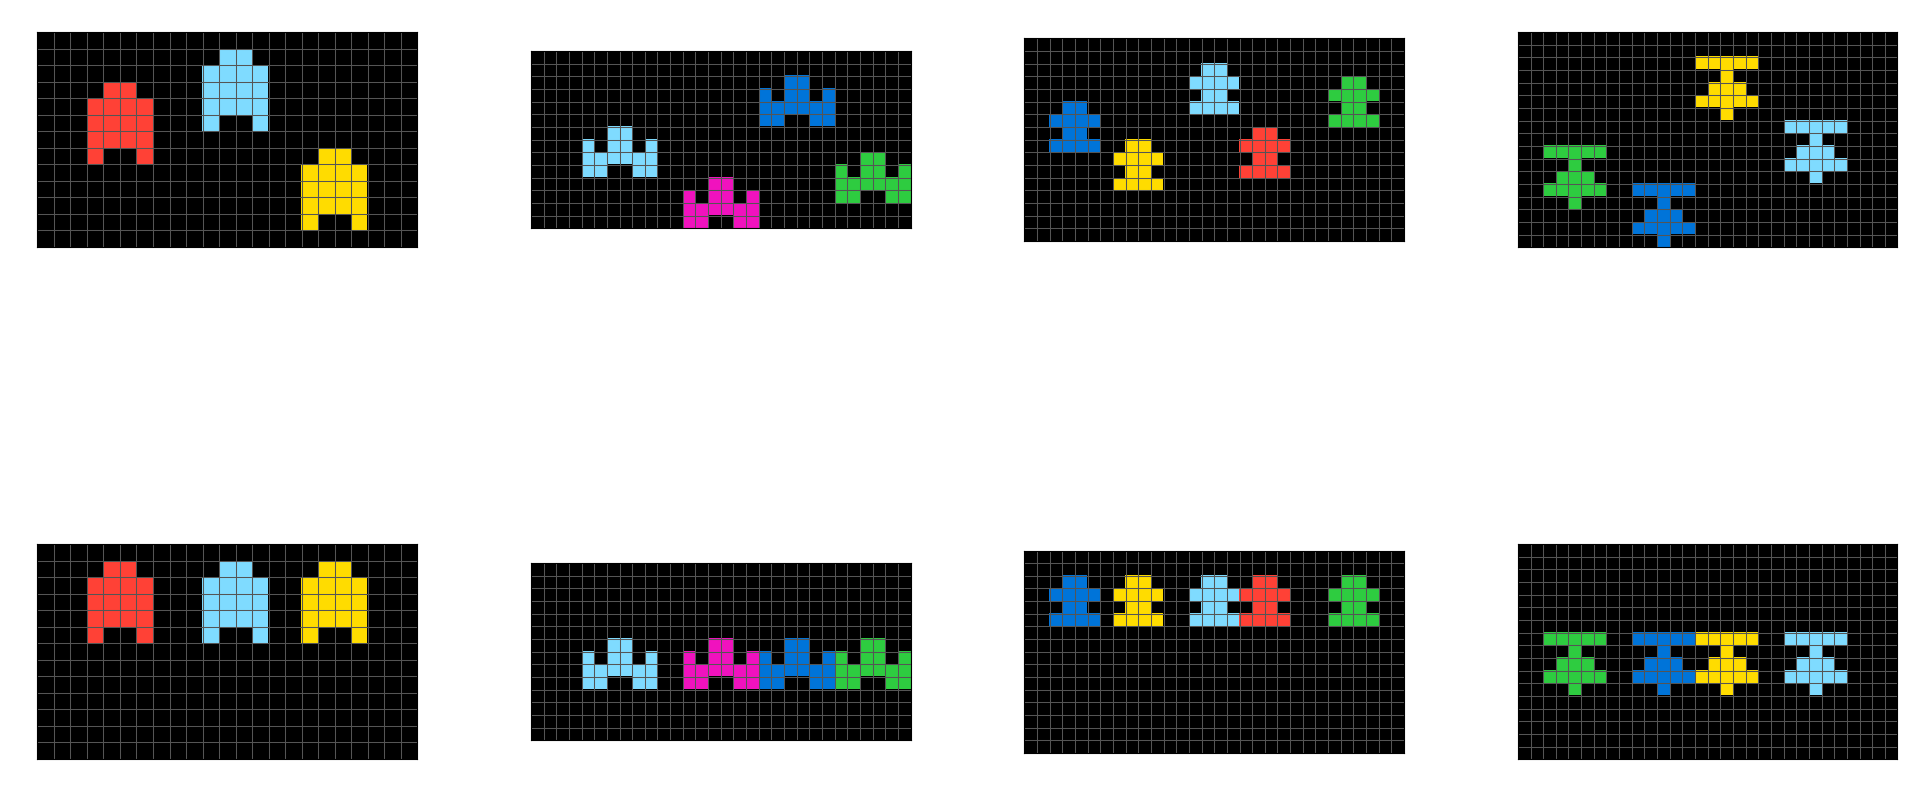

In [34]:
task = Task(id_to_filepath['e41c6fd3'])
task.plot()

In [35]:
ca_config = {
    'num_augs': 0,
    'add_channels': 0,
    'pad_value': 0.1,
    'aug_fns': [identity],
#     'aug_fns': [rot90, flip_x, flip_y, flip_xy, shift_obj, transpose, identity]
#     'aug_fns': [add_mask]
    'aug_params': {
        'shift_obj': {
            'include_y': True, 
            'max_shift': 3},
        'augs_per_example': 1,
        'add_mask': {
            'mask_shape': (6,4), 
            'omit_y': True,
            'random_state': np.random.RandomState(420),
        }
    }
}

PADDING = 0
ca_config['output_shape'] = task.max_shape + PADDING * 2

In [36]:
SEED = 42069

input_train = []
output_train = []
input_test = []
output_test = []
cmaps = []
output_shapes = []
complexity = []

# aug_params = ca_config['aug_params'].copy()

for i in range(task.num_train):
    ca_config['aug_params']['add_mask']['random_state'] = np.random.RandomState(SEED)
    background_color = task.background_colors[i]
    output_shape = task.output_shapes[i]
    input_examples, output_examples, cmap_examples = preprocess(
        task,
        i,
        **ca_config,
        training=True
    )
    
    input_train.append(input_examples)
    output_train.append(output_examples)
    cmaps.extend(cmap_examples)
    output_shapes.extend([output_shape for _ in range(len(input_examples))])
    
input_train = np.vstack(input_train)
output_train = np.vstack(output_train)

for i in range(task.num_test):
    output_shape = task.output_shapes[task.num_train + i]
    background_color = task.background_colors[task.num_train + i]
    
    input_examples, output_examples, cmap_examples = preprocess(
        task,
        i+task.num_train,
        **ca_config,
        training=False
    )
    
    input_test.append(input_examples)
    output_test.append(output_examples)
    cmaps.extend(cmap_examples)
    output_shapes.extend([output_shape for _ in range(len(input_examples))])
    
input_test = np.vstack(input_test)
output_test = np.vstack(output_test)

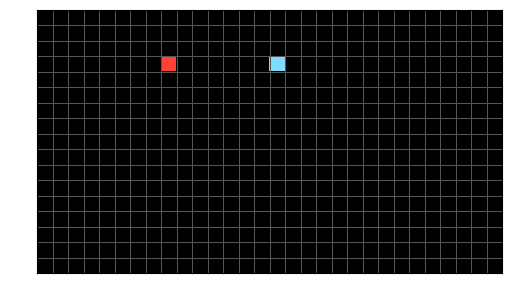

In [37]:
plot_grid(channel_to_grid(output_train[0], cmaps[0]))

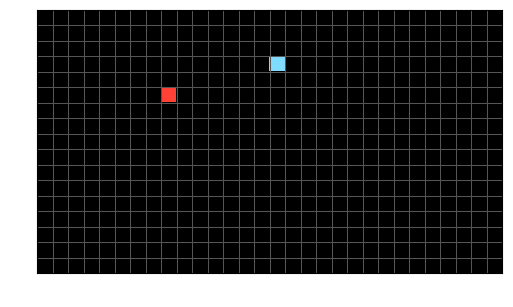

In [38]:
plot_grid(channel_to_grid(input_train[0], cmaps[0]))

In [66]:
num_input_channels = input_train.shape[-1]
num_channels = len(cmaps[0])

model = CAModel(num_channels=num_input_channels,)
initial_lr = 3e-4
optim = tf.keras.optimizers.Adam(initial_lr)

# adaptive hyperparameters and scheduler
dropout = AdapativeParam(start_value=.5, 
                         factor=.95,
                         update_f=log_scale,
                         mode='min', 
                         upper_bound=1.,
                         patience=10,
                         name='dropout')

step_size = AdapativeParam(start_value=1., 
                           factor=1,
                           mode='min',
                           lower_bound=.5,
                           patience=15,
                           name='step_size')

mask_th = AdapativeParam(start_value=0.1, 
                         factor=.95,
                         mode='min', 
                         update_f=log_scale,
                         upper_bound=.5,
                         patience=15,
                         name='mask_th')

sim_duration = AdapativeParam(start_value=16,
                              factor=1.1,
                              upper_bound=96,
                              patience=10,
                              reset=True,
                              update_f=duration_fn,
                              name='sim_duration')
update_params_lr = {
    'optim': optim,
    'min_lr': 1e-6,
}

lr = AdapativeParam(start_value=initial_lr, 
                    factor=.1,
                    lower_bound=update_params_lr['min_lr'],
                    patience=25,
                    update_f=decay_lr,
                    update_params=update_params_lr,
                    name='lr')

params = {
    'dropout': dropout, 
    'step_size': step_size, 
    'mask_th': mask_th,
    'lr': lr,
}
sched = Scheduler(params)

pool_size = 128
batch_size = 3
num_reset = 1
rank_loss_f = lambda y, x: mean_squared_error(y, get_pred(x, num_channels))
start_data = [input_train[:1], output_train[:1], output_shapes[:1], cmaps[:1]]
sampler = Sampler(start_data, pool_size,)

cleanup_ckpts()
dt_str = datetime.datetime.now().strftime('%Y%m%d_%H-%M-%S')
ckpt_dir = os.path.join(LOG_DIR, f'{task.name}_{dt_str}')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

use_sampler = True
print(sched)

<Scheduler: 
	<AdapativeParam (dropout): 0.5>
	<AdapativeParam (step_size): 1.0>
	<AdapativeParam (mask_th): 0.1>
	<AdapativeParam (lr): 0.0003>>


step 1 - loss : 0.0024 - acc : 0.9933  - best : 0.0024 (1)  - 0.9933 (1)  - 0.9961 (0.9961, 1)


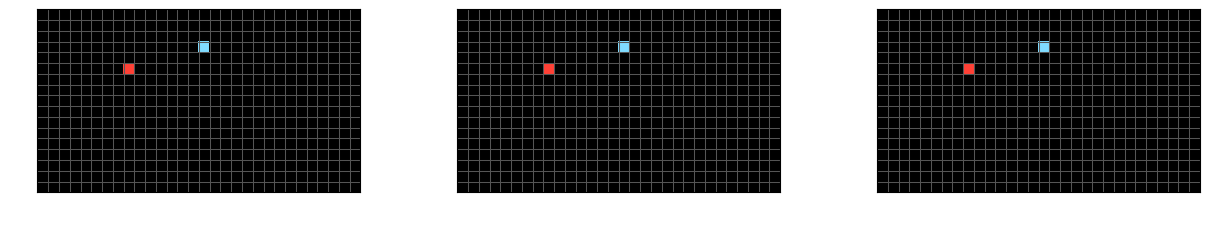

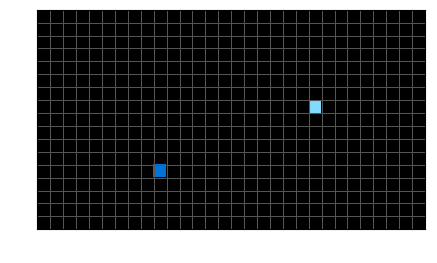

step 2 - loss : 0.0022 - acc : 0.9933  - best : 0.0022 (2)  - 0.9933 (1)  - 0.9961 (0.9961, 1)


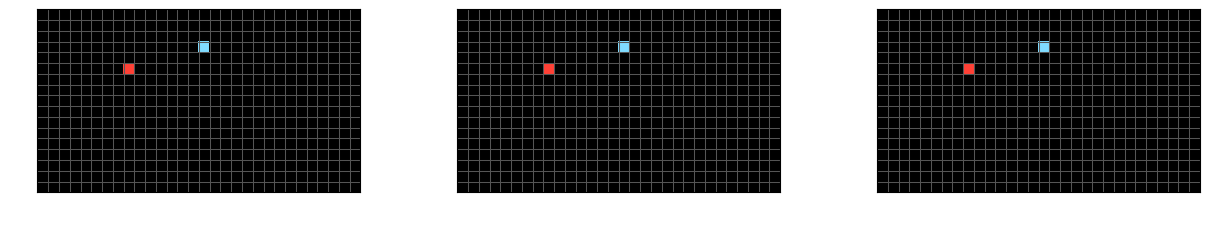

step 3 - loss : 0.0020 - acc : 0.9933  - best : 0.0020 (3)  - 0.9933 (1)  - 0.9961 (0.9961, 1)


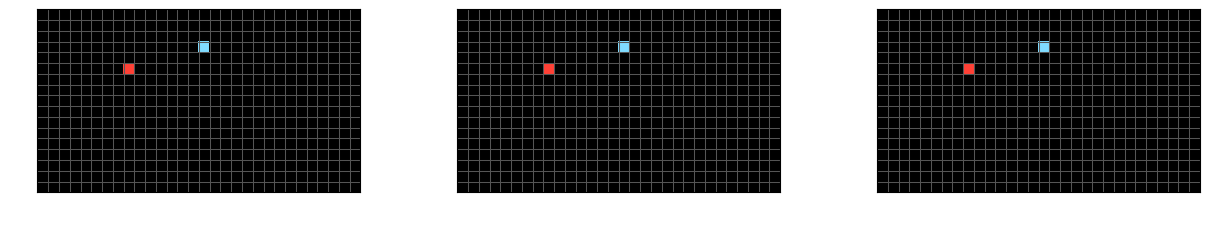

step 4 - loss : 0.0018 - acc : 0.9933  - best : 0.0018 (4)  - 0.9933 (1)  - 0.9961 (0.9961, 1)


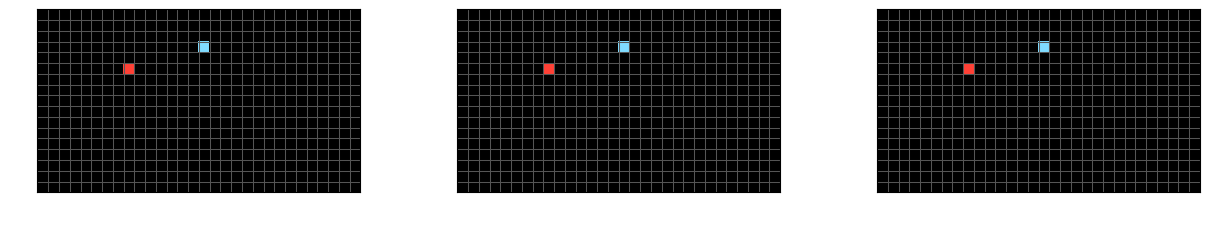

step 5 - loss : 0.0018 - acc : 0.9933  - best : 0.0018 (4)  - 0.9933 (1)  - 0.9961 (0.9961, 1)
step 6 - loss : 0.0016 - acc : 0.9933  - best : 0.0016 (6)  - 0.9933 (1)  - 0.9961 (0.9961, 1)


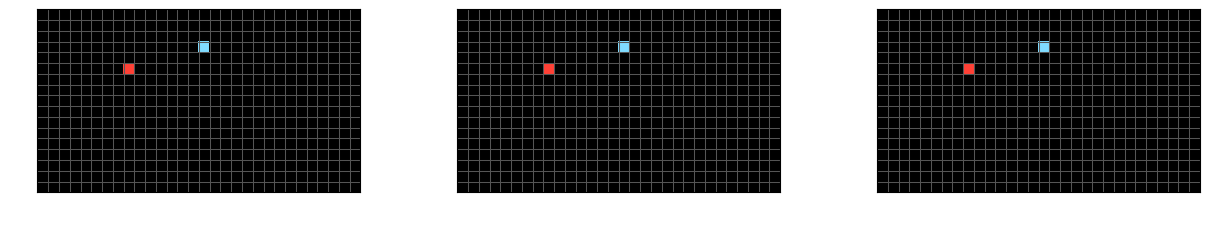

step 7 - loss : 0.0017 - acc : 0.9933  - best : 0.0016 (6)  - 0.9933 (1)  - 0.9961 (0.9961, 1)
step 8 - loss : 0.0016 - acc : 0.9933  - best : 0.0016 (8)  - 0.9933 (1)  - 0.9961 (0.9961, 1)


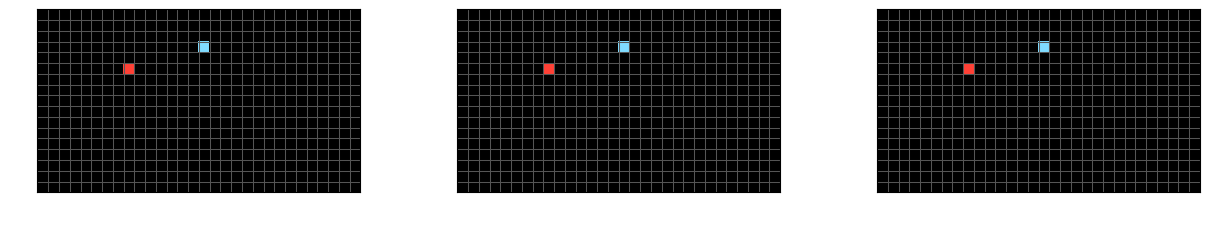

step 9 - loss : 0.0016 - acc : 0.9933  - best : 0.0016 (9)  - 0.9933 (1)  - 0.9961 (0.9961, 1)


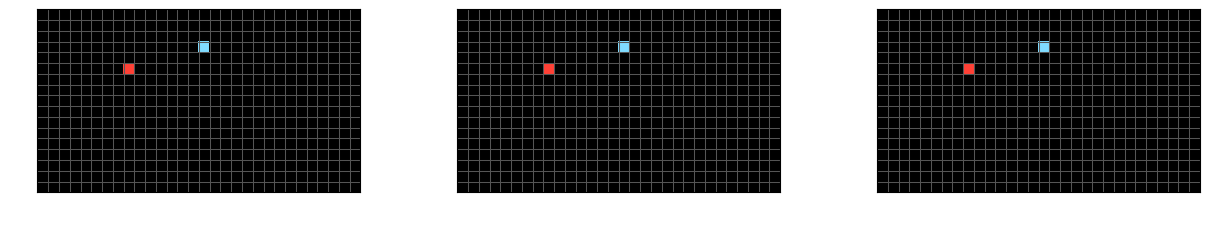

step 10 - loss : 0.0016 - acc : 0.9933  - best : 0.0016 (9)  - 0.9933 (1)  - 0.9961 (0.9961, 1)
step 11 - loss : 0.0015 - acc : 0.9933  - best : 0.0015 (11)  - 0.9933 (1)  - 0.9961 (0.9961, 1)


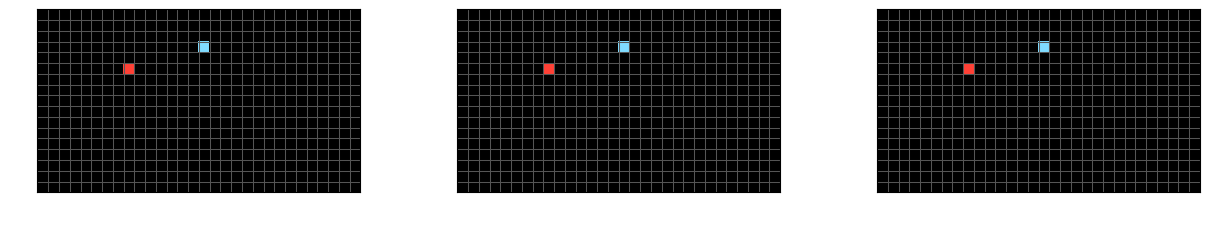

step 12 - loss : 0.0014 - acc : 0.9955  - best : 0.0014 (12)  - 0.9955 (12)  - 0.9980 (0.9980, 12)


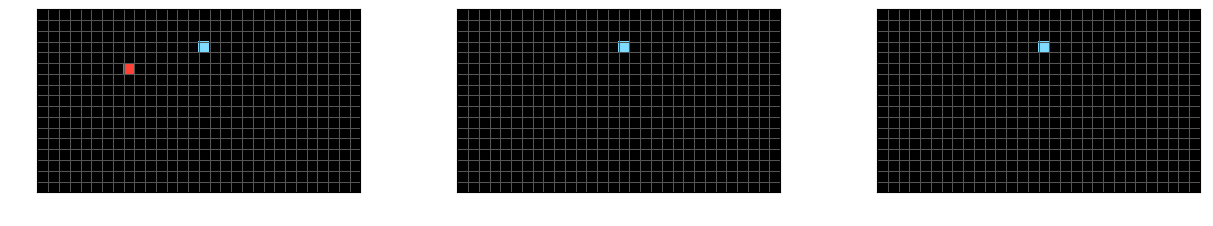

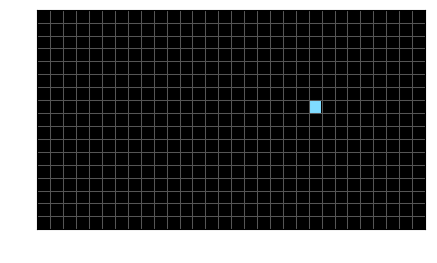

step 13 - loss : 0.0014 - acc : 0.9933  - best : 0.0014 (12)  - 0.9955 (12)  - 0.9980 (0.9980, 12)
step 14 - loss : 0.0014 - acc : 0.9933  - best : 0.0014 (14)  - 0.9955 (12)  - 0.9980 (0.9980, 12)


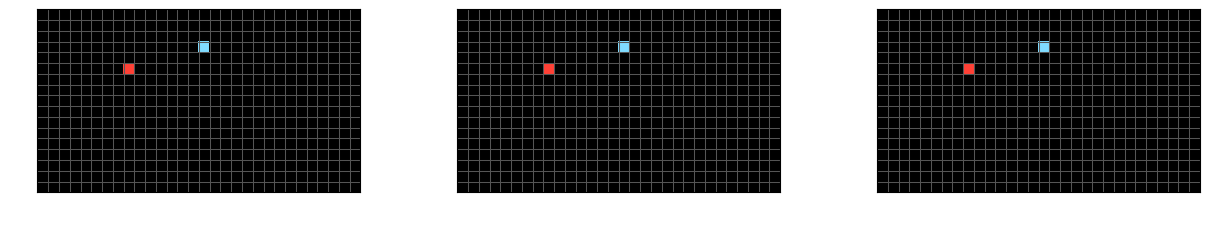

step 15 - loss : 0.0014 - acc : 0.9933  - best : 0.0014 (14)  - 0.9955 (12)  - 0.9980 (0.9980, 12)
step 16 - loss : 0.0013 - acc : 0.9933  - best : 0.0013 (16)  - 0.9955 (12)  - 0.9980 (0.9980, 12)


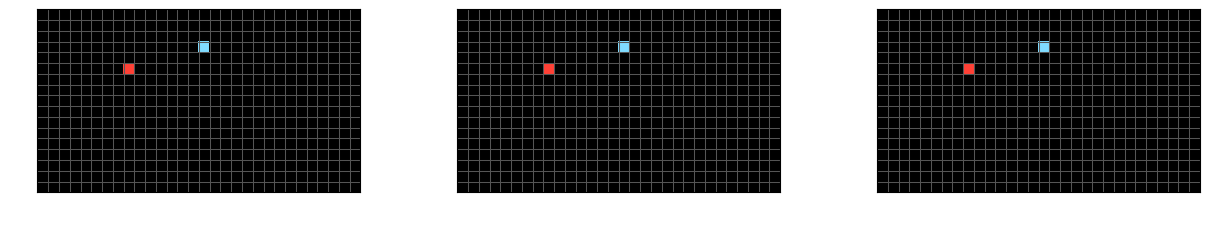

step 17 - loss : 0.0013 - acc : 0.9933  - best : 0.0013 (17)  - 0.9955 (12)  - 0.9980 (0.9980, 12)


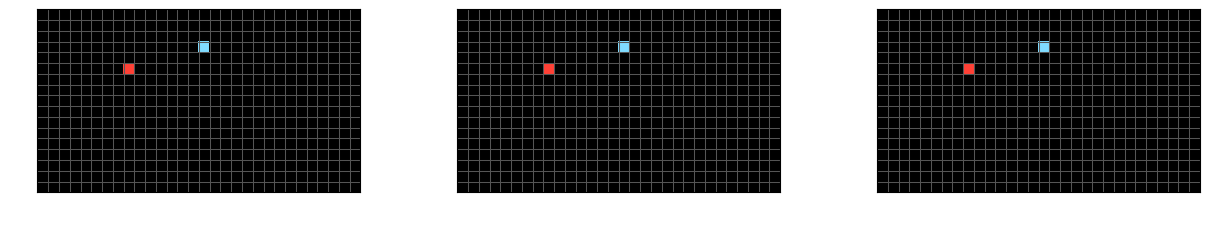

step 18 - loss : 0.0013 - acc : 0.9944  - best : 0.0013 (18)  - 0.9955 (12)  - 0.9980 (0.9980, 12)


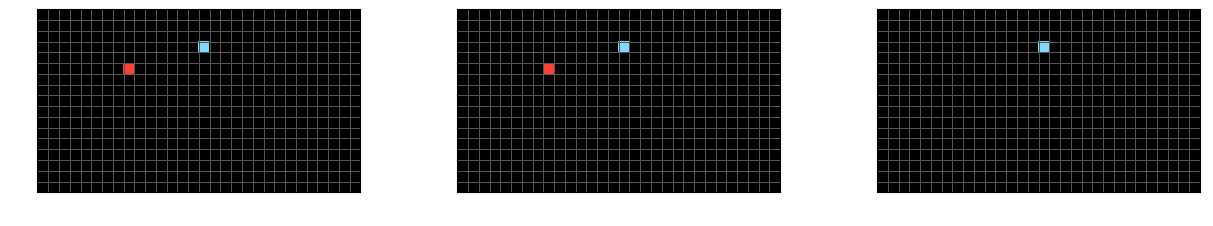

step 19 - loss : 0.0014 - acc : 0.9933  - best : 0.0013 (18)  - 0.9955 (12)  - 0.9980 (0.9980, 12)
step 20 - loss : 0.0013 - acc : 0.9955  - best : 0.0013 (20)  - 0.9955 (12)  - 0.9980 (0.9980, 12)


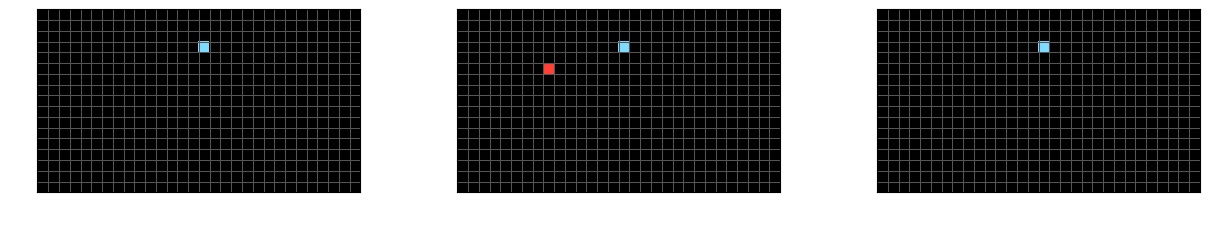

step 21 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)


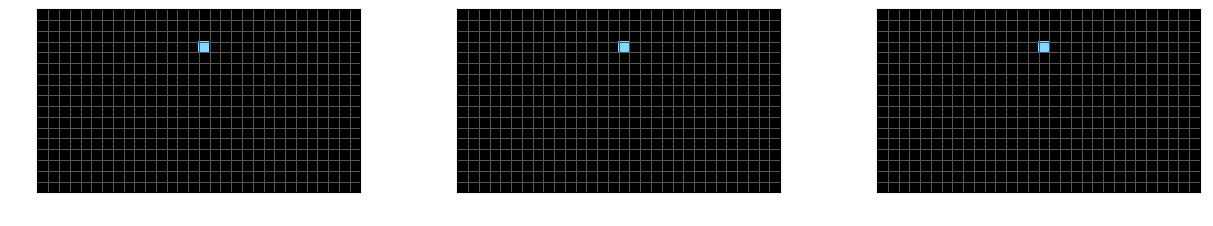

step 22 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 23 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 24 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 25 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 26 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 27 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 28 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 29 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 30 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 31 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (21)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 32 - 

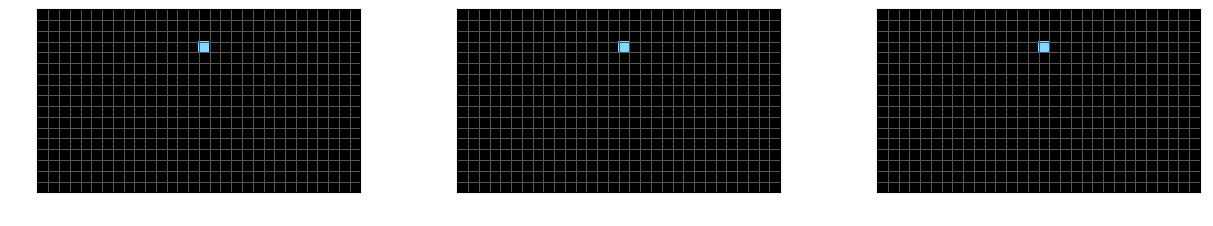

step 33 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)


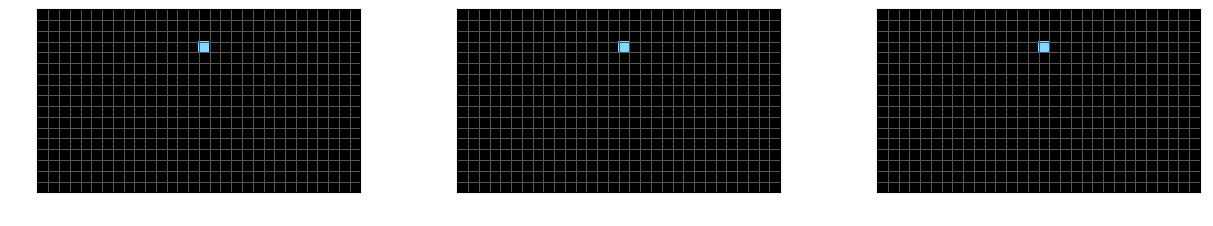

step 34 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 35 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 36 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 37 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 38 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 39 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 40 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 41 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 42 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 43 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (33)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 44 - 

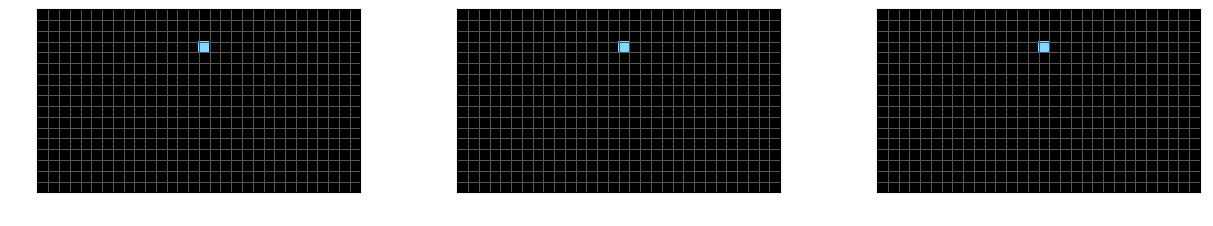

step 73 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (72)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 74 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (72)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 75 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (72)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 76 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (72)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 77 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (72)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 78 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (72)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 79 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (72)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 80 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (72)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 81 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (72)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 82 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (82)  - 0.9967 (21)  - 0.9980 (0.9980, 12)


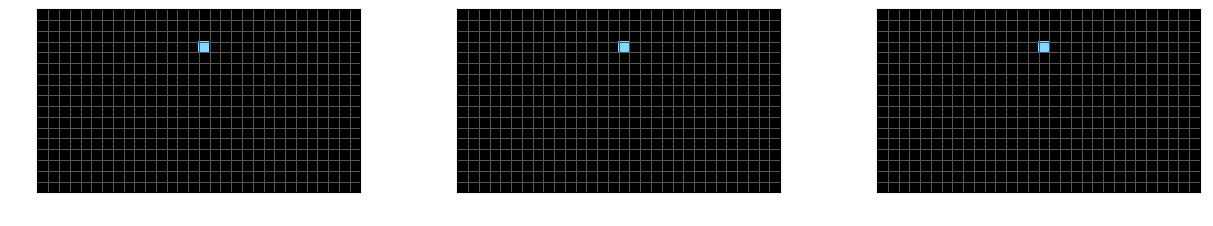

step 83 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (82)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 84 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (82)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 85 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (82)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 86 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (82)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 87 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (87)  - 0.9967 (21)  - 0.9980 (0.9980, 12)


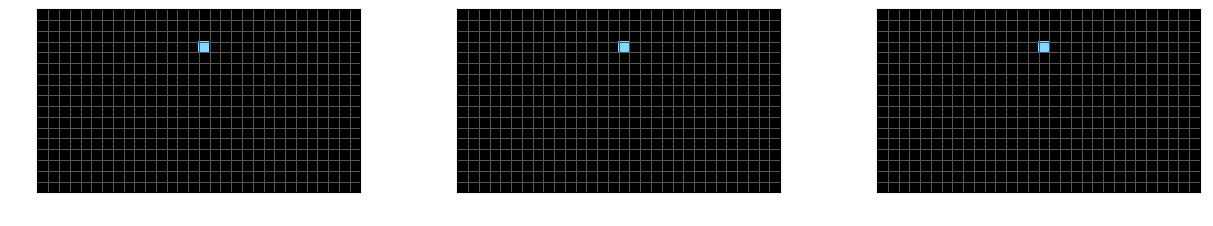

step 88 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (87)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 89 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)


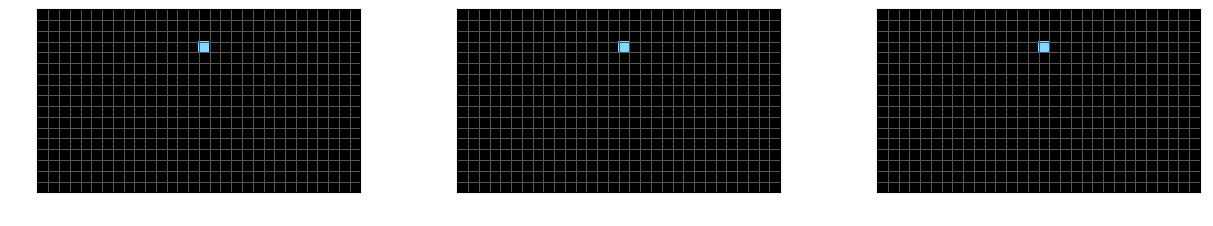

step 90 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 91 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 92 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 93 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 94 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 95 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 96 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 97 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 98 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 99 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (89)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 100 -

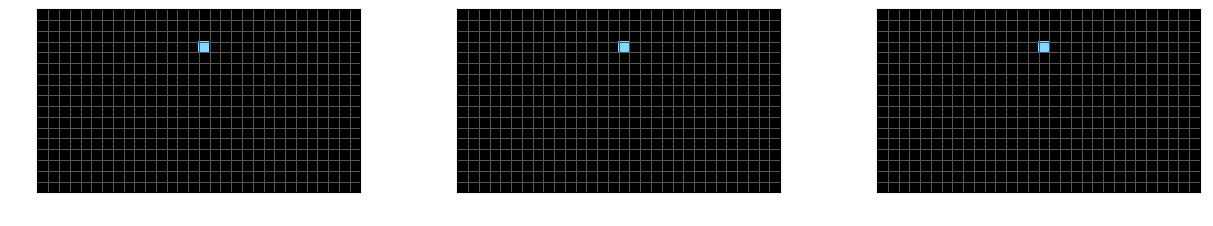

step 105 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (104)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 106 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (104)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 107 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (104)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 108 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (104)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 109 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (104)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 110 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (104)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 111 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (104)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 112 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (104)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 113 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (104)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 114 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (114)  - 0.9967 (21)  - 0.9980 (0.

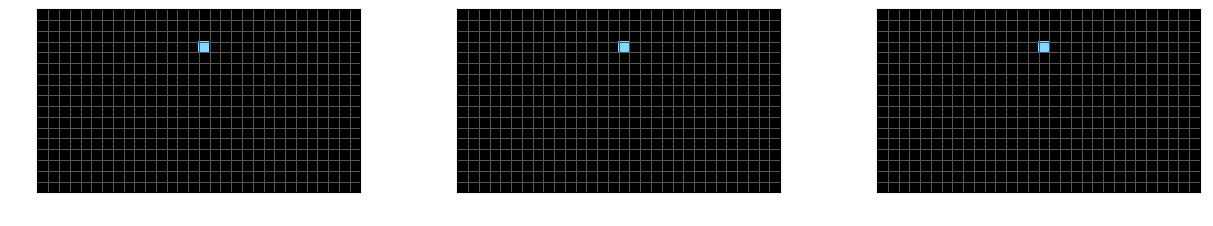

step 115 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (114)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 116 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (114)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 117 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)


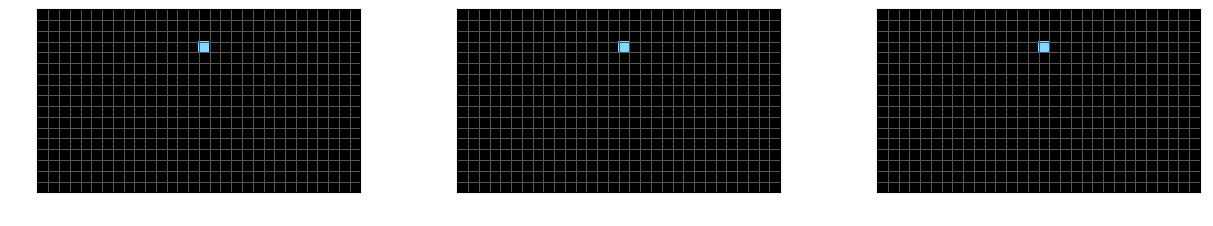

step 118 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 119 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 120 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 121 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 122 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 123 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 124 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 125 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 126 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 127 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (117)  - 0.9967 (21)  - 0.9980 (0.

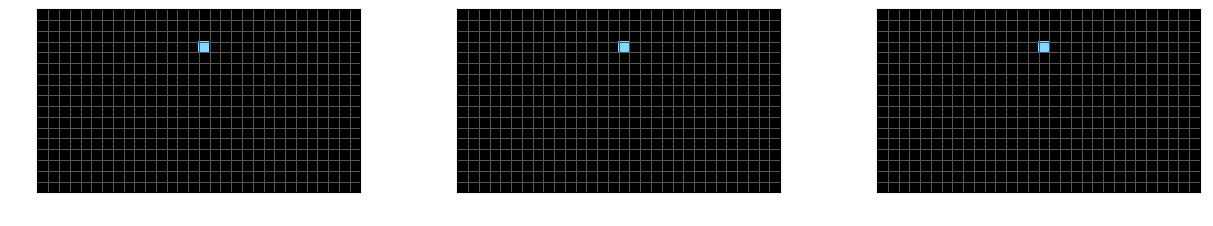

step 130 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 131 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 132 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 133 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 134 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 135 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 136 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 137 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 138 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 139 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (129)  - 0.9967 (21)  - 0.9980 (0.

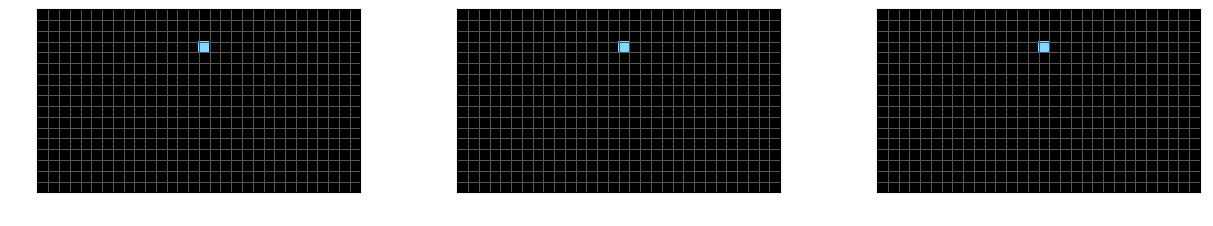

step 167 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 168 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 169 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 170 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 171 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 172 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 173 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 174 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 175 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 176 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (166)  - 0.9967 (21)  - 0.9980 (0.

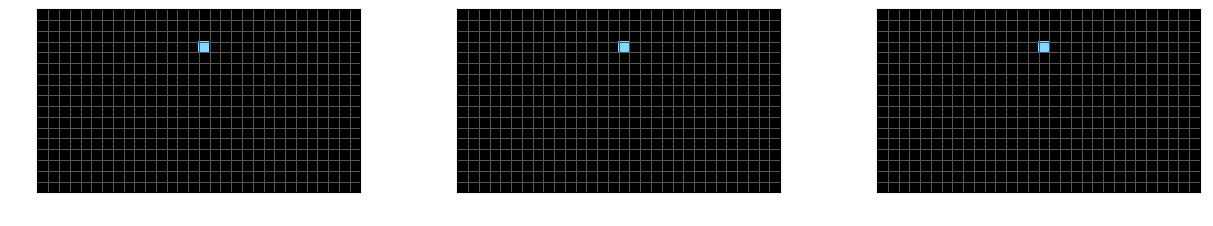

step 183 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (182)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 184 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (182)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 185 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)


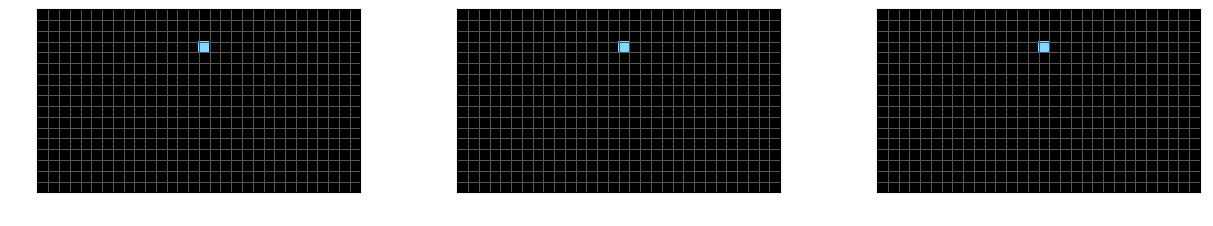

step 186 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 187 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 188 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 189 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 190 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 191 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 192 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 193 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 194 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 195 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (185)  - 0.9967 (21)  - 0.9980 (0.

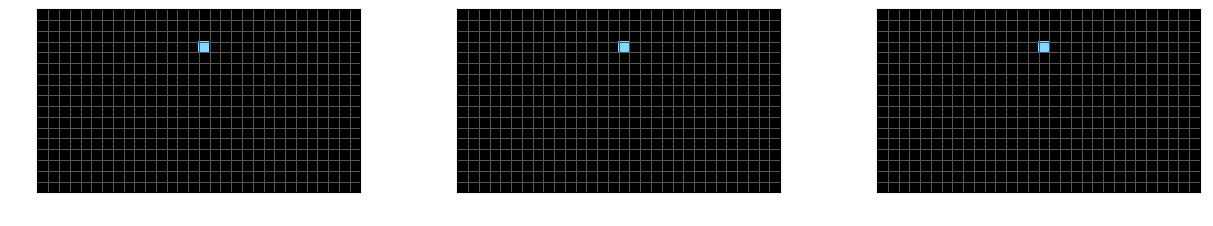

step 211 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (210)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 212 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (210)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 213 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (210)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 214 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (210)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 215 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (210)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 216 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (210)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 217 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (210)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 218 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (210)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 219 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (210)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 220 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (220)  - 0.9967 (21)  - 0.9980 (0.

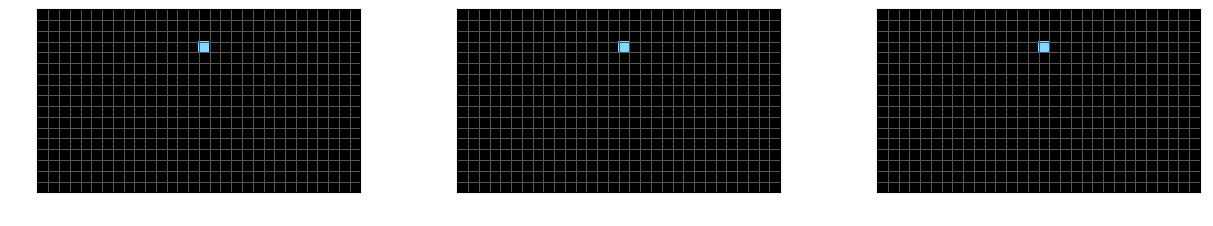

step 221 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (220)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 222 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (220)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 223 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (220)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 224 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (220)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 225 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (225)  - 0.9967 (21)  - 0.9980 (0.9980, 12)


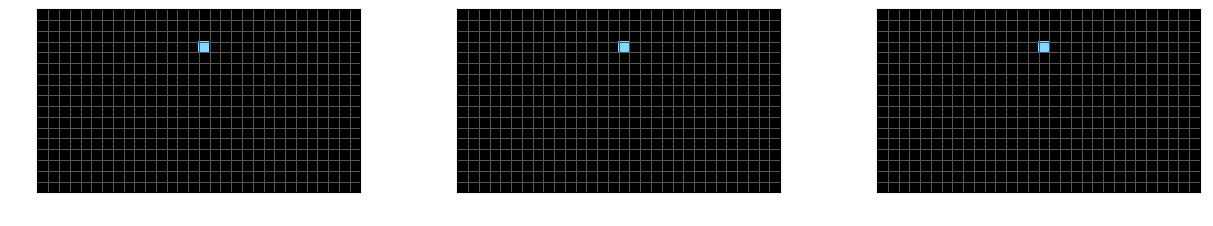

step 226 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (225)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 227 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)


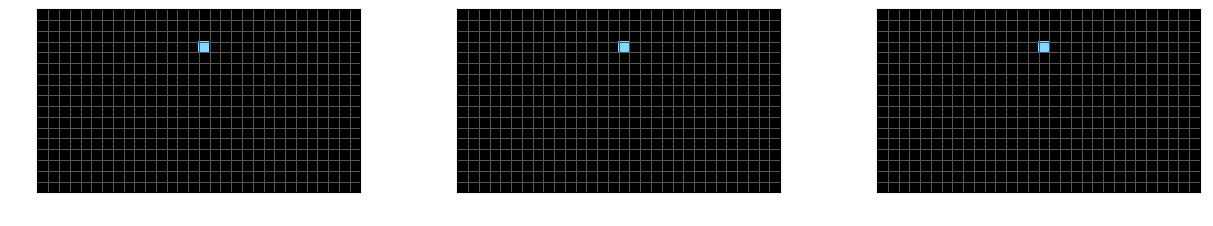

step 228 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 229 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 230 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 231 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 232 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 233 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 234 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 235 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 236 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.9980, 12)
step 237 - loss : 0.0013 - acc : 0.9967  - best : 0.0013 (227)  - 0.9967 (21)  - 0.9980 (0.

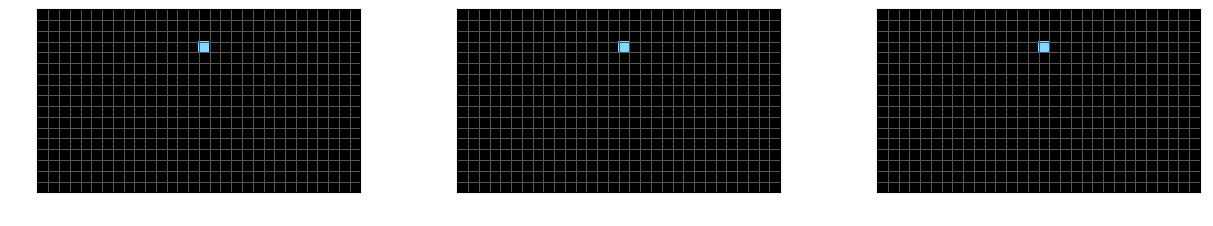

KeyboardInterrupt: 

In [69]:
@tf.function
def compute_apply_gradients(model, optim, x, y, sims=64, **kwargs):
    with tf.GradientTape(persistent=False) as g:
        for _ in tf.range(sims):
            x = model(x, **kwargs)
        loss = tf.reduce_mean(mean_squared_error(y, get_pred(x, y.shape[-1]-1)))

    # backprop
    gw = g.gradient(loss, model.weights)
    gw = [g/(tf.norm(g)+1e-8) for g in gw]
    optim.apply_gradients(zip(gw, model.weights))
    return x, loss

# x_start = tf.convert_to_tensor(input_train[(slice(1),Ellipsis,slice(ch,ch+1))].copy())
x_start = tf.convert_to_tensor(input_train[:1].copy())
x = x_start
y = tf.convert_to_tensor(output_train[:1].copy())
# y = tf.convert_to_tensor(output_train[(slice(1),Ellipsis,slice(ch,ch+1))].copy())
# x_val = tf.convert_to_tensor(input_train[(slice(1,2),Ellipsis,slice(ch,ch+1))].copy())
# y_val = tf.convert_to_tensor(output_train[(slice(1,2),Ellipsis,slice(ch,ch+1))].copy())
x_val = tf.convert_to_tensor(input_test.copy())
y_val = tf.convert_to_tensor(output_test.copy())
cmap = cmaps
shapes = output_shapes

val_cmap = cmaps[-1:]
val_shapes = cmaps[-1:]

input_states = []
output_states = []
losses = []
accs = []
dx = []
val_preds = []

best_loss = np.inf
best_acc = 0
best_loss_step = 0
best_acc_step = 0
val_acc = 0
best_val_acc = 0
best_val_step = 0

steps = 300
new_best = False
new_best_val = False

for _ in range(steps):
    step = optim.iterations.numpy()
    sims = tf.random.uniform([], 64, 96, tf.int32)
    
    # update inputs, outputs, and metadata when using sampler
    if use_sampler:
        batch = sampler.sample(batch_size)
        x, y, shapes, cmap = batch.get(rank_loss_f, num_reset)
        
    input_states.append(x)
    dx.append(model.perceive(x))
    x, loss = compute_apply_gradients(model, 
                                      optim,
                                      x,
                                      y, 
                                      sims=sims,
                                      dropout=sched['dropout'], 
                                      mask_th=sched['mask_th'], 
                                      step_size=sched['step_size'])

    acc = score_ca(y, 
                   get_pred(x, num_channels), 
                   cmap, 
                   mask_th=mask_th,
                   output_shapes=shapes)

    if loss < best_loss:
        best_loss = loss
        best_loss_step = step
        new_best = True
        save_model(model, os.path.join(ckpt_dir, f'{step:04d}_{loss}_{acc}'), sched)
    if acc > best_acc:
        best_acc = acc
        best_acc_step = step
        new_best = True
        save_model(model, os.path.join(ckpt_dir, f'{step:04d}_{loss}_{acc}'), sched)
        
    y_pred_val = generate_predictions(model, 
                                      x_val,
                                      cmaps[-1], 
                                       target=y_val,
                                       mask_th=mask_th.value, 
                                       step_size=tf.constant(1.),
                                       dropout=tf.constant(.8), 
                                       steps=tf.constant(80),
                                       return_best=True)
    val_acc = score_ca(y_val, 
                        get_pred(y_pred_val, num_channels), 
                        cmaps[-1],
                        mask_th=mask_th,
                        output_shapes=output_shapes[-1])
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_step = step
        val_preds.append(y_pred_val)
        new_best_val = True
    
    print(f'step {step} - loss : {loss.numpy():.4f} - acc : {acc:.4f} '
          f' - best : {best_loss:.4f} ({best_loss_step}) '
          f' - {best_acc:.4f} ({best_acc_step}) '
          f' - {val_acc:.4f} ({best_val_acc:.4f}, {best_val_step})')
    
    if new_best:
        plot_grids(get_pred(x, num_channels), cmap, mask_th, 6)
        
    if new_best_val:
        plot_grids(get_pred(y_pred_val, num_channels), val_cmap, mask_th)
        
    sched(loss, step)
    
    output_states.append(x.numpy())
    losses.append(loss.numpy())
    accs.append(acc)
    
    if use_sampler:
        batch.update(list(zip(*[x, y, shapes, cmap])))
    else:
        x = x_starto
    
    new_best = False
    new_best_val = False

In [68]:
def score_task(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
#     if y_true.shape != y_pred.shape:
#         raise ValueError("Output and prediction shapes don't match. "
#                         f"Expected {y_true.shape}, got {y_pred.shape}")
    
    score = np.sum(y_true == y_pred) / y_pred.size
    return score

In [604]:
def propagation_step(node_states,
                     edges,
                     message_net,
                     agg_types=['sum'],
                     edge_features=None):
    """Performs a propagation step (message passing) in a graph.
    
    Parameters
    ----------
    node_states : tf.Tensor
        Matrix of shape (num_nodes, node_state_dim), where row i corresponds to
        the current state of node i (u_i).
    edges : tf.Tensor
        Matrix of shape (num_edges, 2) where each row corresponds to a an edge
        connecting nodes (u, v). Here column 1 are the tail nodes u and column 2
        are the head nodes v.
    message_net: tf.keras.Model
            A network that maps a concatenation of node states and edge features
            to message vectors.
            Example :
                `num_nodes` = 25
                `node_state_dim` = 2
                `num_edges` = 120
                    -> `message_net` will take a tensor of shape (120, 4)
                If `edge_features` is a tensor of shape (120, 8)
                    -> `message_net` will take a tensor of shape (120, 12)
    agg_type : str (default='sum')
        Name of the operation used to aggregate the messages from all edges to a
        single message per node. Here the messages corresponding to node v (column 1 of `edges`)
        are used as the index to aggregate edge messages.
    edge_features : tf.Tensor (default=None)
        Matrix of shape (num_edges, edge_feature_dim), where row i corresponds
        to a feature vector for edge i in `edges`.
    
    Returns
    -------
        agg_messages : tf.Tensor
            Matrix of shape (num_nodes, agg_message_dim) where row i is the aggregated message
            for node i.
    """
    agg_types = agg_types if isinstance(agg_types, list) else [agg_types]
    agg_ops = [AGG_TYPE[t] for t in agg_types]
    out_states = tf.gather(node_states, edges[:,0])
    in_states = tf.gather(node_states, edges[:,1])

    edge_states = [out_states, in_states]
    if edge_features is not None:
        edge_states.append(edge_features)
    
    edge_states = tf.concat(edge_states, axis=-1)
    messages = message_net(edge_states)
    agg_messages = []
    for agg_op in agg_ops:
        agg_messages.append(agg_op(messages, edges[:,1], tf.shape(node_states)[0]))
    
    return tf.concat(agg_messages, axis=-1)

def compute_softmax(x):
    e_x = tf.math.exp(x - tf.math.reduce_max(x) + 1e-7)
    return e_x / tf.reduce_sum(e_x, axis=1, keepdims=True)

def compute_loss(y_true, y_pred):
    loss = tf.reduce_mean(y_true * tf.math.log(y_pred + 1e-7))
    return -loss

def mean_squared_error(y_true, y_pred, axis=None):
    if axis is None:
#         axis = [-3, -2, -1]
        axis  = range(1, len(y_train.shape))
    return -tf.reduce_mean(tf.square(y_true-y_pred), axis=axis)

def score_state(y, x_state):
    return np.mean(np.argmax(y, axis=1) == np.argmax(x_state, axis=1))

In [605]:
class GraphEncoder(tf.keras.Model):
    """Encoder module that projects node and edge features to some embeddings."""

    def __init__(self,
                 node_units=32,
                 edge_units=None,
                 norm_nodes=False,
                 norm_edges=False):
        super(GraphEncoder, self).__init__()
        if isinstance(node_units, (tuple, list)):
            self._node_units = node_units
        else:
            self._node_units = [node_units]
        if isinstance(edge_units, (tuple, list)):
            self._edge_units = edge_units
        elif edge_units is not None:
            self._edge_units = [edge_units]
        else:
            self._edge_units = None
            
        self._norm_nodes = norm_nodes
        self._norm_edges = norm_edges
        
        self.node_net = tf.keras.Sequential(name='node_net')
        for i in range(len(self._node_units)):
            self.node_net.add(
                tf.keras.layers.Dense(
                    self._node_units[i],
                    activation=tf.nn.relu,
#                     kernel_constraint=tf.keras.constraints.MaxNorm(3),
                    use_bias=False
                )
            )
            if self._norm_nodes:
                self.node_net.add(tf.keras.layers.LayerNormalization())
        
        if self._edge_units is not None:
            self.edge_net =tf.keras.Sequential(name='edge_net')
            for i in range(len(self._edge_units)):
                self.edge_net.add(
                    tf.keras.layers.Dense(
                        self._edge_units[i],
                        activation=tf.nn.relu,
#                         kernel_constraint=tf.keras.constraints.MaxNorm(3),
                        use_bias=False
                    )
                )
                if self._norm_edges:
                    self.edge_net.add(tf.keras.layers.BatchNormalization())
        else:
            self.edge_net = None
            
    @tf.function
    def call(self, node_features, edge_features=None):
        node_state = self.node_net(node_features)
        
        if edge_features is not None:
            edge_state = self.edge_net(edge_features)
        else:
            edge_state = None
        
        return node_state, edge_state
    
    
AGG_TYPE = {
    'sum': tf.math.unsorted_segment_sum,
    'mean': tf.math.unsorted_segment_mean,
    'max': tf.math.unsorted_segment_max,
    'min': tf.math.unsorted_segment_min,
    'prod': tf.math.unsorted_segment_prod,
    'sqrt_n': tf.math.unsorted_segment_sqrt_n,
}

class GraphAggregator(tf.keras.Model):
    """Graph aggregator modeule.
    
    This module 
        (1) Encodes the incoming node states into a new representation,
        (3) (optionally) Enocdes the aggregated states with an additional network.
        
    Parameters
    ----------
    node_units : int, list
        Dimensionality of the output space for the node transformation network.
        The last element is the size of the aggregated graph representation..
    output_units: int, list
        Dimensionality of the output space for an additional output network
        that is applied after the initial node transformation.
        The last element of this list is the final dimensionality of the output node representations.
    gated : bool (default=True)
        Boolean whether to apply a gated aggregation.
    agg_type : str (default='sum')
        Name of the operation used to aggregate the node states outputed from the initial node
        transformation network.
    """
    def __init__(self,
                 node_units,
                 output_units=None,
                 gated=True,
                 output_scale=.1,
                 norm_nodes=False,
                 norm_outputs=False,
                 agg_types='sum'):
        super(GraphAggregator, self).__init__()
        
        if isinstance(node_units, (list, tuple)):
            self._node_units = node_units
        else:
            self._node_units = [node_units]
        
        if isinstance(output_units, (list, tuple)):
            self._output_units = output_units
        elif not None:
            self._output_units = [output_units]
        else:
            self._output_units = None
            
        self.gated = gated
        self._node_state_dim = self._node_units[-1]
        if self.gated:
            # double output dim 
            self._node_units = self._node_units[:-1] + [self._node_state_dim * 2]
            
        if isinstance(agg_types, str):
            self._agg_types = [agg_types]
        elif isinstance(agg_types, (list, tuple)):
            self._agg_types = agg_types
        else:
            raise ValueError('Expected {agg_types}')
        self.agg_ops = [AGG_TYPE[n] for n in self._agg_types]
        
        self._norm_nodes = norm_nodes
        self._norm_outputs = norm_outputs
        self._output_scale = output_scale
        
        self.node_net = tf.keras.Sequential()
        for i in range(len(self._node_units)):
            self.node_net.add(
                tf.keras.layers.Dense(
                    self._node_units[i],
                    activation=tf.nn.relu,
#                     kernel_constraint=tf.keras.constraints.MaxNorm(3),
                    use_bias=False
                )
            )
            if self._norm_nodes:
                self.node_net.add(tf.keras.layers.LayerNormalization())
        
        if self._output_units is not None:
            self.output_net = tf.keras.Sequential(name='output_net')
            for i in range(len(self._output_units)):
                if i == len(self._output_units) - 1:
                    act = None # linear
                else:
                    act = tf.nn.relu
                self.output_net.add(
                    tf.keras.layers.Dense(self._output_units[i], 
                                          activation=act,
                                          kernel_initializer=tf.keras.initializers.VarianceScaling(self._output_scale),
#                                           kernel_initializer=tf.zeros_initializer,
                                          use_bias=False)
                )
                if self._norm_outputs:
                    self.output_net.add(tf.keras.layers.BatchNormalization())
        else:
            self.output_net = None
    
    @tf.function
    def call(self, node_states, num_nodes, node_idx=None):
        """
        Parameters
        ----------
        node_states : tf.Tensor
            Matrix of shape (num_edges, node_state_dim), where row i corresponds to
            the current state of node i (u_i).
        node_idx : tf.Tensor
            Vector of length `num_edges` where the i^th element corresponds to row
            i in `edges` used to map the index of node v_j in `node_features`.
        num_nodes : int
            Number of nodes in the graph.
            
        Returns
        -------
        output_states : tf.Tensor
            Matrix of shape (num_nodes, node_state_dim) where each row corresponds
            to the final output state of node u_i.
        """
        node_states = self.node_net(node_states)
        if self.gated:
            gates = tf.nn.sigmoid(node_states[:, :self._node_state_dim])
            node_states = node_states[:, self._node_state_dim:] * gates
        
#         if node_idx is not None:
#             output_states = []
#             for agg_op in self.agg_ops:
#                 output_states.append(agg_op(node_states, node_idx, num_nodes))

#             if len(output_states) > 1:
#                 output_states = tf.concat(output_states, axis=-1)
#             else:
#                 output_states = output_states[0]
#         else:
#             output_states = node_states
#         if self._agg_type == 'max':
#             output_states *= tf.cast(node_states > -1e5, tf.float32)
        
        return self.output_net(node_states)
#         if self.output_net is not None:
#             output_states = self.output_net(output_states)
#         return output_states


class GraphPropagation(tf.keras.Model):
    """Implementation of a graph propagation (message passing) layer."""

    def __init__(self,
                 node_state_dim,
                 edge_units,
                 node_units,
                 edge_scale=0.1,
                 node_update_type='gru',
                 agg_types='sum',
                 norm_messages=False,
                 norm_nodes=False,
                 reverse=True,
                 share_reverse=True,
                 index=None):
        super(GraphPropagation, self).__init__()

        self._node_state_dim = node_state_dim
        if isinstance(edge_units, (list, tuple)):
            self._edge_units = edge_units
        else:
            self._edge_units = [edge_units]
        # output size is node_state_dim
        if isinstance(node_units, (list, tuple)):
            self._node_units = node_units + [self._node_state_dim]
        else:
            self._node_units = [node_units, self._node_state_dim]
        self._edge_scale = edge_scale
        self._node_update_type = node_update_type

        self._norm_messages = norm_messages
        self._norm_nodes = norm_nodes
        self._reverse = reverse
        self._share_reverse = share_reverse
        self._index = '' if index is None else f'_{index}'
        
        if isinstance(agg_types, str):
            self._agg_types = [agg_types]
        elif isinstance(agg_types, (list, tuple)):
            self._agg_types = agg_types
        else:
            raise ValueError('Expected {agg_types}')
        self.agg_ops = [AGG_TYPE[n] for n in self._agg_types]

        self.message_net = tf.keras.Sequential(name=f'message_net{self._index}')
        for i in range(len(self._edge_units)):
            self.message_net.add(
                tf.keras.layers.Dense(
                    self._edge_units[i], 
                    activation=tf.nn.relu,
                    kernel_constraint=tf.keras.constraints.MaxNorm(3),
                    use_bias=False,
                    kernel_initializer=tf.keras.initializers.VarianceScaling(self._edge_scale)
                )
            )
            if self._norm_messages:
                self.message_net.add(tf.keras.layers.BatchNormalization())
        
        # output of the propagation layer (nod)
        if self._node_update_type == 'gru':
            self.node_net = tf.keras.layers.GRUCell(self._node_state_dim, name='node_net')
        elif self._node_update_type in ['mlp', 'residual']:
            self.node_net = tf.keras.Sequential(name=f'node_net{self._index}')
            for i in range(len(self._node_units)):
                self.node_net.add(
                    tf.keras.layers.Dense(
                        self._node_units[i], 
                        activation=tf.nn.relu,
                        kernel_constraint=tf.keras.constraints.MaxNorm(3),
                        use_bias=False,
                    )
                )
                if self._norm_nodes:
                    self.node_net.add(tf.keras.layers.BatchNormalization())
        else:
            raise ValueError(f'Unrecognized node update type {self._node_update_type}')
        
        # optionally compute message vectors in the reverse direction
        if self._reverse:
            if self._share_reverse:
                self.reverse_net = tf.keras.Sequential([
                    tf.keras.layers.Dense(self._edge_units[i], 
                                          activation=tf.nn.relu,
#                                           kernel_constraint=tf.keras.constraints.MaxNorm(3),
                                          use_bias=False,
                                          kernel_initializer=tf.keras.initializers.VarianceScaling(self._edge_scale))
                    for i
                    in range(len(self._edge_units))
                ])
            else:
                self.reverse_net = self.message_net
        else:
            self.reverse_net = None

#     @tf.function
    def aggregate_messages(self,
                           node_states,
                           edges,
                           edge_features=None):
        """
        Compute aggregated messages for each node.
        
        Parameters
        ----------
        node_states : tf.Tensor
            Matrix of shape (num_nodes, node_state_dim), where row i corresponds to
            the current state of node i (u_i).
        edges : tf.Tensor
            Matrix of shape (num_edges, 2) where each row corresponds to a an edge
            connecting nodes (u, v). Here column 1 are the tail nodes u and column 2
            are the head nodes v.
        edge_features : tf.Tensor (default=None)
            Matrix of shape (num_edges, edge_feature_dim), where row i corresponds
            to a feature vector for edge i in `edges`.

        Returns
        -------
        agg_messages : tf.Tensor
            Matrix of shape (num_nodes, agg_message_dim) where row i is the aggregated message
            for node i.
        """
        agg_messages = propagation_step(node_states,
                                        edges,
                                        self.message_net,
                                        agg_types=self._agg_types,
                                        edge_features=edge_features)

        if self.reverse_net is not None:
            # the order of edges should ha
            reverse_agg_messages = propagation_step(
                node_states,
                tf.stack((edges[:,1], edges[:,0]), axis=-1),
                self.reverse_net,
                agg_types=self._agg_types,
                edge_features=edge_features
            )

            agg_messages += reverse_agg_messages

        return agg_messages

#     @tf.function
    def update_nodes(self,
                     node_prev_states,
                     node_current_states,
                     node_features=None):
        """
        Parameters
        ----------
        node_prev_states : tf.Tensor
            Matrix of shape (num_edges, node_state_dim), where row i corresponds to
            the previous state of node i (u_i).
        node_current_states : tf.Tensor
            Matrix of shape (num_edges, node_state_dim), where row i corresponds to
            the current state of node u_i.
        node_features : tf.Tensor (default=None)
            Matrix of shape (num_edges, node_feature_dim), where row i corresponds
            to a feature vector for node u_i.
            
        Returns
        -------
        node_outputs : Tf.Tensor
            Matrix of shape (num_nodes, node_state_dim) where row i corresponds to the
            updated state of node u_i.
        
        """
        node_states = [node_current_states]
        if self._node_update_type in ('mlp', 'residual'):
            node_states.append(node_prev_states)
        if node_features is not None:
            node_states.append(node_features)

        if len(node_states) == 1:
            node_states = node_current_states
        else:
            node_states = tf.concat(node_states, axis=-1)

        if self._node_update_type == 'gru':
            _, node_outputs = self.node_net(node_states, [node_prev_states])
            return node_outputs[0]
        else:
            node_outputs = self.node_net(node_states)
            if self._node_update_type == 'mlp':
                return node_outputs
            elif self._node_update_type == 'residual':
                return node_current_states + node_outputs
            else:
                raise ValueError(f'Unrecognized node update type {self._node_update_type}')

#     @tf.function
    def call(self,
             node_states,
             edges,
             edge_features=None,
             node_features=None):
        """
        Parameters
        ----------
        node_states : tf.Tensor
            Matrix of shape (num_nodes, node_state_dim), where row i corresponds to
            the current state of node i (u_i), typically encoded as an embedding.
        edges : tf.Tensor
            Matrix of shape (num_edges, 2) where each row corresponds to a an edge
            connecting nodes (u, v). Here column 0 are the tail nodes u and column 1
            are the head nodes v.
        edge_features : tf.Tensor (default=None)
            Matrix of shape (num_edges, edge_feature_dim), where row i corresponds
            to a feature vector for edge i in `edges`.
        node_features : tf.Tensor (default=None)
            Matrix of shape (num_nodes, node_feature_dim), where row i corresponds
            to a feature vector for node u_i.
            
        Returns
        -------
        output_states : tf.Tensor
            Matrix of shape (num_nodes, node_state_dim) where row i corresponds to the
            output state of node u_i.
        """
        agg_messages = self.aggregate_messages(node_states, 
                                               edges,
                                               edge_features=edge_features)
        
        return self.update_nodes(node_states,
                                 agg_messages,
                                 node_features=node_features)
    
    
class GraphEmbeddingModel(tf.keras.Model):
    """A graph to embedding mapping network."""

    def __init__(self,
                 encoder,
                 aggregator,
                 node_state_dim,
                 edge_units,
                 node_units,
                 num_propagations,
                 share_propagations=0,
                 edge_scale=0.1,
                 norm_messages=False,
                 norm_nodes=False,
                 agg_types='sum',
                 node_update_type='residual',
                 step_size=1.,
                 forget_size=0.,
                 dropout=.5,
                 reverse=True,
                 share_reverse=True):
        super(GraphEmbeddingModel, self).__init__()

        self.encoder = encoder
        self.aggregator = aggregator
        self._node_state_dim = node_state_dim
        self._edge_units = edge_units
        self._node_units = node_units
        self._num_propagations = num_propagations
        self._share_propagations = share_propagations
        self._edge_scale = edge_scale
        self._node_update_type = node_update_type
        self._norm_messages = norm_messages
        self._norm_nodes = norm_nodes
        self._agg_types = agg_types
        self._step_size = step_size
        self._forget_size = forget_size
        self._dropout = dropout
        self._reverse = reverse
        self._share_reverse = share_reverse
        
        if self._share_propagations == False:
            self._prop_mod = 1
        elif self._share_propagations == True:
            self._prop_mod = 5
        else:
            self._prop_mod = self._share_propagations
        
        self.prop_layers = []
        if len(self.prop_layers) < self._num_propagations:
            # section 3.2
            # build the layers
            for i in range(self._num_propagations):
                if i % self._prop_mod == 0:
                    layer = GraphPropagation(
                        self._node_state_dim,
                        self._edge_units,
                        self._node_units,
                        edge_scale=self._edge_scale,
                        node_update_type=self._node_update_type,
                        norm_messages=self._norm_messages,
                        norm_nodes=self._norm_nodes,
                        agg_types=self._agg_types,
                        reverse=self._reverse,
                        share_reverse=self._share_reverse,
                        index=i
                    )
                else:
                    layer = self.prop_layers[-1]
                self.prop_layers.append(layer)

    @property
    def num_propagations(self):
        return self._num_propagations
    
    @num_propagations.setter
    def num_propagations(self, n):
        self._num_propagations = n
        
    @tf.function
    def call(self, 
             node_features,
             edge_features,
             edges,
             node_idx,
             num_nodes,
             dropout=None,
             step_size=None):
        """
        Parameters
        ----------
        node_features : tf.Tensor (default=None)
            Matrix of shape (num_nodes, node_feature_dim), where row i corresponds
            to a feature vector for node u_i.
        edge_features : tf.Tensor (default=None)
            Matrix of shape (num_edges, edge_feature_dim), where row i corresponds
            to a feature vector for edge i in `edges`.
        edges : tf.Tensor
            Matrix of shape (num_edges, 2) where each row corresponds to a an edge
            connecting nodes (u, v). Here column 1 are the tail nodes u and column 2
            are the head nodes v.
        node_idx : tf.Tensor
            Vector of length `num_edges` where the i^th element corresponds to row
            i in `edges` used to map the index of node v_j in `node_features`.
        num_nodes : int
            Number of nodes in the graph.

        Returns
        -------
        node_updated_states : tf.Tensor
            Matrix of shape (num_nodes, node_state_dim) where row i is the updated
            state of node u_i.

        This module
            (1) Encodes the input node and edge states to a hidden representation
            (2) Aggregates neighboring 
        """
        dropout = self._dropout if dropout is None else dropout 
        step_size = self._step_size if step_size is None else step_size
        # may need to add multiple encoders for differnet feature types
        node_states, edge_states = self.encoder(node_features, edge_features)
        self._layer_outputs = [node_states]

        for prop_layer in self.prop_layers:
            # it may be worth trying to include `node_features` (input node states) here to see if it adds a life
            prop_state = prop_layer(node_states, 
                                     edges,
                                     edge_features=edge_states,
                                     node_features=node_features)
            update_mask = tf.random.uniform(tf.shape(prop_state[:,:1])) <= dropout
            node_states += step_size * prop_state * tf.cast(update_mask, tf.float32)
            self._layer_outputs.append(node_states)

        output_state = self.aggregator(node_states, node_idx, num_nodes)
        return output_state + (1. - self._forget_size) * node_features

In [708]:
def get_feed_dict(gx, gy):
    edges = tf.convert_to_tensor([e.vertices for e in gx.edges], dtype=tf.int32)
    edge_features = tf.convert_to_tensor([
        np.concatenate((e.state_sim,
                        e.state_dist,
                        [e.orthogonal])
#                         np.sign(e.state_dist) * (1 - np.abs(e.state_dist)),)
        )
        for e
        in gx.edges], dtype=tf.float32)
    
    node_idx = tf.convert_to_tensor([e.nodes[1].name for e in gx.edges], dtype=tf.int32)
    num_nodes = len(np.unique(node_idx))
    x = tf.convert_to_tensor(np.stack([u.annotation for u in gx.nodes]), dtype=tf.float32)
    y = tf.convert_to_tensor([u.annotation for u in gy.nodes], dtype=tf.float32)

    feed_dict = {
#         'inputs': node_features,
        'edge_features': edge_features,
        'edges': edges,
        'node_idx': node_idx,
        'num_nodes': num_nodes,
    }
    return x, y, feed_dict

def concat_feed_dicts(feed_dicts, idx):
    feed_dict = {}
    for i in idx:
        for k, v in feed_dicts[i].items():
            if k in feed_dict:
                if isinstance(v, (np.ndarray)):
                    feed_dict[k] = np.concatenate((feed_dict[k], v))
                elif isinstance(v, tf.Tensor):
                    feed_dict[k] = tf.concat((feed_dict[k], v), axis=0)
                elif isinstance(v, (int, list)):
                    feed_dict[k].append(v)
                else:
                    raise ValueError(f'Unrecognized data type {type(v)} for {k}')
            else:
                if isinstance(v, int):
                    feed_dict[k] = [v]
                else:
                    feed_dict[k] = v
    
    # fix this later
    feed_dict['num_nodes'] = tf.convert_to_tensor(feed_dict['num_nodes'])
    return feed_dict


def predict(model, 
            x, 
            edge_features, 
            edges, 
            node_idx,
            num_nodes,
            num_sims=1,
            dropout=1.,
            **kwargs):
    for i in range(num_sims):
        x = model(x,
                                edge_features=edge_features,
                                edges=edges,
                                node_idx=node_idx,
                                num_nodes=num_nodes,
                                dropout=dropout,
                                **kwargs)
    return x

def evaluate(model, 
             x,
             y,
             feed_dict, 
             state_slices=None,
             num_sims=1,
             loss_f=None,
             index=None,
             verbose=1,
             **kwargs):
    if state_slices is not None:
        y_pred = []
        for i in range(len(state_slices)):
            indices = state_slices[i]
            start_idx = tf.reduce_sum(feed_dict['num_nodes'][:i])
            end_idx = tf.reduce_sum(feed_dict['num_nodes'][:i+1])
                                    
            edge_features_batch = feed_dict['edge_features'][indices[0]:indices[1]]
            edges_batch = feed_dict['edges'][indices[0]:indices[1]]
            node_idx_batch = feed_dict['node_idx'][indices[0]:indices[1]]
            num_nodes_batch = feed_dict['num_nodes'][i]
            
            y_pred.append(predict(model, 
                                  x[start_idx:end_idx],
                                  edge_features=edge_features_batch,
                                  edges=edges_batch,
                                  node_idx=node_idx_batch,
                                  num_nodes=num_nodes_batch,
                                  num_sims=num_sims,
                                  **kwargs))
        y_pred = tf.concat(y_pred, axis=0)
    else:
        y_pred = predict(model, x, num_sims=num_sims, **feed_dict, **kwargs)
    
    if verbose:
        score = score_state(y, y_pred)
        format_str = '' if index is None else f'task {index} - '
        format_str += f'acc : {score:.4f}'
        
        if loss_f is not None:
            loss = loss_f(y, y_pred.numpy())
            format_str += f' - loss : {loss:.4f}'
        print(format_str)
    
    return y_pred

def get_state_slices(feed_dicts):
    n = len(feed_dicts)
    state_sizes = np.array([0] + [len(feed_dicts[i]['node_idx']) for i in range(n)])
    state_slices = [
        [tf.reduce_sum(state_sizes[:i]), tf.reduce_sum(state_sizes[:i+1])] 
        for i
        in range(1, n+1)
    ]
    return tf.convert_to_tensor(state_slices, dtype=tf.int32)

@tf.custom_gradient
def gradient_clipping(x, norm=1.):
    return x, lambda dy: tf.clip_by_norm(dy, norm)

@tf.custom_gradient
def gather_dense_gradient(params, indices, **kwargs):
    def grad(ys):
        return tf.scatter_nd(tf.expand_dims(indices, 1), ys, tf.shape(params)), None
    return tf.gather(params, indices, **kwargs), grad

def build_model(model, x, **kwargs):
    return model(x, **kwargs)

def warmup(model, x, **kwargs):
    with tf.GradientTape() as g:
        x = build_model(model, x, **kwargs)
        
def plot_states(pred_states, graph_preds, shapes=None):
    if not isinstance(pred_states, list):
        pred_states = [pred_states]
    if not isinstance(graph_preds, list):
        graph_preds = [graph_preds]
        
    if shapes is None:
        shapes = [p.shape for p in pred_states]
    pred_grids = []
    
    for i in range(len(pred_states)):
        pred_grid =  np.zeros(shapes[i])
        pred_state = pred_states[i]
        
        y_preds = np.round(pred_state * shapes[i]).astype(int)
        y_preds[:, 0] = np.clip(y_preds[:, 0], 0, shapes[i][0])
        y_preds[:, 1] = np.clip(y_preds[:, 1], 0, shapes[i][1])
        nodes = graph_preds[i].nodes
        
        for j, y_pred in enumerate(y_preds):
            obj = nodes[j].datasource
            coords = y_pred + obj.indices
            pred_grid[tuple(zip(*coords))] = obj.symbols
        pred_grids.append(pred_grid)

    plot_grids(pred_grids)
    plt.show();    
    
    
# def save_graph_model(model, filepath, config=None):
#     model.save_weights(filepath)
#     if config is not None:
#         with open(os.path.join(filepath, 'config.json'), 'w') as f:
#             json.dump(config, f)
            
    
def save_input_specs(nets, ckpt_dir, model_name='model'):
    """Save model input specs to disk."""
    if not isinstance(nets, list):
        nets = [nets]
    model_specs = {}
    for net in nets:
        if net.input_spec is not None:
            model_specs[net.name] = net.input_spec.get_config()
        else:
            model_specs[net.name] = {}

    with open(os.path.join(ckpt_dir, f'{model_name}_specs.json'), 'w') as f:
        json.dump(model_specs, f)
        
        
def load_tensor_specs(filepath):
    """Load input specs as TensorSpec's."""
    with open(filepath, 'r') as f:
        config = json.load(f)
    for k in config.keys():
        input_spec = tf.keras.layers.InputSpec().from_config(config[k])
        ndim = input_spec.min_ndim if input_spec.ndim is None else input_spec.ndim
        shape = [None] * (ndim-1) + [input_spec.axes[-1]]
        config[k] = tf.TensorSpec(shape)
    return config

def save_graph_model(filepath, model, config=None):
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    encoder = model.encoder
    aggregator = model.aggregator

    model.save_weights(os.path.join(filepath, 'model'))
    encoder.save_weights(os.path.join(filepath, 'encoder'))
    aggregator.save_weights(os.path.join(filepath, 'aggregator'))

    if config is not None:
        for key, value in config.items():
            with open(os.path.join(filepath, f'{key}.json'), 'w') as f:
                json.dump(value, f)

    save_input_specs([encoder.node_net, encoder.edge_net], filepath, 'encoder')
    save_input_specs(aggregator.output_net, filepath, 'aggregator')
    nets = []
    for prop_layer in model.prop_layers:
        nets.extend([prop_layer.message_net, prop_layer.node_net])
    save_input_specs(nets, filepath, 'model')
    
    
def load_graph_model(filepath):
    """Loads a gnn to disk."""
    with open(os.path.join(filepath, 'encoder.json'), 'r') as f:
        encoder_config = json.load(f)
    encoder_specs = load_tensor_specs(os.path.join(filepath, 'encoder_specs.json'))

    with open(os.path.join(filepath, 'aggregator.json'), 'r') as f:
        aggregator_config = json.load(f)
    aggregator_specs = load_tensor_specs(os.path.join(filepath, 'aggregator_specs.json'))

    with open(os.path.join(filepath, 'embedding_model.json'), 'r') as f:
        model_config = json.load(f)
    model_specs = load_tensor_specs(os.path.join(filepath, 'model_specs.json'))

    encoder = GraphEncoder(**encoder_config)
    encoder.node_net._set_inputs(encoder_specs['node_net'])
    encoder.edge_net._set_inputs(encoder_specs['edge_net'])

    aggregator = GraphAggregator(**aggregator_config)
    aggregator.output_net._set_inputs(aggregator_specs['output_net'])
    model = GraphEmbeddingModel(encoder, aggregator, **model_config)

    num_propagations = model_config['num_propagations']
    for i in range(num_propagations):
        model.prop_layers[i].node_net._set_inputs(model_specs[f'node_net_{i}'])
        model.prop_layers[i].message_net._set_inputs(model_specs[f'message_net_{i}'])

    model.load_weights(os.path.join(filepath, 'model'))
    
    return model

# Generating data for gnn

In [607]:
# num_augs = (aug_params.get('num_samples', 0) + 1)
num_augs = 1
num_samples = task.num_samples * num_augs
x_inputs = []
y_outputs = []
feed_dicts = []

for i in range(num_samples):
    x_input, y_output, feed_dict = get_feed_dict(graph_inputs[i], graph_outputs[i])
    x_inputs.append(x_input)
    y_outputs.append(y_output)
    feed_dicts.append(feed_dict)

In [608]:
num_train = task.num_train * num_augs
# just replace this
feed_dict = concat_feed_dicts(feed_dicts, range(num_samples))

edge_features = tf.convert_to_tensor(feed_dict['edge_features'], tf.float32)
edges = tf.convert_to_tensor(feed_dict['edges'], tf.int32)
graph_idx = tf.convert_to_tensor(feed_dict['node_idx'], tf.int32)
num_nodes = tf.convert_to_tensor([0] + feed_dict['num_nodes'], tf.int32)

x_states = [tf.gather(x_inputs[i], feed_dicts[i]['node_idx']) for i in range(num_samples)]
state_slices = get_state_slices(feed_dicts)

x_full = tf.concat([x_inputs[i] for i in range(num_samples)], axis=0)
y_full = tf.concat([y_outputs[i] for i in range(num_samples)], axis=0)

In [609]:
train_indices = []
val_indices = []
test_indices = []
x_train = []
y_train = []
x_val = []
y_val = []
feed_dicts_train = []
feed_dicts_val = []

for idx in range(task.num_train):
    if num_augs > 1:
        train_idx = np.random.choice(range(num_augs), num_augs-1, replace=False) + idx * (num_augs)
        val_idx = [i for i in range(idx * (num_augs), (idx+1) * num_augs) if i not in train_idx]
    else:
        train_idx = [idx]
        val_idx = []
    x_train.extend([x_inputs[i] for i in train_idx])
    y_train.extend([y_outputs[i] for i in train_idx])
    feed_dicts_train.extend([feed_dicts[i] for i in train_idx])
    
    x_val.extend([x_inputs[i] for i in val_idx])
    y_val.extend([y_outputs[i] for i in val_idx])
    feed_dicts_val.extend([feed_dicts[i] for i in val_idx])
    train_indices.append(train_idx)
    val_indices.append(val_idx)
  
feed_dict_train = concat_feed_dicts(feed_dicts_train, range(len(x_train)))
x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

train_slices = get_state_slices(feed_dicts_train)
train_indices = np.concatenate(train_indices, axis=0)

if num_augs > 1:
    feed_dict_val = concat_feed_dicts(feed_dicts_val, range(len(x_val)))
    x_val = tf.concat(x_val, axis=0)
    y_val = tf.concat(y_val, axis=0)
    val_slices = get_state_slices(feed_dicts_val)
    val_indices = np.concatenate(val_indices, axis=0)
else:
    x_val = x_train
    y_val = y_train
    feed_dict_val = feed_dict_train
    val_slices = train_slices
    val_indices = train_indices

In [610]:
# def compute_apply_gradients(model, optim, x, y, num_sims=1, norm=True, **feed_dict):
#     x_states = tf.gather(x, feed_dict['node_idx'])
#     with tf.GradientTape() as g:
#         for i in tf.range(num_sims):
#             x = tf.nn.softmax(model(x_states, **feed_dict))
#             x_states = tf.gather(x, feed_dict['node_idx'])
#         loss = compute_loss(y, x)
    
#     grads = g.gradient(loss, model.weights)
#     if norm:
#         grads = [g/(tf.norm(g)+1e-8) for g in grads]
#     optim.apply_gradients(zip(grads, model.weights))
#     return x, loss

def compute_group_gradients(model,
                            optim, 
                            loss_f,
                            xs,
                            y,
                            batch_slices, 
                            edge_features,
                            edges,
                            node_idx,
                            num_nodes,
                            num_sims=1,
                            norm=True):
    preds = []
    losses = []
    batch_size = len(batch_slices)
    
    loss = tf.Variable(0, dtype=tf.float32)
    accum_loss = tf.Variable(0, dtype=tf.float32)
    accum_grads = [tf.Variable(tf.zeros_like(tv.initialized_value()), tf.float32) for tv in model.trainable_variables]

    with tf.GradientTape(persistent=True) as tape:
        for i in tf.range(batch_size):
            indices = state_slices[i]
            start_idx = tf.reduce_sum(num_nodes[:i])
            end_idx = tf.reduce_sum(num_nodes[:i+1])
                                    
            x = xs[start_idx:end_idx]
            edge_features_batch = edge_features[indices[0]:indices[1]]
            edges_batch = edges[indices[0]:indices[1]]
            node_idx_batch = node_idx[indices[0]:indices[1]]
            num_nodes_batch = num_nodes[i]
            
            for _ in tf.range(num_sims):
                # when to use softmax or not
                x = model(x, 
                          edge_features=edge_features_batch,
                          edges=edges_batch,
                          node_idx=node_idx_batch,
                          num_nodes=num_nodes_batch)

            loss = loss_f(y[start_idx:end_idx], x)
            grads = tape.gradient(loss, model.trainable_variables)
            accum_grads = [accum_grads[j].assign_add(gradient_clipping(g)) for j, g in enumerate(grads)]
            accum_loss.assign_add(loss)
            
            losses.append(loss)
            preds.append(x)

    optim.apply_gradients(zip(accum_grads, model.trainable_variables))
    return preds, accum_loss

In [713]:
config = {
    'encoder': {
        'node_units': 24, # node embedding
        'edge_units': 24, 
        'norm_nodes': True,
        'norm_edges': True,
    },
    'aggregator': {
        'node_units': 24,
        'output_units': [x_inputs[0].shape[-1]], # size of input
        'gated': True,
#         'agg_types': ['sum', 'max', 'mean'],
        'output_scale': .1,
        'norm_outputs': True
    },
    'embedding_model': {
        'node_state_dim': 24, # output of propogation layer (node_net) that will be used as the previous state for the next prop layer
        # `edge_units` * `len(agg_types)` should match `node_units` from the encoder
        'edge_units': [24], # output of the aggregated message during a propagation step (`message_net`)
        'node_units': 12, # only used with mlp or residual update
        'num_propagations': 4,
        'share_propagations': 1,
        'edge_scale': .01,
        'node_update_type': 'mlp',
        'step_size': .5,
        'forget_size': 0.,
        'dropout': .5,
        'agg_types': ['max', 'sum'],
        'reverse': False,
        'share_reverse': True,
        'norm_nodes': True,
        'norm_messages': True
    },   
    'optim': {
        'lr': 1e-3
    }
}
optim = tf.keras.optimizers.Adam(**config['optim'])
encoder = GraphEncoder(**config['encoder'])
aggregator = GraphAggregator(**config['aggregator'])
model = GraphEmbeddingModel(encoder, aggregator, **config['embedding_model'])
# loss_f =  tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_f = tf.keras.losses.MeanSquaredError()
warmup(model, x_inputs[0], **feed_dicts[0])
step = 0

cleanup_ckpts()
dt_str = datetime.datetime.now().strftime('%Y%m%d_%H-%M-%S')
model_type = 'graph'
ckpt_dir = os.path.join(LOG_DIR, f'{task.name}_{model_type}_{dt_str}')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
with open(os.path.join(ckpt_dir, 'config.json'), 'w') as f:
    json.dump(config, f)
    
best_score = 0
best_score_val = 0
best_score_test = 0
best_loss = np.inf
best_loss_val = np.inf
best_loss_test = np.inf

best_loss_step = 0
best_score_step = 0
best_loss_step_val = 0
best_score_step_val = 0
best_loss_step_test = 0
best_score_step_test = 0

In [ ]:
# batch_idx = tf.convert_to_tensor(range(num_train))
batch_idx = tf.convert_to_tensor(train_indices)
# batch_idx = tf.convert_to_tensor(range(0, num_train, num_augs))
batch_slices = tf.gather(state_slices, batch_idx)

# x_train = tf.concat([x_inputs[i] for i in batch_idx], axis=0)
# y_train = tf.concat([y_outputs[i] for i in batch_idx], axis=0)

# test_idx = num_samples - num_augs + 1
test_idx = 3
y_test = tf.convert_to_tensor(y_outputs[test_idx], tf.float32)
x_test = x_inputs[test_idx]
feed_dict_test = feed_dicts[test_idx]

scores = []
losses = []
preds = []
val_scores = []
val_losses = []
val_preds = []
test_scores = []
test_losses = []
test_preds = []
num_steps = 400
num_sims = 1

new_best = False
new_best_val = False
new_best_test = False
show_best = False

for _ in range(num_steps):
    step_scores = []
    step_losses = []
    
    pred_states, loss = compute_group_gradients(model, 
                                                optim,
                                                loss_f,
                                                x_train,
                                                y_train,
                                                train_slices,
                                                **feed_dict_train,
                                                num_sims=num_sims)

    loss = loss.numpy() / num_samples
    score = score_state(y_train, tf.concat(pred_states, axis=0))
    scores.append(score)
    losses.append(loss)

    if score > best_score:
        best_score = score
        best_score_step = step
        new_best = True
    if loss < best_loss:
        best_loss = loss
        best_loss_step = step
        new_best = True
        
    y_pred_val = evaluate(model,
                          x_val,
                          y_val,
                          feed_dict_val,
                          state_slices=val_slices,
                          num_sims=num_sims,
                          verbose=0,
                          dropout=1.)
    val_score = score_state(y_val, y_pred_val)
    val_loss = compute_loss(y_val, y_pred_val)
    
    val_scores.append(val_score)
    val_losses.append(val_loss)
        
    if val_score > best_score_val:
        best_score_val = val_score
        best_score_step_val = step
        new_best_val = True
    if val_loss < best_loss_val:
        best_loss_val = val_loss
        best_loss_step_val = step
        new_best_val = True
        
    y_pred_test = evaluate(model,
                           x_test,
                           y_test,
                           feed_dict_test,
                           num_sims=num_sims,
                           verbose=0,
#                            step_size=1.,
                           dropout=1.)
    test_score = score_state(y_test, y_pred_test)
    test_loss = compute_loss(y_test, y_pred_test)
    
    if test_score > best_score_test:
        best_score_test = test_score
        best_score_step_test = step
        new_best_test = True
    if test_loss < best_loss_test:
        best_loss_test = test_loss
        best_loss_step_test = step
        new_best_test = True
        
    test_scores.append(test_score)
    test_losses.append(test_loss)
    test_preds.append(y_pred_test)
    
    if new_best or new_best_test:
        template = f'{step} - loss : {loss:.4f} ({best_loss_step}) - acc : {score:.4f} ({best_score_step})'
        template += f' - val_loss : {val_loss:.4f} ({best_loss_val:.4f}, {best_loss_step_val})'
        template += f' - val_acc : {val_score:.4f} ({best_score_val:.4f}, {best_score_step_val})'
        template += f' - test_loss : {test_loss:.4f} ({best_loss_test:.4f}, {best_loss_step_test})'
        template += f' - test_acc : {test_score:.4f} ({best_score_test:.4f}, {best_score_step_test})'
        print(template)
        if show_best:
            plot_states(pred_states + [y_pred_test], graph_preds, np.repeat(task.output_shapes, num_augs, axis=0))
        
        if new_best_test:
            filepath = os.path.join(ckpt_dir, f'{step:04d}_{test_loss}_{test_score}')
            save_graph_model(filepath, model, config)
    
    new_best = False
    new_best_test = False
    step += 1
    
print()
print(f'max acc      : {max(scores):.4f}  -  min loss       : {min(losses):.4f}')
print(f'max val_acc  : {max(val_scores):.4f}  -  min val_loss   : {min(val_losses):.4f}')
print(f'max test_acc : {max(test_scores):.4f}  -  min test_loss  : {min(test_losses):.4f}\n')

ex_preds = []
for i in range(0, num_samples, 1):
    y = tf.convert_to_tensor(y_outputs[i], tf.float32)
    if i in train_indices:
        index = f'{i} (train)'
    elif i in val_indices:
        index = f'{i} (val)  '
    else:
        index = f'{i} (test) '
    y_preds = evaluate(model,
                       x_inputs[i],
                       y,
                       feed_dicts[i],
                       num_sims=num_sims,
                       index=index,
                       loss_f=loss_f,
                       dropout=1.)
    ex_preds.append(y_preds)

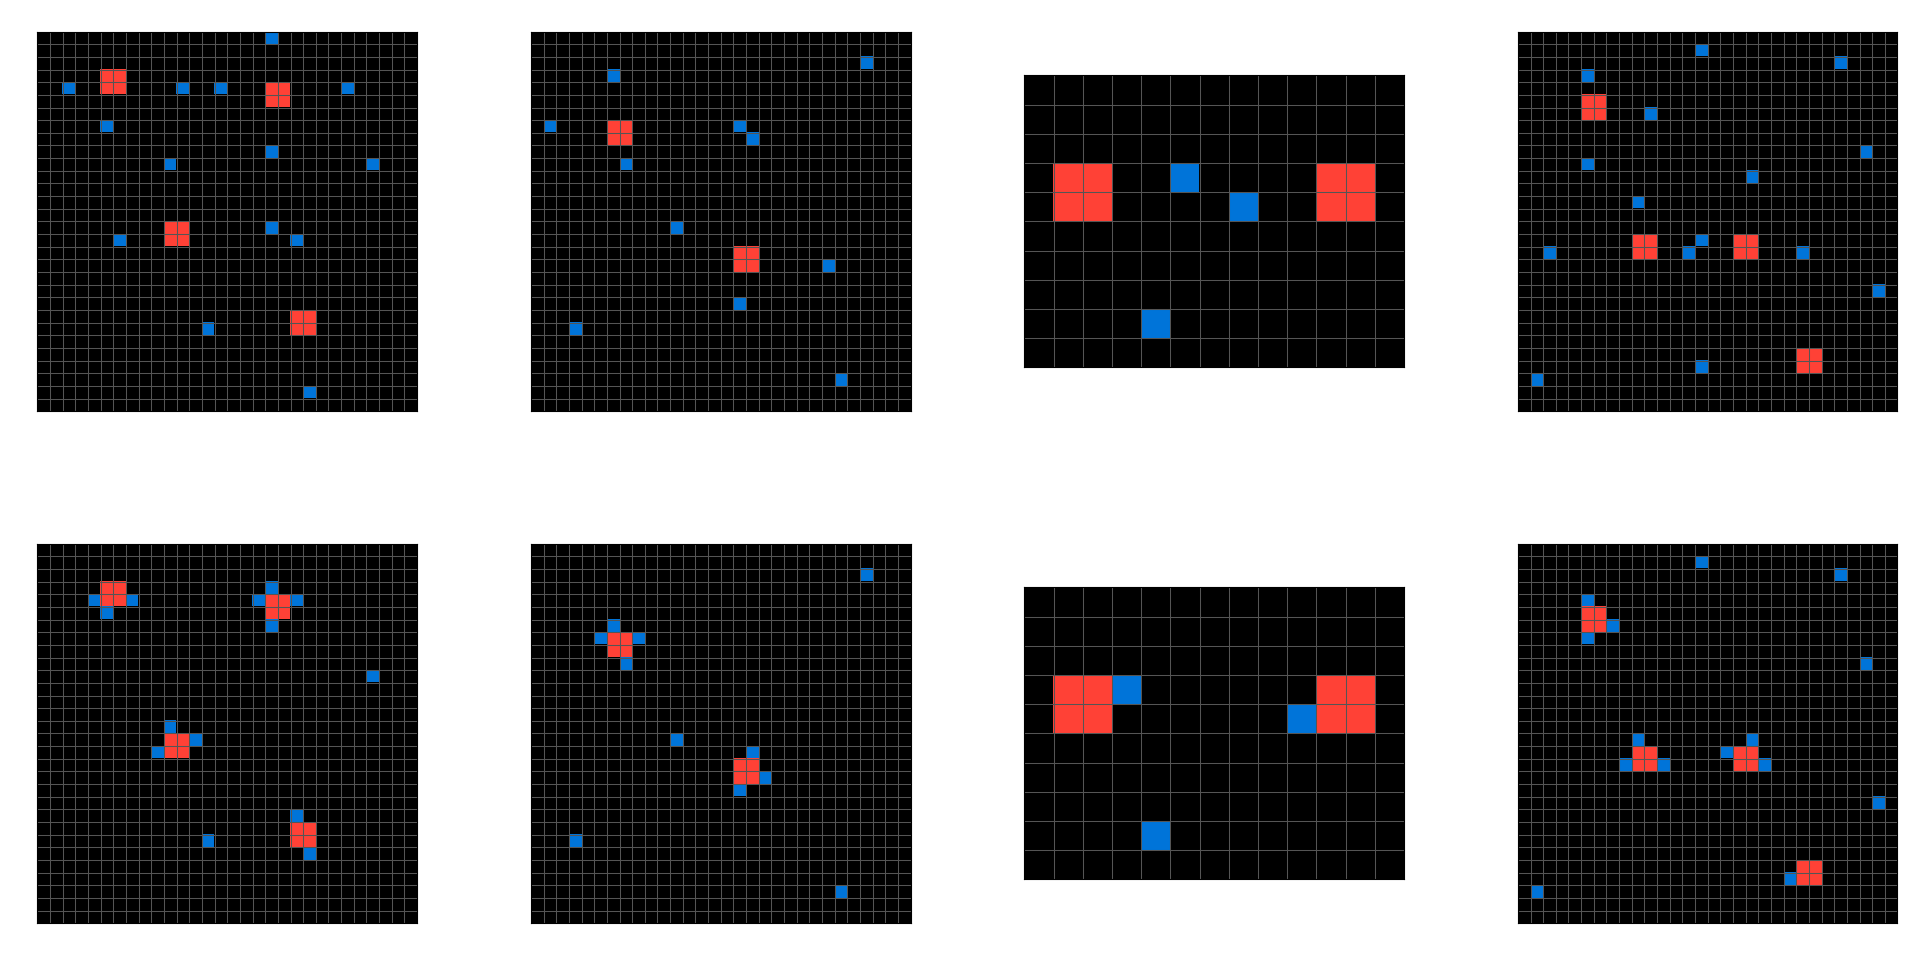

In [657]:
task.plot()

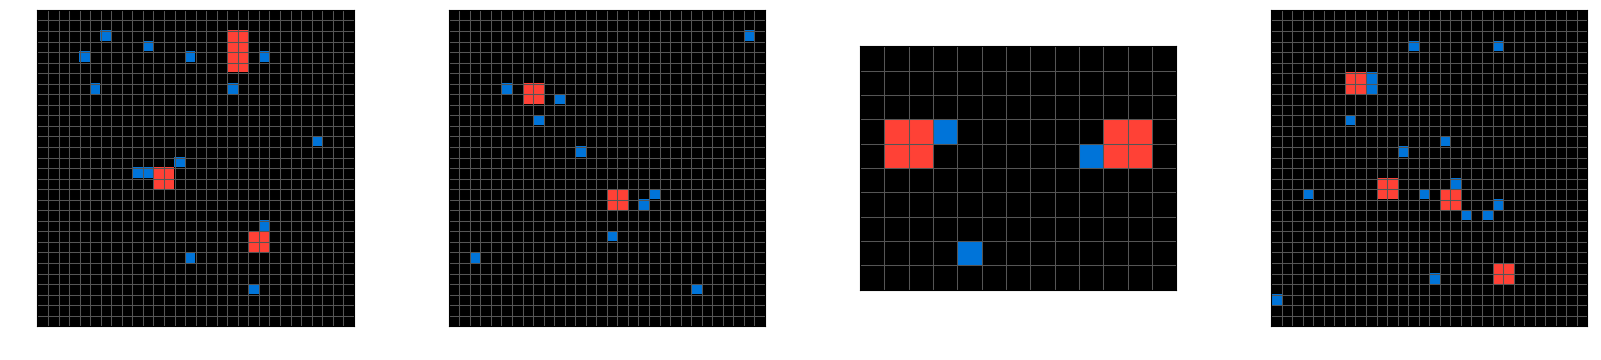

In [710]:
plot_states(ex_preds, graph_preds, task.output_shapes)

In [257]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Patch
from matplotlib.patches import FancyArrow, FancyArrowPatch
from matplotlib.patches import Rectangle as Rectangle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

from matplotlib.collections import Collection, PathCollection, LineCollection


def draw_graph(graph, 
               node_to_pos=None,
               ax=None,
               method='fruchterman',
               arrows=None,
               facecolor='#373d4b',
               grid_scale=1.,
               obj_scale=.2,
               label=None,
               seed=None,
               **kwargs):
    """Draw a graph G with Matplotlib.

    Parameters
    ----------
    G : graph
       A networkx graph
    pos : dictionary, optional
       A dictionary with nodes as keys and positions as values.
       If not specified a spring layout positioning will be computed.
       See :py:mod:`networkx.drawing.layout` for functions that
       compute node positions.
    ax : Matplotlib Axes object, optional
       Draw the graph in specified Matplotlib axes.
    kwds : optional keywords
       See networkx.draw_networkx() for a description of optional keywords.
    """
    node_params = kwargs.pop('node_params', {})
    edge_params = kwargs.pop('edge_params', {})
    pos_params = kwargs.pop('pos_params', {})
    random_state = np.random.RandomState(seed)
    
    if ax is None:
        cf = plt.gcf()
        if cf._axstack() is None:
            pass
            ax = cf.add_axes((0, 0, 1, 1))
        else:
            ax = cf.gca()
    else:
        cf = ax.get_figure()
    
    cf.set_facecolor(facecolor)
    
    if node_to_pos is None:
        if method == 'spectral':
            node_to_pos = spectral_pos(graph)
        else:
            node_to_pos = fruchterman_reingold_pos(graph, 
                                                   random_state=random_state,
                                                   **pos_params)
        
    node_collections = draw_nodes(graph, 
                                  node_to_pos, 
                                  facecolor=facecolor,
                                  obj_scale=obj_scale,
                                  label=label,
                                  random_state=random_state,
                                  **node_params)
    if len(graph.edges) > 0:
        edge_collections, arrow_collections = draw_edges(graph, 
                                                        node_to_pos,
                                                        arrows=arrows,
                                                        random_state=random_state,
                                                        **edge_params)
    
    scale = max(len([ar for ar in ax.artists if isinstance(ar, (Collection, AnnotationBbox))]), 1)
    gh, gw = grid_scale if isinstance(grid_scale, (list, tuple)) else (grid_scale, grid_scale)
    cf.set_figheight(cf.get_figheight() * np.sqrt(scale) * gh)
    cf.set_figwidth(cf.get_figwidth() * np.sqrt(scale) * gw)
    ax.margins(.25)

    plt.draw_if_interactive()
    ax.set_axis_off()

    
def draw_nodes(graph, 
               node_to_pos,
               nodes=None,
               ax=None,
               s=1000,
               obj_scale=.5,
               edgecolors='#fff',
               facecolor='#1f78b4',
               marker='o',
               label=None,
               **kwargs):
    """Draw the nodes of a grahp.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    pos : dictionary
       A dictionary with nodes as keys and positions as values.
       Positions should be sequences of length 2.
    ax : Matplotlib Axes object, optional
       Draw the graph in the specified Matplotlib axes.
    nodes : list, optional
       Draw only specified nodes (default G.nodes())
    
    Returns
    -------
    matplotlib.collections.PathCollection
        `PathCollection` of the nodes.
    """
    if ax is None:
        ax = plt.gca()
        
    label_params = kwargs.get('label_params', {})
    label_params['size'] = label_params.get('size', 10)

    if nodes is None:
        nodes = list(graph)
    if len(nodes) == 0:
        return PathCollection(None)
    
    try:
        xy = np.asarray([node_to_pos[u] for u in nodes])
    except KeyError as e:
        raise KeyError(f"Node {e} is not found in `node_to_pos`.")

    for i, u in enumerate(nodes):
        if u.is_obj() and obj_scale > 0:
            node_paths = ax.scatter(xy[:, 0],
                                    xy[:, 1],
                                    s=1,
                                    edgecolors=edgecolors,
                                    facecolors=facecolor,
                                    marker=marker)
            size = u.datasource.size
            imagebox = OffsetImage(u.img, zoom=max(np.log(size), .3) * obj_scale)
            imagebox.image.axes = ax
            ab = AnnotationBbox(imagebox, 
                                xy[i],
                                xybox=(.0, .0),
                                frameon=True,
                                xycoords='data',
                                pad=.3,
                                bboxprops={'lw': 1},
                                boxcoords="offset points",)
            ax.add_artist(ab)
        else:
            fc = 'w' if u.selfloops > 0 else facecolor
            node_paths = ax.scatter(xy[i, 0],
                                    xy[i, 1],
                                    s=s,
                                    edgecolors=edgecolors,
                                    facecolors=fc,
                                    linewidths=2.,
                                    marker=marker,
                                    zorder=3)
            ax.add_artist(node_paths)
            if label is not None:
                lbl = ax.annotate(getattr(u, label),
                                  xy=xy[i], 
                                  xycoords="data",
                                  xytext=xy[i],
                                  textcoords="offset points",
                                  ha="center",
                                  va="center",
#                                   zorder=4,
                                  **label_params)
                ax.add_artist(lbl)
    
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

#     node_paths.set_zorder(2)
    return node_paths


def draw_edges(graph, 
               node_to_pos,
               edges=None,
               nodes=None,
               ax=None,
               **kwargs):
    """Draws the edges of a graph.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    pos : dictionary
       A dictionary with nodes as keys and positions as values.
       Positions should be sequences of length 2.
    edges : collection of edge tuples
       Draw only specified edges(default=G.edges())
    """
    edge_collection = None
    arrow_collections = []
    
    ax = plt.gca() if ax is None else ax
    edges = graph.edges if edges is None else edges
    d_edges = [e for e in edges if e.get('directed')]
    ud_edges = [e for e in edges if not e.get('directed')]
    # self loop edges
    
    if len(edges) == 0:
        return LineCollection(None)
    
    nodes = graph.nodes if nodes is None else nodes 
    ud_pos = np.asarray([
        (node_to_pos[e.nodes[0]], node_to_pos[e.nodes[1]]) for e in ud_edges
    ])
    d_pos = np.asarray([
        (node_to_pos[e.nodes[0]], node_to_pos[e.nodes[1]]) for e in d_edges
    ])
    
    if len(ud_edges) > 0:
        line_params = {
            'color': kwargs.get('color', 'w'),
            'linewidth': kwargs.get('linewidth', 2.),
            'arrowstyle': '-'
        }
        
        for i in range(len(ud_edges)):
            ar = FancyArrowPatch(ud_pos[i,0], 
                                 ud_pos[i,1],
                                 mutation_scale=10,
                                 zorder=1,
                                 **line_params)
            ax.add_artist(ar)
    
    if len(d_edges) > 0:
        head_pos = d_pos[:,1] - .1 * (d_pos[:,1] - d_pos[:,0])
        tail_pos = d_pos[:,0] 
#         diff_pos = (head_pos - tail_pos) - .1 * (head_pos - tail_pos)
        
        arrow_params = {
            'ec': 'w',
            'fc': 'w',
            'lw': 2,
            'head_length': .025,
            'head_width': .025
        }
        
        for i in range(len(d_edges)):
            ar = FancyArrowPatch(tail_pos[i],
                                 head_pos[i], 
                                 arrowstyle='-|>', 
                                 mutation_scale=20,
                                 linewidth=3,
                                 zorder=2,)
            ax.add_artist(ar)
            arrow_colallections.append(ar)
            
    return edge_collection, arrow_collections


In [259]:

def get_adj_matrix(graph,
                   nodes=None,
                   dtype='float32',
                   order='C'):
    """Returns the adjacency matrix of a graph.
    
    Parameters
    ----------
    graph : Graph
        The NetworkX graph used to construct the NumPy array.
    nodes : list, optional
        The rows and columns are ordered according to the nodes in `nodelist`.
        If `nodelist` is None, then the ordering is produced by G.nodes().
    dtype : NumPy data type, optional
        A valid single NumPy data type used to initialize the array.
        This must be a simple type such as int or numpy.float64 and
        not a compound data type (see to_numpy_recarray)
        If None, then the NumPy default is used.
    order : {'C', 'F'}, optional
        Whether to store multidimensional data in C- or Fortran-contiguous
        (row- or column-wise) order in memory. If None, then the NumPy default
        is used.
    """
    if nodes is None:
        nodes = list(graph)
    if len(set(nodes)) < len(nodes):
        raise ValueError(f'Found duplicates in `nodes`')

    num_nodes = len(nodes)
    node_to_idx = {u.name: i for i, u in enumerate(nodes)}
    
    A = np.zeros((num_nodes, num_nodes), dtype=dtype, order=order)
    for u, nbrs in graph.adjacency():
        for v, edge in nbrs.items():
            A[node_to_idx[u], node_to_idx[v]] = edge.get('weight', 1)

    return A

def scale_layout(pos, scale=1):
    """Returns scaled position array to (-scale, scale) in all axes.
    
    Parameters
    ----------
    pos : numpy array
        positions to be scaled. Each row is a position.
    scale : number (default: 1)
        The size of the resulting extent in all directions.
    Returns
    -------
    pos : numpy array
        scaled positions. Each row is a position.
    """
    # Find max length over all dimensions
    lim = 0  # max coordinate for all axes
    for i in range(pos.shape[1]):
        pos[:, i] -= pos[:, i].mean()
        lim = max(abs(pos[:, i]).max(), lim)
    # rescale to (-scale, scale) in all directions, preserves aspect
    if lim > 0:
        for i in range(pos.shape[1]):
            pos[:, i] *= scale / lim
    return pos


def spectral_pos(graph,
                  k=None,
                  node_to_pos=None,
                  fixed=None,
                  iterations=500,
                  th=1e-4,
                  scale=1,
                  center=None,
                  dim=2,
                  random_state=None):
    """Position nodes using the eigenvectors of the Laplacian."""
    center = np.zeros(dim) if center is None else center
    nodes = list(graph.nodes) # change this later
    num_nodes = len(nodes)
    
    if num_nodes == 0:
        return {}
    if num_nodes == 1:
        return {next(iter(nodes)): center}
    
    if random_state is None:
        random_state = np.random.RandomState(None)
            
    if node_to_pos is not None:
        size = max(1, *[x for pos in node_to_pos.values() for x in pos])
        pos = random_state.rand(num_nodes, dim) * size + center

        for i, node in enumerate(nodes):
            if node in node_to_pos:
                pos[i] = np.asarray(node_to_pos[node])
    else:
        pos = None
        size = 1

    if k is None and fixed is not None:
        k = np.sqrt(size / num_nodes)
        
    pos = _spectral_pos(A=graph.numpy())
    
    if fixed is None and scale is not None:
        pos = scale_layout(pos, scale=scale) + center
    
    return {nodes[i]: pos[i] for i in range(num_nodes)}


def _spectral_pos(A, dim=2):
    num_nodes = len(A)
    # form Laplacian matrix where D is diagonal of degrees
    D = np.identity(num_nodes, dtype=A.dtype) * np.sum(A, axis=1)
    L = D - A

    eigenvalues, eigenvectors = np.linalg.eig(L)
    # sort and keep smallest nonzero
    index = np.argsort(eigenvalues)[1:dim + 1]  # 0 index is zero eigenvalue
    return np.real(eigenvectors[:, index])


def fruchterman_reingold_pos(graph,
                              k=None,
                              node_to_pos=None,
                              fixed=None,
                              iterations=50,
                              th=1e-4,
                              scale=1,
                              center=None,
                              dim=2,
                              random_state=None):
    """Position nodes using Fruchterman-Reingold force-directed algorithm.
    Parameters
    ----------
    G : NetworkX graph or list of nodes
        A position will be assigned to every node in G.
    k : float (default=None)
        Optimal distance between nodes.  If None the distance is set to
        1/sqrt(n) where n is the number of nodes.  Increase this value
        to move nodes farther apart.
    node_to_pos : dict or None  optional (default=None)
        Initial positions for nodes as a dictionary with node as keys
        and values as a coordinate list or tuple.  If None, then use
        random initial positions.
    fixed : list or None  optional (default=None)
        Nodes to keep fixed at initial position.
        ValueError raised if `fixed` specified and `pos` not.
    iterations : int  optional (default=50)
        Maximum number of iterations taken
    th: float optional (default = 1e-4)
        Threshold for relative error in node position changes.
        The iteration stops if the error is below this threshold.
    scale : number or None (default: 1)
        Scale factor for positions. Not used unless `fixed is None`.
        If scale is None, no rescaling is performed.
    center : array-like or None
        Coordinate pair around which to center the layout.
        Not used unless `fixed is None`.
    dim : int
        Dimension of layout.
    Returns
    -------
    pos : dict
        A dictionary of positions keyed by node
    """
    center = np.zeros(dim) if center is None else center
    nodes = list(graph.nodes) # change this later
    num_nodes = len(nodes)
    
    if num_nodes == 0:
        return {}
    if num_nodes == 1:
        return {next(iter(nodes)): center}
    
    if random_state is None:
        random_state = np.random.RandomState(None)
            
    if node_to_pos is not None:
        size = max(1, *[x for pos in node_to_pos.values() for x in pos])
        pos = random_state.rand(num_nodes, dim) * size + center

        for i, node in enumerate(nodes):
            if node in node_to_pos:
                pos[i] = np.asarray(node_to_pos[node])
    else:
        pos = None
        size = 1

#     if k is None and fixed is not None:
#         k = np.sqrt(size / num_nodes)
        
    pos = _fruchterman_reingold_pos(
        graph.numpy(),
        k=k, 
        pos=pos, 
        fixed=fixed, 
        iterations=iterations,
        th=th, 
        dim=dim, 
        random_state=random_state
    )
    
    if fixed is None and scale is not None:
        pos = scale_layout(pos, scale=scale) + center
    
    return {nodes[i]: pos[i] for i in range(num_nodes)}


def _fruchterman_reingold_pos(X, 
                              k=None,
                              pos=None,
                              fixed=None,
                              iterations=50,
                              th=1e-4, 
                              dim=2,
                              random_state=None):
    
    """Graph Drawing by Force-directed Placement
    (http://faculty.washington.edu/joelross/courses/archive/f14/cs261/lab/j/fruchterman91graph.pdf)
    """
    num_nodes = len(X)
    if pos is None:
        if random_state is None:
            random_state = np.random.RandomState(None)
        pos = random_state.rand(num_nodes, dim)
    
    pos = pos.astype(X.dtype)
    k = np.sqrt(1. / num_nodes) if k is None else k
#     k = np.sqrt(np.log(num_nodes)) / 4 if k is None else k
    t = max(max(pos.T[0]) - min(pos.T[0]), max(pos.T[1]) - min(pos.T[1])) * 0.01
    dt = t / (iterations + 1)
    delta = np.zeros((pos.shape[0], pos.shape[0], pos.shape[1]), dtype=X.dtype)
    
    for _ in range(100):
        delta = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]
        distance = np.clip(np.linalg.norm(delta, axis=-1), .01, None)
        displacement = np.einsum('ijk,ij->ik',
                                 delta,
                                 (k * k / distance**2 - X * distance / k))
        n = np.linalg.norm(displacement, axis=-1)
        n = np.where(n < .01, .1, n)
        delta_pos = np.einsum('ij,i->ij', displacement*2, t / n)
        if fixed is not None:
            delta_pos[fixed] = 0.
        pos += delta_pos
        t -= dt
        error = np.linalg.norm(delta_pos) / num_nodes
        if error < th:y
            break
            
    return pos